<a href="https://colab.research.google.com/github/rmehdi1/CommunityProject_Mobilize/blob/main/03_PredictiveModelPipeline_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDICTIVE MODELING PIPELINE

###  End-to-End Pipeline Architecture

This notebook forms a full **predictive analytics pipeline**:

1. **User Input & Configuration** – Tailor keyword weights, category definitions, and strategic feature scores.
2. **Data Validation & Cleaning** – Automatic checks for structure, completeness, and target label suitability.
3. **Feature Engineering** – Extracts advanced linguistic, structural, and strategic features from text.
4. **Predictive Modeling** – Trains interpretable machine learning models on success outcomes.
5. **Interpretation & Strategy Output** – Visualizes key insights and generates actionable recommendations.

This flexible architecture supports **replication across organizations** and allows **grassroots users to adapt it** for different advocacy goals—from fundraising appeals to legislative action.

### Flexibility & User Customization

This notebook is designed as a **modular and user-configurable pipeline**, allowing for high adaptability to different campaigns and datasets. Key flexible features include:

###  Customizable Configuration

- Users can adjust **keyword weighting** for each strategic messaging category (e.g., Urgency, Emotion, Power).
- Modify **composite feature weights** to prioritize different aspects of petition quality (e.g., readability vs. emotional intensity).
- Extend or replace keyword lists with **custom domain-specific language**, including translated terms or culturally relevant phrases.

###  Bring Your Own Dataset

- Easily upload a custom dataset (`inputdata.xlsx`) to run the full analysis.
- Must include basic columns (`target_success`, `title`, `description`); optional fields like `letter_body` enhance precision.
- Data validation steps ensure required fields are present, complete, and consistent.



# USER CONFIGURATION

In [ ]:
# ============================================================================
# USER CONFIGURATION BLOCK - CUSTOMIZE YOUR ANALYSIS
# ============================================================================
"""
🎯 PETITION SUCCESS PREDICTOR - USER CUSTOMIZATION SETTINGS

This section allows you to customize the analysis based on your specific needs.
Modify the values below to adjust how the model analyzes petition text.

IMPORTANT: Changes here will affect feature engineering and model predictions.
Only modify if you understand the impact on your analysis.
"""

print("⚙️ LOADING USER CONFIGURATION SETTINGS")
print("="*60)

# ============================================================================
# 1. KEYWORD WEIGHTING SYSTEM
# ============================================================================
"""
📊 KEYWORD WEIGHTING METHODOLOGY

These weights determine how much each keyword category contributes to the
strategic scoring of petitions. Based on behavioral psychology research:

- Cialdini (2006): Influence principles (urgency=scarcity, social proof)
- Berger & Milkman (2012): Emotional contagion in viral content
- Digital marketing research: Urgency language effectiveness

CURRENT ASSUMPTIONS:
- All categories weighted equally (1.0) for balanced analysis

HOW TO MODIFY:
- Increase weight (e.g., 2.0) to emphasize that category more
- Decrease weight (e.g., 0.5) to de-emphasize that category
- Set to 0 to completely ignore that category
"""

KEYWORD_WEIGHTS = {
    'urgency': 1.0,        # Time pressure, immediacy, crisis language
    'emotional': 1.0,      # Emotional appeals, feelings, reactions
    'social_proof': 1.0,   # Community, others joining, popular support
    'power': 1.0,          # Justice, rights, fairness, moral authority
    'action': 1.0,         # Calls to action, demands, imperatives
    'authority': 1.0,      # Government, officials, institutions
    'specificity': 1.0     # Numbers, data, statistics, evidence
}

print(f"📊 Keyword weights loaded: {sum(KEYWORD_WEIGHTS.values())} total weight across {len(KEYWORD_WEIGHTS)} categories")
# ============================================================================
# 2. STRATEGIC COMPOSITE FEATURE WEIGHTS
# ============================================================================
"""
🎯 STRATEGIC COMPOSITE FEATURE CONFIGURATION

These settings control how the high-level strategic features are calculated
by combining multiple text quality indicators. Each composite feature uses
weighted combinations of underlying metrics.

FEATURE DEFINITIONS:
- Professional Sophistication: Measures perceived credibility and expertise through language complexity and formatting
- Strategic Urgency: Captures time pressure and action-oriented language that motivates immediate response
- Content Comprehensiveness: Quantifies information depth and thoroughness across all petition components
- Authority Targeting: Measures specificity and appropriateness of targeting decision-makers
- Message Coherence: Assesses consistency of tone, complexity, and messaging across petition sections
- Emotional Resonance: Captures emotional appeal and intensity that drives sharing and engagement

WEIGHTING ASSUMPTIONS:
- Based on petition platform analysis and digital engagement patterns
- Emphasizes elements that correlate with signature acquisition and sharing behavior
- Prioritizes components with highest visibility and decision-making impact

HOW TO MODIFY:
- Adjust weights to emphasize different aspects of petition quality
- Change feature combinations to match your success criteria
- Modify component scaling based on your platform's characteristics
"""

# Professional Sophistication Score Weights
# DEFINITION: Measures perceived credibility and expertise through language complexity and formatting
# PURPOSE: Sophisticated content builds trust and authority with both signers and decision-makers
PROFESSIONAL_SOPHISTICATION_WEIGHTS = {
    'title_complexity': 0.5,     # Highest weight - titles are the first credibility signal (50%)
                                # Complex titles suggest serious, well-researched petition
    'description_length': 0.2,   # Lower weight - length shows effort but can overwhelm (20%)
                                # Detailed descriptions indicate thorough preparation
    'html_formatting': 0.3       # Moderate weight - professional formatting signals legitimacy (30%)
                                # Visual presentation affects perceived quality and trustworthiness
}

# Strategic Urgency Score Weights
# DEFINITION: Captures time pressure and action-oriented language that motivates immediate response
# PURPOSE: Urgency creates psychological pressure to act now rather than postpone signing
STRATEGIC_URGENCY_WEIGHTS = {
    # Primary method weights (used when weighted_keywords available)
    'weighted_keywords': 0.8,    # Dominant weight - urgency language directly drives action (80%)
                                # Words like "immediate," "crisis," "deadline" create time pressure
    'sentiment': 0.2,            # Supporting weight - positive sentiment enables action (20%)
                                # Negative sentiment alone can paralyze; positive opens possibilities

    # Fallback method weights (used when weighted_keywords NOT available)
    'urgency_count': 0.5,        # Direct urgency language detection (50%)
    'action_count': 0.3,         # Behavioral activation cues (30%)
    'sentiment_fallback': 0.2    # Emotional context in fallback mode (20%)
}

# Content Comprehensiveness Score Configuration
# DEFINITION: Quantifies information depth and thoroughness across all petition components
# PURPOSE: Comprehensive content provides complete context and justification for the petition ask
CONTENT_COMPREHENSIVENESS_WEIGHTS = {
    'title_multiplier': 2.0,        # Doubled weight - titles have disproportionate visibility (200%)
                                   # Most people see only the title in social feeds and search results
    'description_multiplier': 1.0,  # Standard weight - main content that explains the issue (100%)
                                   # Core information where most persuasion happens
    'letter_body_multiplier': 0.8   # Reduced weight - often duplicates description content (80%)
                                   # Important for decision-makers but less visible to general public
}

# Authority Targeting Score Weights
# DEFINITION: Measures specificity and appropriateness of targeting decision-makers
# PURPOSE: Properly targeted petitions reach the right people with power to create change
AUTHORITY_TARGETING_WEIGHTS = {
    'title_authority': 1.5,         # Enhanced weight - authority in title shows clear targeting
                                   # Titles like "Minister of Health: Stop the Crisis" immediately show target
    'description_authority': 1.0,   # Standard weight - authority context throughout content (100%)
                                   # Sustained focus on specific decision-makers and their roles
    'targeting_length_divisor': 15  # Reduced divisor - specificity matters more than length
                                   # Concise, specific targeting beats lengthy generic appeals
}

# Message Coherence Score Weights
# DEFINITION: Assesses consistency of tone, complexity, and messaging across petition sections
# PURPOSE: Coherent messaging feels professional and trustworthy; inconsistency suggests poor planning
MESSAGE_COHERENCE_WEIGHTS = {
    'complexity_consistency': 0.3,  # Lower weight - some complexity variation is natural (30%)
                                   # Titles can be simpler while descriptions are more detailed
    'sentiment_consistency': 0.7    # Higher weight - emotional tone should remain consistent (70%)
                                   # Mixed emotions (hopeful title, angry description) confuse readers
}

# Emotional Resonance Score Weights
# DEFINITION: Captures emotional appeal and intensity that drives sharing and engagement
# PURPOSE: Emotional content gets shared more, creates personal connection, motivates action
EMOTIONAL_RESONANCE_WEIGHTS = {
    'title_emotional': 3.0,         # Triple weight - assumption-  emotional titles drive social media sharing
                                   # Titles with emotional words get clicked and shared exponentially more
    'description_emotional': 1.0,   # Standard weight - sustained emotional engagement (100%)
                                   # Emotional stories in descriptions create personal connection
    'letter_body_emotional': 0.5    # Reduced weight - formal communication often less emotional (50%)
                                   # Letters to officials typically require more professional tone
}

print(f"🎯 Strategic feature weights loaded: {len([PROFESSIONAL_SOPHISTICATION_WEIGHTS, STRATEGIC_URGENCY_WEIGHTS, CONTENT_COMPREHENSIVENESS_WEIGHTS, AUTHORITY_TARGETING_WEIGHTS, MESSAGE_COHERENCE_WEIGHTS, EMOTIONAL_RESONANCE_WEIGHTS])} weight groups configured")

# ============================================================================
# 3. KEYWORD DEFINITIONS - CUSTOMIZE YOUR ANALYSIS FOCUS
# ============================================================================
"""
📝 KEYWORD CATEGORY DEFINITIONS

These lists define what words/phrases count for each strategic category.
The model counts occurrences of these terms in petition text.

CURRENT ASSUMPTIONS:
- Based on Change.org petition analysis and persuasion research
- Optimized for civic/political petition language
- English-language focused

HOW TO MODIFY:
- Add domain-specific terms for your industry/cause
- Remove irrelevant terms for your context
- Translate terms for non-English petitions
- Add cultural/regional variations
"""

# 🚨 URGENCY & CRISIS LANGUAGE
# Words that create time pressure and immediate action
URGENCY_KEYWORDS = [
    # Immediate time pressure
    'urgent', 'immediate', 'immediately', 'now', 'today', 'emergency', 'crisis',
    'deadline', 'time running out', "before it's too late", 'last chance',
    'act now', 'breaking', 'critical', 'asap', 'quickly', 'rapidly', 'soon',

    # Deadline-based urgency
    'time sensitive', 'expires', 'final notice', 'running out', 'running out of time',
    'closing soon', 'minutes left', 'hours left', 'act fast', 'clock is ticking',
    'urgent appeal', 'right away', "don't wait", 'rush', 'imminent',

    # ADD YOUR URGENCY TERMS HERE & REMOVE THE HASHTAG FROM THE LINE BELOW:
    # 'custom_urgent_term1', 'custom_urgent_term2'
]

# 🎯 ACTION & DEMAND LANGUAGE
# Direct calls to action and specific demands
ACTION_KEYWORDS = [
    # Direct action verbs
    'stop', 'save', 'protect', 'demand', 'fight', 'defend', 'prevent',
    'ban', 'end', 'cancel', 'reverse', 'change', 'fix', 'solve',
    'help', 'support', 'join', 'sign', 'act', 'take action', 'make',

    # Implementation demands
    'force', 'require', 'ensure', 'guarantee', 'implement', 'establish',
    'mandate', 'enforce', 'commit', 'pledge', 'promise', 'repeal',
    'prosecute', 'petition', 'regulate', 'authorize', 'decriminalize',

    # Engagement calls
    'ratify', 'investigate', 'propose', 'suspend', 'intervene', 'urge',
    'ask', 'encourage', 'invite', 'participate', 'mobilize',

    # ADD YOUR ACTION TERMS HERE & REMOVE THE HASHTAG FROM THE LINE BELOW
    # 'custom_action_term1', 'custom_action_term2'
]

# ⚡ POWER & JUSTICE LANGUAGE
# Moral authority, rights, fairness appeals
POWER_WORDS = [
    # Justice and rights
    'justice', 'freedom', 'rights', 'equality', 'fair', 'unfair', 'wrong',
    'illegal', 'violation', 'abuse', 'corruption', 'scandal', 'outrage',
    'discrimination', 'injustice', 'betrayal', 'exploitation', 'oppression',

    # Accountability language
    'accountability', 'threat', 'dangerous', 'complicit', 'cover-up',
    'devastating', 'unjust', 'systemic', 'outrageous', 'unconscionable',
    'inexcusable', 'intolerable', 'unacceptable', 'shameful',

    # Historic significance
    'historic', 'unprecedented', 'groundbreaking', 'transformative',

    # ADD YOUR POWER TERMS HERE & REMOVE THE HASHTAG FROM THE LINE BELOW
    # 'custom_power_term1', 'custom_power_term2'
]

# 🏛️ AUTHORITY & TARGETING LANGUAGE
# Government, institutions, decision-makers
AUTHORITY_KEYWORDS = [
    # Government levels
    'government', 'minister', 'ministry', 'department', 'authority', 'official',
    'court', 'judge', 'police', 'administration', 'commissioner', 'director',
    'secretary', 'chief', 'president', 'prime minister', 'governor',

    # Legislative bodies
    'congress', 'senate', 'parliament', 'agency', 'task force', 'ombudsman',
    'representative', 'lawmaker', 'mp', 'council', 'board of directors',

    # Executive roles
    'ceo', 'executive', 'chairman', 'superintendent', 'mayor', 'supervisor',
    'inspector general', 'attorney general',

    # ADD YOUR AUTHORITY TERMS HERE & REMOVE THE HASHTAG FROM THE LINE BELOW
    # 'custom_authority_term1', 'custom_authority_term2'
]

# 📊 SPECIFICITY & EVIDENCE LANGUAGE
# Numbers, data, research, credibility markers
SPECIFICITY_KEYWORDS = [
    # Quantitative terms
    'million', 'thousand', 'billion', 'percent', '%', 'statistics', 'data',
    'study', 'research', 'report', 'evidence', 'facts', 'numbers',

    # Research credibility
    'peer-reviewed', 'metrics', 'surveys', 'benchmark', 'statistical',
    'trend', 'projection', 'figures',

    # ADD YOUR SPECIFICITY TERMS HERE & REMOVE THE HASHTAG FROM THE LINE BELOW
    # 'custom_data_term1', 'custom_data_term2'
]

# 👥 SOCIAL PROOF LANGUAGE
# Community, momentum, popular support
SOCIAL_PROOF_KEYWORDS = [
    # Community joining
    'join thousands', 'others are signing', 'momentum building', 'growing movement',
    'people like you', 'your neighbors', 'community members', 'together we',

    # Viral/trending language
    'viral petition', 'everyone is signing', 'shared widely', 'trending now',
    'thousands have joined', 'massive response', 'popular support',
    'join your neighbors', 'be part of history',

    # ADD YOUR SOCIAL PROOF TERMS HERE & REMOVE THE HASHTAG FROM THE LINE BELOW
    # 'custom_social_term1', 'custom_social_term2'
]


# 😢 EMOTIONAL LANGUAGE
EMOTIONAL_KEYWORDS = [
    # Negative emotions (high-impact, motivating)
    'heartbreaking', 'devastating', 'tragic', 'unthinkable', 'painful',
    'outraged', 'terrified', 'afraid', 'fear', 'scared', 'anxious', 'panic',
    'hopeless', 'angry', 'sadness', 'despair', 'frustration', 'helpless',
    'shocked', 'mourning', 'grief', 'heartbroken', 'in pain', 'crushed',
    'violated', 'abandoned', 'betrayed', 'silenced', 'ignored', 'suffering',
    'injustice', 'trauma',


    # Complex/ambivalent emotions
    'conflicted', 'cautious', 'skeptical', 'concerned', 'overwhelmed',
    'uncertain', 'torn', 'hesitant', 'weary', 'pressured', 'burdened', 'confused',

    # Emotionally charged phrases
    'outrage', 'scandal', 'betrayal', 'injustice', 'dignity', 'rights violated',
    'fighting back', 'no more silence', 'breaking point', 'enough is enough',
    'rising up', 'spark change', 'powerful moment', 'emotional plea',
    'deeply personal', 'call for humanity',


    # ADD YOUR EMOTIONAL TERMS HERE & REMOVE THE HASHTAG FROM THE LINE BELOW
    # 'custom_emotion_term1', 'custom_emotion_term2'
]
# 📢 CALL-TO-ACTION PATTERNS
# Regex patterns for detecting petition calls-to-action
CTA_PATTERNS = [
    # Direct action requests
    r'\bsign\s+this\b', r'\bsign\s+now\b', r'\bsign\s+the\s+petition\b',
    r'\bjoin\s+us\b', r'\bjoin\s+me\b', r'\bjoin\s+this\b', r'\bjoin\s+the\b',
    r'\bhelp\s+us\b', r'\bhelp\s+me\b', r'\bhelp\s+save\b', r'\bhelp\s+stop\b',
    r'\bsupport\s+this\b', r'\bsupport\s+us\b', r'\bsupport\s+me\b',

    # Action + urgency combinations
    r'\btake\s+action\b', r'\bact\s+now\b', r'\bact\s+today\b', r'\bact\s+immediately\b',
    r'\bmake\s+a\s+difference\b', r'\bmake\s+your\s+voice\s+heard\b',
    r'\bstand\s+with\b', r'\bstand\s+up\b', r'\bspeak\s+up\b',

    # Demand/petition language
    r'\bdemand\s+action\b', r'\bdemand\s+change\b', r'\bdemand\s+justice\b',
    r'\bstop\s+this\b', r'\bstop\s+them\b', r'\bend\s+this\b',
    r'\bforce\s+them\b', r'\bmake\s+them\b',

    # Petition-specific CTAs
    r'\badd\s+your\s+name\b', r'\badd\s+your\s+voice\b', r'\blend\s+your\s+voice\b',
    r'\bshow\s+your\s+support\b', r'\bvoice\s+your\s+support\b',
    r'\blet\s+them\s+know\b', r'\btell\s+them\b', r'\bsend\s+a\s+message\b',

    # Community building CTAs
    r'\btogether\s+we\s+can\b', r'\bwe\s+need\s+your\b', r'\byour\s+signature\b',
    r'\bevery\s+signature\b', r'\beach\s+signature\b', r'\byour\s+voice\s+matters\b',

    # Social sharing CTAs
    r'\bshare\s+this\b', r'\bspread\s+the\s+word\b', r'\btell\s+your\s+friends\b',
    r'\bshare\s+with\b', r'\bpass\s+it\s+on\b',

    # Imperative verbs (petition context)
    r'\bfight\s+for\b', r'\bfight\s+against\b', r'\bdefend\b', r'\bprotect\b',
    r'\bsave\b', r'\bprevent\b', r'\bchange\b', r'\bfix\b', r'\bsolve\b',

    # ADD YOUR CTA PATTERNS HERE & REMOVE THE HASHTAG FROM THE LINE BELOW
    # r'\bcustom\s+cta\s+pattern\b', r'\banother\s+pattern\b'
]


# ============================================================================
# CONFIGURATION SUMMARY
# ============================================================================
print(f"\n✅ USER CONFIGURATION LOADED SUCCESSFULLY")
print("="*60)
print(f"📊 Keyword Categories: {len(KEYWORD_WEIGHTS)} with total weight {sum(KEYWORD_WEIGHTS.values())}")
print(f"🎯 Strategic Feature Weight Groups: {len([PROFESSIONAL_SOPHISTICATION_WEIGHTS, STRATEGIC_URGENCY_WEIGHTS, CONTENT_COMPREHENSIVENESS_WEIGHTS, AUTHORITY_TARGETING_WEIGHTS, MESSAGE_COHERENCE_WEIGHTS, EMOTIONAL_RESONANCE_WEIGHTS])}")
print(f"📝 Total Keywords Defined: {len(URGENCY_KEYWORDS + ACTION_KEYWORDS + POWER_WORDS + AUTHORITY_KEYWORDS + SPECIFICITY_KEYWORDS + SOCIAL_PROOF_KEYWORDS + EMOTIONAL_KEYWORDS)}")
print(f"📢 CTA Patterns Defined: {len(CTA_PATTERNS)}")
print("="*60)
print("🎯 Ready for petition analysis with your custom settings!")
print("📝 Modify values above and re-run this cell to update configuration")
print("="*60)

# ============================================================================
# VALIDATION WARNINGS
# ============================================================================
"""
⚠️ CONFIGURATION VALIDATION

Check for potential issues with user settings
"""

validation_warnings = []

# Check keyword weights
if sum(KEYWORD_WEIGHTS.values()) == 0:
    validation_warnings.append("❌ All keyword weights are zero - no strategic scoring will occur")
elif sum(KEYWORD_WEIGHTS.values()) > 10:
    validation_warnings.append("⚠️  Very high total keyword weights - may cause score inflation")

# Check strategic feature weights sum to 1.0 (approximately)
# Note: Strategic Urgency has two sets of weights (primary + fallback), so we check them separately
for weight_name, weight_dict in [
    ("Professional Sophistication", PROFESSIONAL_SOPHISTICATION_WEIGHTS),
    ("Message Coherence", MESSAGE_COHERENCE_WEIGHTS)
]:
    if abs(sum(weight_dict.values()) - 1.0) > 0.1:
        validation_warnings.append(f"⚠️  {weight_name} weights sum to {sum(weight_dict.values()):.2f}, not 1.0")

# Check Strategic Urgency weights separately (primary method)
primary_urgency_sum = STRATEGIC_URGENCY_WEIGHTS['weighted_keywords'] + STRATEGIC_URGENCY_WEIGHTS['sentiment']
if abs(primary_urgency_sum - 1.0) > 0.1:
    validation_warnings.append(f"⚠️  Strategic Urgency primary weights sum to {primary_urgency_sum:.2f}, not 1.0")

# Check Strategic Urgency fallback weights
fallback_urgency_sum = (STRATEGIC_URGENCY_WEIGHTS['urgency_count'] +
                       STRATEGIC_URGENCY_WEIGHTS['action_count'] +
                       STRATEGIC_URGENCY_WEIGHTS['sentiment_fallback'])
if abs(fallback_urgency_sum - 1.0) > 0.1:
    validation_warnings.append(f"⚠️  Strategic Urgency fallback weights sum to {fallback_urgency_sum:.2f}, not 1.0")

# Check for empty keyword lists
keyword_lists = [URGENCY_KEYWORDS, ACTION_KEYWORDS, POWER_WORDS, AUTHORITY_KEYWORDS,
                SPECIFICITY_KEYWORDS, SOCIAL_PROOF_KEYWORDS, EMOTIONAL_KEYWORDS]
if any(len(keywords) == 0 for keywords in keyword_lists):
    validation_warnings.append("⚠️  One or more keyword lists are empty")

# Check CTA patterns
if len(CTA_PATTERNS) == 0:
    validation_warnings.append("⚠️  No CTA patterns defined - call-to-action detection will not work")

# Check threshold reasonableness

if validation_warnings:
    print("⚠️  CONFIGURATION WARNINGS:")
    for warning in validation_warnings:
        print(f"   {warning}")
    print("   Please review your settings above")
else:
    print("✅ Configuration validation passed - no issues detected")

print("\n" + "="*60)

⚙️ LOADING USER CONFIGURATION SETTINGS
📊 Keyword weights loaded: 7.0 total weight across 7 categories
🎯 Strategic feature weights loaded: 6 weight groups configured

✅ USER CONFIGURATION LOADED SUCCESSFULLY
📊 Keyword Categories: 7 with total weight 7.0
🎯 Strategic Feature Weight Groups: 6
📝 Total Keywords Defined: 252
📢 CTA Patterns Defined: 59
🎯 Ready for petition analysis with your custom settings!
📝 Modify values above and re-run this cell to update configuration
✅ Configuration validation passed - no issues detected



# INSTALL RELEVANT PACKAGES

In [ ]:
# ============================================================================
# GOOGLE COLAB SETUP - RUN THIS CELL FIRST
# ============================================================================
"""
GOOGLE COLAB SETUP
Run this cell first to install any missing packages.
This will only install packages that aren't already available in Colab.
"""

import subprocess
import sys
import importlib
import warnings
warnings.filterwarnings('ignore')

print("🔧 SETTING UP PETITION SUCCESS PREDICTOR")
print("="*60)

# Check if we're in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("✅ Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("ℹ️  Running in local environment")

def check_and_install(package_name, import_name=None, install_name=None):
    """Check if package exists, install if missing"""
    if import_name is None:
        import_name = package_name
    if install_name is None:
        install_name = package_name

    try:
        importlib.import_module(import_name)
        print(f"✅ {package_name} - Already available")
        return True
    except ImportError:
        print(f"📦 Installing {package_name}...")
        try:
            if IN_COLAB:
                subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", install_name])
            else:
                subprocess.check_call([sys.executable, "-m", "pip", "install", install_name])
            print(f"✅ {package_name} - Installed successfully")
            return True
        except subprocess.CalledProcessError:
            print(f"❌ Failed to install {package_name}")
            return False

# Packages that might not be in Colab or need specific versions
packages_to_check = [
    # Package name, import name, install name
    ("textstat", "textstat", "textstat"),
    ("wordcloud", "wordcloud", "wordcloud"),
    ("shap", "shap", "shap"),
    ("openpyxl", "openpyxl", "openpyxl"),
    ("ipywidgets", "ipywidgets", "ipywidgets"),
]

print(f"\n🔍 Checking packages...")

failed_packages = []
for package_info in packages_to_check:
    if len(package_info) == 3:
        package_name, import_name, install_name = package_info
    else:
        package_name = import_name = install_name = package_info[0]

    if not check_and_install(package_name, import_name, install_name):
        failed_packages.append(package_name)

# Verify core imports work
print(f"\n🧪 Testing core imports...")
core_imports = [
    ("pandas", "pd"),
    ("numpy", "np"),
    ("matplotlib.pyplot", "plt"),
    ("seaborn", "sns"),
    ("sklearn", None),
    ("scipy", None),
    ("textstat", None)
]

import_errors = []
for module, alias in core_imports:
    try:
        if alias:
            exec(f"import {module} as {alias}")
        else:
            exec(f"import {module}")
        print(f"✅ {module}")
    except ImportError as e:
        print(f"❌ {module} - {e}")
        import_errors.append(module)

# Final status
print(f"\n" + "="*60)
if failed_packages or import_errors:
    print("⚠️  SETUP COMPLETED WITH WARNINGS")
    if failed_packages:
        print(f"Failed packages: {failed_packages}")
    if import_errors:
        print(f"Import errors: {import_errors}")
    print("The analysis may still work, but some features might be limited.")
else:
    print("🎉 SETUP COMPLETED SUCCESSFULLY!")
    print("✅ All packages are ready")
    print("✅ You can now run the petition success predictor")

print("="*60)
print("📋 Ready to analyze petitions! Continue with the next cells.")
print("="*60)

# Clean up namespace
del subprocess, sys, importlib, warnings


🔧 SETTING UP PETITION SUCCESS PREDICTOR
✅ Running in Google Colab

🔍 Checking packages...
✅ textstat - Already available
✅ wordcloud - Already available
✅ shap - Already available
✅ openpyxl - Already available
✅ ipywidgets - Already available

🧪 Testing core imports...
✅ pandas
✅ numpy
✅ matplotlib.pyplot
✅ seaborn
✅ sklearn
✅ scipy
✅ textstat

🎉 SETUP COMPLETED SUCCESSFULLY!
✅ All packages are ready
✅ You can now run the petition success predictor
📋 Ready to analyze petitions! Continue with the next cells.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
import numpy as np


# DATA LOADING & VALIDATION

Users can upload their own petition datasets to run the pipeline. To do this:

1. Name your file exactly as: `inputdata.xlsx`
2. Upload the file to the platform.
3. Ensure your Excel file contains the following structure:

### Required Columns
These columns **must** be present in the uploaded file:

- `target_success` — Binary or categorical indicator of petition success.
- `title` — Headline of the petition.
- `letter_body` — Main message or letter directed at the petition target.

### Optional Columns
These columns are not required, but will improve model accuracy and interpretation:

- `description` — Narrative background of the petition.
- `targeting_description` — Short version of the ask or appeal.
- `petition_ask` — One-line statement of what action is being requested.
- `original_locale` — Language or locale of the petition.
- `has_location` — Boolean or flag for geographic targeting.
- `petition_id` — Unique identifier for the petition.

Make sure your data is clean and well-structured to ensure optimal model performance.



In [ ]:
# ============================================================================
# PART 1: SETUP AND DATA LOADING
# ============================================================================

# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import string
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Text processing libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from textstat import flesch_reading_ease, flesch_kincaid_grade
try:
    from textstat import gunning_fog, automated_readability_index
except ImportError:
    print("Advanced readability metrics not available - using basic metrics only")
    def gunning_fog(text): return 0
    def automated_readability_index(text): return 0

from wordcloud import WordCloud

# Download required NLTK data
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)


# Load data
df = pd.read_excel('inputdata.xlsx', engine='openpyxl')
#df = pd.read_csv('inputdata.csv')

print("="*60)
print("CHANGE.ORG PETITION ANALYSIS SETUP")
print("="*60)
print(f"Dataset loaded successfully")
print(f"Shape: {df.shape}")
print(f"Columns: {df.shape[1]}")
print(f"Rows: {df.shape[0]}")


CHANGE.ORG PETITION ANALYSIS SETUP
Dataset loaded successfully
Shape: (3081, 10)
Columns: 10
Rows: 3081


In [ ]:
import pandas as pd
from pathlib import Path

def load_and_validate_data(filepath='inputdata.xlsx'):
    """
    Load and validate the input dataset for petition success prediction.

    This function performs initial data loading, column validation, and basic
    data quality checks to ensure the dataset meets minimum requirements
    for analysis.

    Parameters:
    -----------
    filepath : str
        Path to the input Excel file (default: 'inputdata.xlsx')

    Returns:
    --------
    tuple: (dataframe, validation_results)
        - dataframe: Loaded and validated pandas DataFrame
        - validation_results: Dictionary containing validation metrics
    """

    # Configuration: Define required and optional columns
    config = {
        'required_columns': ['target_success', 'title', 'description'],
        'optional_columns': ['letter_body', 'targeting_description', 'petition_ask',
                             'original_locale', 'has_location', 'petition_id'],
        'text_columns': ['title', 'description', 'letter_body', 'targeting_description'],
        'min_records': 100  # Minimum records required for reliable analysis
    }

    validation_results = {
        'file_loaded': False,
        'required_columns_present': False,
        'sufficient_records': False,
        'target_variable_valid': False,
        'text_columns_valid': False,
        'issues': []
    }

    print("="*60)
    print("PHASE 1: DATA INGESTION & VALIDATION")
    print("="*60)

    # Step 1: File Loading
    print("\n1. LOADING INPUT FILE")
    print("-" * 30)

    try:
        # Check if file exists
        if not Path(filepath).exists():
            raise FileNotFoundError(f"Input file '{filepath}' not found")

        # Load the Excel file
        df = pd.read_excel(filepath, engine='openpyxl')
        validation_results['file_loaded'] = True

        print(f"✓ File '{filepath}' loaded successfully")
        print(f"✓ Dataset shape: {df.shape}")
        print(f"✓ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    except Exception as e:
        validation_results['issues'].append(f"File loading error: {str(e)}")
        print(f"✗ Error loading file: {str(e)}")
        return None, validation_results

    # Step 2: Required Columns
    print("\n2. REQUIRED COLUMNS CHECK")
    print("-" * 30)
    missing = [col for col in config['required_columns'] if col not in df.columns]
    if missing:
        validation_results['issues'].append(f"Missing required columns: {missing}")
        print(f"✗ Missing required columns: {missing}")
    else:
        validation_results['required_columns_present'] = True
        print(f"✓ All required columns present")

    # Step 3: Record Count
    print("\n3. RECORD COUNT CHECK")
    print("-" * 30)
    n = len(df)
    if n < config['min_records']:
        validation_results['issues'].append(f"Only {n} records; need >= {config['min_records']}")
        print(f"✗ Insufficient records: {n} (< {config['min_records']})")
    else:
        validation_results['sufficient_records'] = True
        print(f"✓ Sufficient records: {n}")

    # Step 4: Target Variable Validity
    print("\n4. TARGET VARIABLE CHECK")
    print("-" * 30)
    if validation_results['required_columns_present']:
        if df['target_success'].dropna().isin([0, 1]).all():
            validation_results['target_variable_valid'] = True
            print("✓ 'target_success' looks valid (0/1)")
        else:
            vals = df['target_success'].unique().tolist()
            validation_results['issues'].append(f"Unexpected values in target_success: {vals}")
            print(f"✗ Unexpected values in 'target_success': {vals}")

    # Step 5: Text Columns Check
    print("\n5. TEXT COLUMNS CHECK")
    print("-" * 30)
    text_missing = [col for col in config['text_columns'] if col in df.columns and df[col].isnull().all()]
    if text_missing:
        validation_results['issues'].append(f"Text columns all-null: {text_missing}")
        print(f"✗ The following text columns are empty: {text_missing}")
    else:
        validation_results['text_columns_valid'] = True
        print("✓ Text columns appear populated")

    return df, validation_results

# Load the data
df, validation_results = load_and_validate_data()

# Summary
if df is not None:
    print("\nDATA VALIDATION RESULTS:")
    for k, v in validation_results.items():
        print(f"  {k}: {v}")
    print(f"\nDataset Columns: {list(df.columns)}")
    print("Data types:")
    print(df.dtypes)


PHASE 1: DATA INGESTION & VALIDATION

1. LOADING INPUT FILE
------------------------------
✓ File 'inputdata.xlsx' loaded successfully
✓ Dataset shape: (3081, 10)
✓ Memory usage: 9.12 MB

2. REQUIRED COLUMNS CHECK
------------------------------
✓ All required columns present

3. RECORD COUNT CHECK
------------------------------
✓ Sufficient records: 3081

4. TARGET VARIABLE CHECK
------------------------------
✓ 'target_success' looks valid (0/1)

5. TEXT COLUMNS CHECK
------------------------------
✓ Text columns appear populated

DATA VALIDATION RESULTS:
  file_loaded: True
  required_columns_present: True
  sufficient_records: True
  target_variable_valid: True
  text_columns_valid: True
  issues: []

Dataset Columns: ['petition_id', 'created_at', 'target_success', 'title', 'description', 'letter_body', 'targeting_description', 'petition_ask', 'original_locale', 'has_location']
Data types:
petition_id                       int64
created_at               datetime64[ns]
target_success

In [ ]:
def validate_columns(df, config):
    """
    Validate that required columns are present and assess optional columns.

    This validation ensures that the minimum required columns for analysis
    are present in the dataset, while also identifying which optional
    columns are available for enhanced analysis.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataset
    config : dict
        Configuration dictionary with column definitions

    Returns:
    --------
    dict: Updated validation results
    """

    validation_results = {
        'required_columns_present': False,
        'missing_required': [],
        'available_optional': [],
        'missing_optional': [],
        'issues': []
    }

    print("\n2. COLUMN VALIDATION")
    print("-" * 30)

    # Check required columns
    missing_required = []
    for col in config['required_columns']:
        if col not in df.columns:
            missing_required.append(col)

    if missing_required:
        validation_results['missing_required'] = missing_required
        validation_results['issues'].append(f"Missing required columns: {missing_required}")
        print(f"✗ Missing required columns: {missing_required}")
        return validation_results
    else:
        validation_results['required_columns_present'] = True
        print("✓ All required columns present:")
        for col in config['required_columns']:
            print(f"  - {col}")

    # Check optional columns
    available_optional = []
    missing_optional = []

    for col in config['optional_columns']:
        if col in df.columns:
            available_optional.append(col)
        else:
            missing_optional.append(col)

    validation_results['available_optional'] = available_optional
    validation_results['missing_optional'] = missing_optional

    print(f"\n✓ Available optional columns ({len(available_optional)}):")
    for col in available_optional:
        print(f"  - {col}")

    if missing_optional:
        print(f"\n⚠ Missing optional columns ({len(missing_optional)}):")
        for col in missing_optional:
            print(f"  - {col} (analysis will proceed without this column)")

    return validation_results

# Continue with column validation
config = {
    'required_columns': ['target_success', 'title', 'description'],
    'optional_columns': ['letter_body', 'targeting_description', 'petition_ask',
                       'original_locale', 'has_location', 'petition_id'],
    'text_columns': ['title', 'description', 'letter_body', 'targeting_description'],
    'min_records': 100
}

column_validation = validate_columns(df, config)


2. COLUMN VALIDATION
------------------------------
✓ All required columns present:
  - target_success
  - title
  - description

✓ Available optional columns (6):
  - letter_body
  - targeting_description
  - petition_ask
  - original_locale
  - has_location
  - petition_id


In [ ]:
def validate_target_variable(df):
    """
    Validate the target variable for binary classification.

    This function ensures that the target_success column contains appropriate
    binary values and assesses class distribution for modeling considerations.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataset

    Returns:
    --------
    dict: Target variable validation results
    """

    validation_results = {
        'target_variable_valid': False,
        'target_type': None,
        'unique_values': [],
        'class_distribution': {},
        'is_binary': False,
        'issues': []
    }

    print("\n3. TARGET VARIABLE VALIDATION")
    print("-" * 30)

    target_col = 'target_success'

    # Check data type and unique values
    unique_values = df[target_col].unique()
    validation_results['unique_values'] = unique_values.tolist()
    validation_results['target_type'] = str(df[target_col].dtype)

    print(f"Target variable: {target_col}")
    print(f"Data type: {df[target_col].dtype}")
    print(f"Unique values: {unique_values}")

    # Check if binary
    if len(unique_values) == 2:
        validation_results['is_binary'] = True

        # Check if values are 0/1 or boolean
        if set(unique_values) == {0, 1} or set(unique_values) == {False, True}:
            validation_results['target_variable_valid'] = True
            print("✓ Target variable is valid binary (0/1 or True/False)")
        else:
            # Try to convert to binary
            try:
                df[target_col] = df[target_col].astype(int)
                if set(df[target_col].unique()) == {0, 1}:
                    validation_results['target_variable_valid'] = True
                    print("✓ Target variable converted to binary (0/1)")
                else:
                    validation_results['issues'].append("Target variable values are not binary")
                    print(f"✗ Target variable values {unique_values} cannot be converted to binary")
            except:
                validation_results['issues'].append("Target variable cannot be converted to binary")
                print(f"✗ Target variable cannot be converted to binary")
    else:
        validation_results['issues'].append(f"Target variable has {len(unique_values)} classes, expected 2")
        print(f"✗ Target variable has {len(unique_values)} classes, expected 2 for binary classification")

    # Calculate class distribution
    if validation_results['target_variable_valid']:
        class_counts = df[target_col].value_counts()
        class_proportions = df[target_col].value_counts(normalize=True)

        validation_results['class_distribution'] = {
            'counts': class_counts.to_dict(),
            'proportions': class_proportions.to_dict()
        }

        print(f"\nClass Distribution:")
        print(f"Success (1): {class_counts.get(1, 0):,} records ({class_proportions.get(1, 0):.1%})")
        print(f"Failure (0): {class_counts.get(0, 0):,} records ({class_proportions.get(0, 0):.1%})")

        # Check for class imbalance - Fixed the error here
        # Convert pandas Series to list of values to get the minimum
        proportion_values = class_proportions.tolist()  # Convert to list
        minority_class_pct = min(proportion_values)

        if minority_class_pct < 0.1:
            validation_results['issues'].append(f"Severe class imbalance: minority class = {minority_class_pct:.1%}")
            print(f"⚠ Warning: Severe class imbalance detected (minority class: {minority_class_pct:.1%})")
        elif minority_class_pct < 0.2:
            print(f"⚠ Note: Moderate class imbalance detected (minority class: {minority_class_pct:.1%})")

    return validation_results

# Validate target variable with the fixed function
target_validation = validate_target_variable(df)


3. TARGET VARIABLE VALIDATION
------------------------------
Target variable: target_success
Data type: int64
Unique values: [1 0]
✓ Target variable is valid binary (0/1 or True/False)

Class Distribution:
Success (1): 715 records (23.2%)
Failure (0): 2,366 records (76.8%)


In [ ]:
def validate_text_columns(df, config):
    """
    Validate text columns for content quality and completeness.

    This function assesses the quality and completeness of text columns
    that will be used for feature engineering and analysis.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataset
    config : dict
        Configuration dictionary

    Returns:
    --------
    dict: Text column validation results
    """

    validation_results = {
        'text_columns_valid': False,
        'column_stats': {},
        'issues': []
    }

    print("\n4. TEXT COLUMN VALIDATION")
    print("-" * 30)

    # Get available text columns
    available_text_cols = [col for col in config['text_columns'] if col in df.columns]

    if not available_text_cols:
        validation_results['issues'].append("No text columns available for analysis")
        print("✗ No text columns available for analysis")
        return validation_results

    print(f"Analyzing {len(available_text_cols)} text columns...")

    text_stats = {}

    for col in available_text_cols:
        # Calculate basic statistics
        total_records = len(df)
        non_null_count = df[col].notna().sum()
        null_count = df[col].isna().sum()

        # Calculate text lengths for non-null values
        non_null_data = df[col].dropna()
        if len(non_null_data) > 0:
            text_lengths = non_null_data.str.len()
            avg_length = text_lengths.mean()
            median_length = text_lengths.median()
            min_length = text_lengths.min()
            max_length = text_lengths.max()

            # Check for empty strings
            empty_strings = (non_null_data.str.strip() == '').sum()
        else:
            avg_length = median_length = min_length = max_length = 0
            empty_strings = 0

        stats = {
            'total_records': total_records,
            'non_null_count': non_null_count,
            'null_count': null_count,
            'completeness_rate': non_null_count / total_records,
            'empty_strings': empty_strings,
            'avg_length': avg_length,
            'median_length': median_length,
            'min_length': min_length,
            'max_length': max_length
        }

        text_stats[col] = stats

        # Print statistics
        print(f"\n{col.upper()}:")
        print(f"  Completeness: {non_null_count:,}/{total_records:,} ({stats['completeness_rate']:.1%})")
        print(f"  Empty strings: {empty_strings:,}")
        print(f"  Length stats: avg={avg_length:.0f}, median={median_length:.0f}, range=[{min_length}-{max_length}]")

        # Assess quality
        if stats['completeness_rate'] < 0.5:
            validation_results['issues'].append(f"{col}: Low completeness ({stats['completeness_rate']:.1%})")
        if stats['avg_length'] < 10:
            validation_results['issues'].append(f"{col}: Very short average length ({stats['avg_length']:.0f} chars)")

    validation_results['column_stats'] = text_stats

    # Overall text validation
    required_text_cols = ['title', 'description']
    required_available = [col for col in required_text_cols if col in available_text_cols]

    if len(required_available) == len(required_text_cols):
        min_completeness = min([text_stats[col]['completeness_rate'] for col in required_available])
        if min_completeness >= 0.8:
            validation_results['text_columns_valid'] = True
            print(f"\n✓ Text columns validation passed (minimum completeness: {min_completeness:.1%})")
        else:
            validation_results['issues'].append(f"Insufficient text completeness: {min_completeness:.1%}")
            print(f"✗ Insufficient text completeness: {min_completeness:.1%}")
    else:
        validation_results['issues'].append("Missing required text columns")
        print("✗ Missing required text columns for analysis")

    return validation_results

# Validate text columns
text_validation = validate_text_columns(df, config)


4. TEXT COLUMN VALIDATION
------------------------------
Analyzing 4 text columns...

TITLE:
  Completeness: 3,081/3,081 (100.0%)
  Empty strings: 0
  Length stats: avg=78, median=73, range=[1-255]

DESCRIPTION:
  Completeness: 3,081/3,081 (100.0%)
  Empty strings: 0
  Length stats: avg=1515, median=1125, range=[8-29844]

LETTER_BODY:
  Completeness: 3,081/3,081 (100.0%)
  Empty strings: 0
  Length stats: avg=160, median=51, range=[1-12298]

TARGETING_DESCRIPTION:
  Completeness: 3,081/3,081 (100.0%)
  Empty strings: 0
  Length stats: avg=55, median=38, range=[1-200]

✓ Text columns validation passed (minimum completeness: 100.0%)



5. VALIDATION VISUALIZATIONS
------------------------------


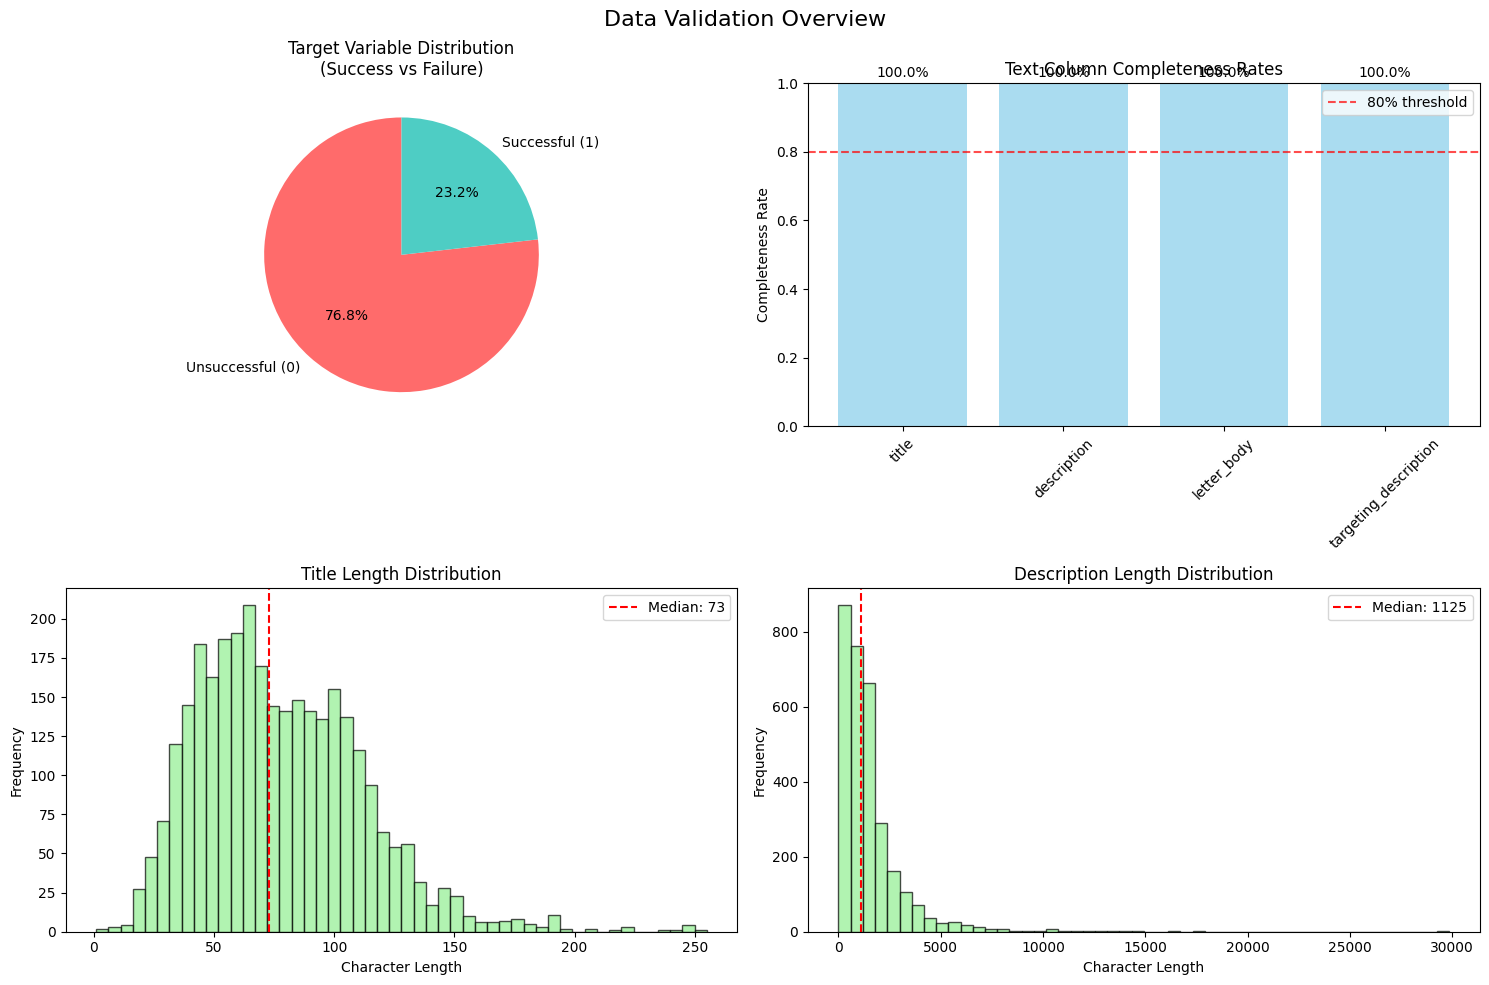

✓ Validation visualizations generated


In [ ]:
def create_validation_visualizations(df, target_validation, text_validation):
    """
    Create visualizations for data validation results.

    This function generates charts to visualize the validation results
    and provide a clear overview of data quality.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataset
    target_validation : dict
        Target variable validation results
    text_validation : dict
        Text column validation results
    """

    print("\n5. VALIDATION VISUALIZATIONS")
    print("-" * 30)

    # Set up the subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Data Validation Overview', fontsize=16, y=0.98)

    # 1. Target Variable Distribution
    if target_validation['target_variable_valid']:
        target_counts = df['target_success'].value_counts()
        labels = ['Unsuccessful (0)', 'Successful (1)']
        colors = ['#ff6b6b', '#4ecdc4']

        axes[0, 0].pie(target_counts.values, labels=labels, autopct='%1.1f%%',
                      colors=colors, startangle=90)
        axes[0, 0].set_title('Target Variable Distribution\n(Success vs Failure)')
    else:
        axes[0, 0].text(0.5, 0.5, 'Target Variable\nValidation Failed',
                       ha='center', va='center', transform=axes[0, 0].transAxes,
                       fontsize=12, color='red')
        axes[0, 0].set_title('Target Variable Distribution')

    # 2. Text Column Completeness
    if text_validation['text_columns_valid']:
        text_cols = list(text_validation['column_stats'].keys())
        completeness_rates = [text_validation['column_stats'][col]['completeness_rate']
                            for col in text_cols]

        bars = axes[0, 1].bar(text_cols, completeness_rates, color='skyblue', alpha=0.7)
        axes[0, 1].set_title('Text Column Completeness Rates')
        axes[0, 1].set_ylabel('Completeness Rate')
        axes[0, 1].set_ylim(0, 1)
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Add percentage labels on bars
        for bar, rate in zip(bars, completeness_rates):
            height = bar.get_height()
            axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{rate:.1%}', ha='center', va='bottom')

        # Add reference line at 80%
        axes[0, 1].axhline(y=0.8, color='red', linestyle='--', alpha=0.7,
                          label='80% threshold')
        axes[0, 1].legend()
    else:
        axes[0, 1].text(0.5, 0.5, 'Text Column\nValidation Failed',
                       ha='center', va='center', transform=axes[0, 1].transAxes,
                       fontsize=12, color='red')
        axes[0, 1].set_title('Text Column Completeness')

    # 3. Text Length Distributions
    if text_validation['text_columns_valid']:
        available_text_cols = [col for col in ['title', 'description'] if col in df.columns]

        for i, col in enumerate(available_text_cols[:2]):  # Show first 2 columns
            text_lengths = df[col].dropna().str.len()
            if len(text_lengths) > 0:
                axes[1, i].hist(text_lengths, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
                axes[1, i].set_title(f'{col.title()} Length Distribution')
                axes[1, i].set_xlabel('Character Length')
                axes[1, i].set_ylabel('Frequency')
                axes[1, i].axvline(text_lengths.median(), color='red', linestyle='--',
                                 label=f'Median: {text_lengths.median():.0f}')
                axes[1, i].legend()

    # If only one text column, hide the unused subplot
    if len([col for col in ['title', 'description'] if col in df.columns]) < 2:
        axes[1, 1].set_visible(False)

    plt.tight_layout()
    plt.show()

    print("✓ Validation visualizations generated")

# Create validation visualizations
create_validation_visualizations(df, target_validation, text_validation)

In [ ]:
def generate_validation_summary(df, column_validation, target_validation, text_validation):
    """
    Generate a comprehensive validation summary report.

    This function consolidates all validation results into a final
    summary report that determines whether the dataset is ready
    for analysis.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataset
    column_validation : dict
        Column validation results
    target_validation : dict
        Target variable validation results
    text_validation : dict
        Text column validation results

    Returns:
    --------
    dict: Final validation summary
    """

    print("\n6. VALIDATION SUMMARY")
    print("-" * 30)

    # Define the columns we will actually use for analysis
    # Based on client specifications - only use these specific columns
    analysis_columns = {
        'required': ['target_success', 'title', 'description'],
        'optional': ['letter_body', 'targeting_description', 'petition_ask',
                    'original_locale', 'has_location', 'petition_id']
    }

    # Identify columns present in dataset but not used for analysis
    all_dataset_columns = set(df.columns)
    all_analysis_columns = set(analysis_columns['required'] + analysis_columns['optional'])
    unused_columns = all_dataset_columns - all_analysis_columns

    # Identify which analysis columns are actually available
    available_analysis_columns = list(all_dataset_columns & all_analysis_columns)

    # Collect all validation results
    all_issues = []
    all_issues.extend(column_validation.get('issues', []))
    all_issues.extend(target_validation.get('issues', []))
    all_issues.extend(text_validation.get('issues', []))

    # Determine overall validation status
    critical_validations = [
        column_validation['required_columns_present'],
        target_validation['target_variable_valid'],
        text_validation['text_columns_valid']
    ]

    overall_valid = all(critical_validations)

    # Create summary report
    summary = {
        'overall_valid': overall_valid,
        'dataset_shape': df.shape,
        'total_records': len(df),
        'required_columns_present': column_validation['required_columns_present'],
        'target_variable_valid': target_validation['target_variable_valid'],
        'text_columns_valid': text_validation['text_columns_valid'],
        'available_analysis_columns': available_analysis_columns,
        'unused_columns': list(unused_columns),
        'success_rate': target_validation['class_distribution']['proportions'].get(1, 0) if target_validation['target_variable_valid'] else None,
        'all_issues': all_issues,
        'ready_for_analysis': overall_valid and len(df) >= config['min_records']
    }

    print(f"DATASET VALIDATION RESULTS:")
    print(f"{'='*50}")
    print(f"Overall Status: {'✓ PASSED' if overall_valid else '✗ FAILED'}")
    print(f"Dataset Shape: {df.shape}")
    print(f"Total Records: {len(df):,}")

    print(f"\nVALIDATION CHECKLIST:")
    print(f"✓ Required columns present: {column_validation['required_columns_present']}")
    print(f"✓ Target variable valid: {target_validation['target_variable_valid']}")
    print(f"✓ Text columns valid: {text_validation['text_columns_valid']}")
    print(f"✓ Sufficient records: {len(df) >= config['min_records']}")

    if summary['success_rate'] is not None:
        print(f"\nTARGET VARIABLE SUMMARY:")
        print(f"Success Rate: {summary['success_rate']:.1%}")
        print(f"Total Successful: {int(summary['success_rate'] * len(df)):,}")
        print(f"Total Unsuccessful: {int((1 - summary['success_rate']) * len(df)):,}")

    print(f"\nCOLUMN USAGE SUMMARY:")
    print(f"Columns available for analysis ({len(available_analysis_columns)}):")
    # Separate required and optional
    available_required = [col for col in analysis_columns['required'] if col in available_analysis_columns]
    available_optional = [col for col in analysis_columns['optional'] if col in available_analysis_columns]

    print(f"  Required columns ({len(available_required)}):")
    for col in available_required:
        print(f"    - {col}")

    if available_optional:
        print(f"  Optional columns ({len(available_optional)}):")
        for col in available_optional:
            print(f"    - {col}")

    if unused_columns:
        print(f"\nColumns in dataset but NOT used for analysis ({len(unused_columns)}):")
        for col in sorted(unused_columns):
            print(f"    - {col} (excluded per analysis scope)")

    if all_issues:
        print(f"\nISSUES IDENTIFIED:")
        for issue in all_issues:
            print(f"  ⚠ {issue}")

    if summary['ready_for_analysis']:
        print(f"\n{'='*50}")
        print(f"✓ DATASET READY FOR ANALYSIS")
        print(f"✓ Analysis will use {len(available_analysis_columns)} columns (excluding {len(unused_columns)} unused columns)")
        print(f"✓ Proceeding to Phase 2: Data Quality Assessment & EDA")
        print(f"{'='*50}")
    else:
        print(f"\n{'='*50}")
        print(f"✗ DATASET NOT READY FOR ANALYSIS")
        print(f"✗ Please resolve the issues above before proceeding")
        print(f"{'='*50}")

    return summary

# Generate final validation summary with corrected column handling
validation_summary = generate_validation_summary(df, column_validation, target_validation, text_validation)

# Store results for next phase - only keep the columns we will use for analysis
if validation_summary['ready_for_analysis']:
    # Filter dataframe to only include analysis columns (the ones you specified)
    analysis_columns_to_keep = validation_summary['available_analysis_columns']
    df_analysis = df[analysis_columns_to_keep].copy()

    print(f"\nPhase 1 completed successfully. Dataset validated and ready for EDA.")
    print(f"Analysis dataset shape: {df_analysis.shape}")
    print(f"Columns for analysis: {list(df_analysis.columns)}")

    if validation_summary['unused_columns']:
        print(f"Note: {len(validation_summary['unused_columns'])} columns excluded from analysis as per scope definition")

    # This filtered dataset (df_analysis) will be used in Phase 2
    print(f"\nReady to proceed to Phase 2: Data Quality Assessment & EDA")
    print(f"Phase 2 will include:")
    print(f"  - Data cleaning and preprocessing")
    print(f"  - Missing value analysis and handling")
    print(f"  - Exploratory data analysis")
    print(f"  - Text content quality assessment")
    print(f"  - Statistical summaries and distributions")

else:
    print(f"\nPhase 1 failed. Please resolve validation issues before proceeding.")
    df_analysis = None


6. VALIDATION SUMMARY
------------------------------
DATASET VALIDATION RESULTS:
Overall Status: ✓ PASSED
Dataset Shape: (3081, 10)
Total Records: 3,081

VALIDATION CHECKLIST:
✓ Required columns present: True
✓ Target variable valid: True
✓ Text columns valid: True
✓ Sufficient records: True

TARGET VARIABLE SUMMARY:
Success Rate: 23.2%
Total Successful: 715
Total Unsuccessful: 2,366

COLUMN USAGE SUMMARY:
Columns available for analysis (9):
  Required columns (3):
    - target_success
    - title
    - description
  Optional columns (6):
    - letter_body
    - targeting_description
    - petition_ask
    - original_locale
    - has_location
    - petition_id

Columns in dataset but NOT used for analysis (1):
    - created_at (excluded per analysis scope)

✓ DATASET READY FOR ANALYSIS
✓ Analysis will use 9 columns (excluding 1 unused columns)
✓ Proceeding to Phase 2: Data Quality Assessment & EDA

Phase 1 completed successfully. Dataset validated and ready for EDA.
Analysis dataset s

# PHASE 2 - DATA QUALITY ASSESSMENT & EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import warnings
warnings.filterwarnings('ignore')

def assess_data_quality(df):
    """
    Perform comprehensive data quality assessment.

    This function analyzes data completeness, consistency, and identifies
    potential quality issues that need to be addressed before analysis.

    Parameters:
    -----------
    df : pandas.DataFrame
        Filtered dataset containing only analysis columns

    Returns:
    --------
    dict: Data quality assessment results
    """

    print("="*60)
    print("PHASE 2: DATA QUALITY ASSESSMENT & EDA")
    print("="*60)

    print("\n1. DATA QUALITY ASSESSMENT")
    print("-" * 30)

    quality_results = {
        'dataset_overview': {},
        'missing_data': {},
        'duplicate_analysis': {},
        'data_types': {},
        'quality_issues': []
    }

    # Dataset overview
    print(f"Dataset Overview:")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    quality_results['dataset_overview'] = {
        'rows': df.shape[0],
        'columns': df.shape[1],
        'memory_mb': df.memory_usage(deep=True).sum() / 1024**2
    }

    # Missing data analysis
    print(f"\nMissing Data Analysis:")
    missing_counts = df.isnull().sum()
    missing_percentages = (missing_counts / len(df)) * 100

    missing_summary = pd.DataFrame({
        'Column': missing_counts.index,
        'Missing_Count': missing_counts.values,
        'Missing_Percentage': missing_percentages.values
    }).sort_values('Missing_Percentage', ascending=False)

    print(missing_summary.to_string(index=False))

    # Identify problematic missing data
    high_missing = missing_summary[missing_summary['Missing_Percentage'] > 30]
    moderate_missing = missing_summary[(missing_summary['Missing_Percentage'] > 5) &
                                     (missing_summary['Missing_Percentage'] <= 30)]

    if len(high_missing) > 0:
        quality_results['quality_issues'].append(f"High missing data: {list(high_missing['Column'])}")
        print(f"\n⚠ High missing data (>30%): {list(high_missing['Column'])}")

    if len(moderate_missing) > 0:
        print(f"⚠ Moderate missing data (5-30%): {list(moderate_missing['Column'])}")

    quality_results['missing_data'] = missing_summary.to_dict('records')

    # Duplicate analysis
    print(f"\nDuplicate Analysis:")
    total_duplicates = df.duplicated().sum()
    print(f"Complete duplicate rows: {total_duplicates:,} ({total_duplicates/len(df):.1%})")

    # Check for duplicate titles (common in petition data)
    if 'title' in df.columns:
        title_duplicates = df['title'].duplicated().sum()
        print(f"Duplicate titles: {title_duplicates:,} ({title_duplicates/len(df):.1%})")
        quality_results['duplicate_analysis']['title_duplicates'] = title_duplicates

    quality_results['duplicate_analysis']['complete_duplicates'] = total_duplicates

    # Data type analysis
    print(f"\nData Types:")
    dtype_summary = df.dtypes.value_counts()
    print(dtype_summary)
    quality_results['data_types'] = dtype_summary.to_dict()

    return quality_results

# Perform data quality assessment
quality_results = assess_data_quality(df_analysis)

PHASE 2: DATA QUALITY ASSESSMENT & EDA

1. DATA QUALITY ASSESSMENT
------------------------------
Dataset Overview:
Shape: (3081, 9)
Memory usage: 9.10 MB

Missing Data Analysis:
               Column  Missing_Count  Missing_Percentage
          letter_body              0                 0.0
       target_success              0                 0.0
      original_locale              0                 0.0
                title              0                 0.0
          description              0                 0.0
targeting_description              0                 0.0
         has_location              0                 0.0
          petition_id              0                 0.0
         petition_ask              0                 0.0

Duplicate Analysis:
Complete duplicate rows: 0 (0.0%)
Duplicate titles: 2 (0.1%)

Data Types:
object    6
int64     2
bool      1
Name: count, dtype: int64


In [ ]:
def analyze_text_content_quality(df):
    """
    Analyze the quality and characteristics of text content.

    This function examines text columns for content quality,
    length distributions, and potential issues that could
    affect feature engineering.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset with text columns

    Returns:
    --------
    dict: Text content quality analysis results
    """

    print("\n2. TEXT CONTENT QUALITY ANALYSIS")
    print("-" * 30)

    text_columns = ['title', 'description', 'letter_body', 'targeting_description']
    available_text_cols = [col for col in text_columns if col in df.columns]

    text_quality = {}

    for col in available_text_cols:
        print(f"\n{col.upper()} Analysis:")

        # Get non-null text data
        text_data = df[col].dropna()

        if len(text_data) == 0:
            print(f"  No data available for analysis")
            continue

        # Calculate text statistics
        text_lengths = text_data.str.len()
        word_counts = text_data.str.split().str.len()

        # Check for empty or very short content
        empty_or_very_short = (text_lengths <= 10).sum()

        # Check for extremely long content (potential data quality issues)
        very_long = (text_lengths > text_lengths.quantile(0.99)).sum()

        # Basic content quality checks
        has_html = text_data.str.contains('<[^<]+?>', regex=True, na=False).sum()
        has_urls = text_data.str.contains(r'http[s]?://', regex=True, na=False).sum()
        has_email = text_data.str.contains(r'\S+@\S+', regex=True, na=False).sum()

        # Statistics summary
        stats = {
            'total_records': len(text_data),
            'length_stats': {
                'mean': text_lengths.mean(),
                'median': text_lengths.median(),
                'std': text_lengths.std(),
                'min': text_lengths.min(),
                'max': text_lengths.max(),
                'q25': text_lengths.quantile(0.25),
                'q75': text_lengths.quantile(0.75)
            },
            'word_count_stats': {
                'mean': word_counts.mean(),
                'median': word_counts.median(),
                'min': word_counts.min(),
                'max': word_counts.max()
            },
            'quality_flags': {
                'empty_or_very_short': empty_or_very_short,
                'very_long_content': very_long,
                'contains_html': has_html,
                'contains_urls': has_urls,
                'contains_email': has_email
            }
        }

        text_quality[col] = stats

        # Print summary
        print(f"  Records: {len(text_data):,}")
        print(f"  Length: mean={stats['length_stats']['mean']:.0f}, "
              f"median={stats['length_stats']['median']:.0f}, "
              f"range=[{stats['length_stats']['min']}-{stats['length_stats']['max']}]")
        print(f"  Words: mean={stats['word_count_stats']['mean']:.0f}, "
              f"median={stats['word_count_stats']['median']:.0f}")

        # Quality flags
        if empty_or_very_short > 0:
            print(f"  ⚠ Empty/very short content: {empty_or_very_short:,} records")
        if very_long > 0:
            print(f"  ⚠ Extremely long content: {very_long:,} records")
        if has_html > 0:
            print(f"  📝 Contains HTML formatting: {has_html:,} records")
        if has_urls > 0:
            print(f"  🔗 Contains URLs: {has_urls:,} records")

    return text_quality

# Analyze text content quality
text_quality_results = analyze_text_content_quality(df_analysis)


2. TEXT CONTENT QUALITY ANALYSIS
------------------------------

TITLE Analysis:
  Records: 3,081
  Length: mean=78, median=73, range=[1-255]
  Words: mean=12, median=11
  ⚠ Empty/very short content: 4 records
  ⚠ Extremely long content: 31 records

DESCRIPTION Analysis:
  Records: 3,081
  Length: mean=1515, median=1125, range=[8-29844]
  Words: mean=238, median=180
  ⚠ Empty/very short content: 3 records
  ⚠ Extremely long content: 31 records
  📝 Contains HTML formatting: 3,080 records
  🔗 Contains URLs: 308 records

LETTER_BODY Analysis:
  Records: 3,081
  Length: mean=160, median=51, range=[1-12298]
  Words: mean=26, median=8
  ⚠ Empty/very short content: 28 records
  ⚠ Extremely long content: 31 records
  📝 Contains HTML formatting: 22 records
  🔗 Contains URLs: 22 records

TARGETING_DESCRIPTION Analysis:
  Records: 3,081
  Length: mean=55, median=38, range=[1-200]
  Words: mean=8, median=6
  ⚠ Empty/very short content: 325 records


In [ ]:
def perform_target_variable_eda(df):
    """
    Perform exploratory data analysis on the target variable.

    This function analyzes the distribution and characteristics
    of the target variable in relation to other available features.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset with target_success column

    Returns:
    --------
    dict: Target variable EDA results
    """

    print("\n3. TARGET VARIABLE EXPLORATORY ANALYSIS")
    print("-" * 30)

    target_col = 'target_success'

    # Basic target distribution
    target_dist = df[target_col].value_counts().sort_index()
    target_props = df[target_col].value_counts(normalize=True).sort_index()

    print(f"Target Variable Distribution:")
    print(f"Unsuccessful (0): {target_dist.get(0, 0):,} ({target_props.get(0, 0):.1%})")
    print(f"Successful (1): {target_dist.get(1, 0):,} ({target_props.get(1, 0):.1%})")

    target_eda = {
        'distribution': target_dist.to_dict(),
        'proportions': target_props.to_dict(),
        'categorical_analysis': {},
        'text_length_analysis': {}
    }

    # Analyze categorical variables against target
    categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
    categorical_cols = [col for col in categorical_cols if col != target_col]

    if len(categorical_cols) > 0:
        print(f"\nCategorical Variable Analysis vs Target:")

        for col in categorical_cols:
            if df[col].nunique() <= 10:  # Only analyze if reasonable number of categories
                crosstab = pd.crosstab(df[col], df[target_col], normalize='index')
                success_rates = crosstab[1] if 1 in crosstab.columns else pd.Series()

                print(f"\n{col.upper()}:")
                for category in df[col].unique():
                    if pd.notna(category):
                        count = df[df[col] == category].shape[0]
                        success_rate = success_rates.get(category, 0)
                        print(f"  {category}: {count:,} records ({success_rate:.1%} success rate)")

                target_eda['categorical_analysis'][col] = success_rates.to_dict()

    # Analyze text length vs target
    text_cols = ['title', 'description', 'letter_body', 'targeting_description']
    available_text = [col for col in text_cols if col in df.columns]

    if len(available_text) > 0:
        print(f"\nText Length Analysis vs Target:")

        for col in available_text:
            # Calculate text lengths
            df[f'{col}_length'] = df[col].fillna('').str.len()

            # Compare lengths between successful and unsuccessful
            unsuccessful_lengths = df[df[target_col] == 0][f'{col}_length']
            successful_lengths = df[df[target_col] == 1][f'{col}_length']

            # Statistical test
            if len(unsuccessful_lengths) > 0 and len(successful_lengths) > 0:
                stat, p_value = stats.mannwhitneyu(unsuccessful_lengths, successful_lengths,
                                                 alternative='two-sided')

                print(f"\n{col.upper()}:")
                print(f"  Unsuccessful median length: {unsuccessful_lengths.median():.0f}")
                print(f"  Successful median length: {successful_lengths.median():.0f}")
                print(f"  Statistical significance: p = {p_value:.4f}")

                target_eda['text_length_analysis'][col] = {
                    'unsuccessful_median': unsuccessful_lengths.median(),
                    'successful_median': successful_lengths.median(),
                    'p_value': p_value,
                    'significant': p_value < 0.05
                }

    return target_eda

# Perform target variable EDA
target_eda_results = perform_target_variable_eda(df_analysis)


3. TARGET VARIABLE EXPLORATORY ANALYSIS
------------------------------
Target Variable Distribution:
Unsuccessful (0): 2,366 (76.8%)
Successful (1): 715 (23.2%)

Categorical Variable Analysis vs Target:

ORIGINAL_LOCALE:
  en-IN: 3,026 records (22.8% success rate)
  en-US: 24 records (33.3% success rate)
  ja-JP: 10 records (100.0% success rate)
  de-DE: 8 records (50.0% success rate)
  it-IT: 2 records (50.0% success rate)
  en-CA: 10 records (10.0% success rate)
  en-GB: 1 records (0.0% success rate)

HAS_LOCATION:
  True: 2,767 records (22.2% success rate)
  False: 314 records (31.8% success rate)

Text Length Analysis vs Target:

TITLE:
  Unsuccessful median length: 70
  Successful median length: 83
  Statistical significance: p = 0.0000

DESCRIPTION:
  Unsuccessful median length: 964
  Successful median length: 1631
  Statistical significance: p = 0.0000

LETTER_BODY:
  Unsuccessful median length: 48
  Successful median length: 66
  Statistical significance: p = 0.0000

TARGETING


4. EDA VISUALIZATIONS
------------------------------


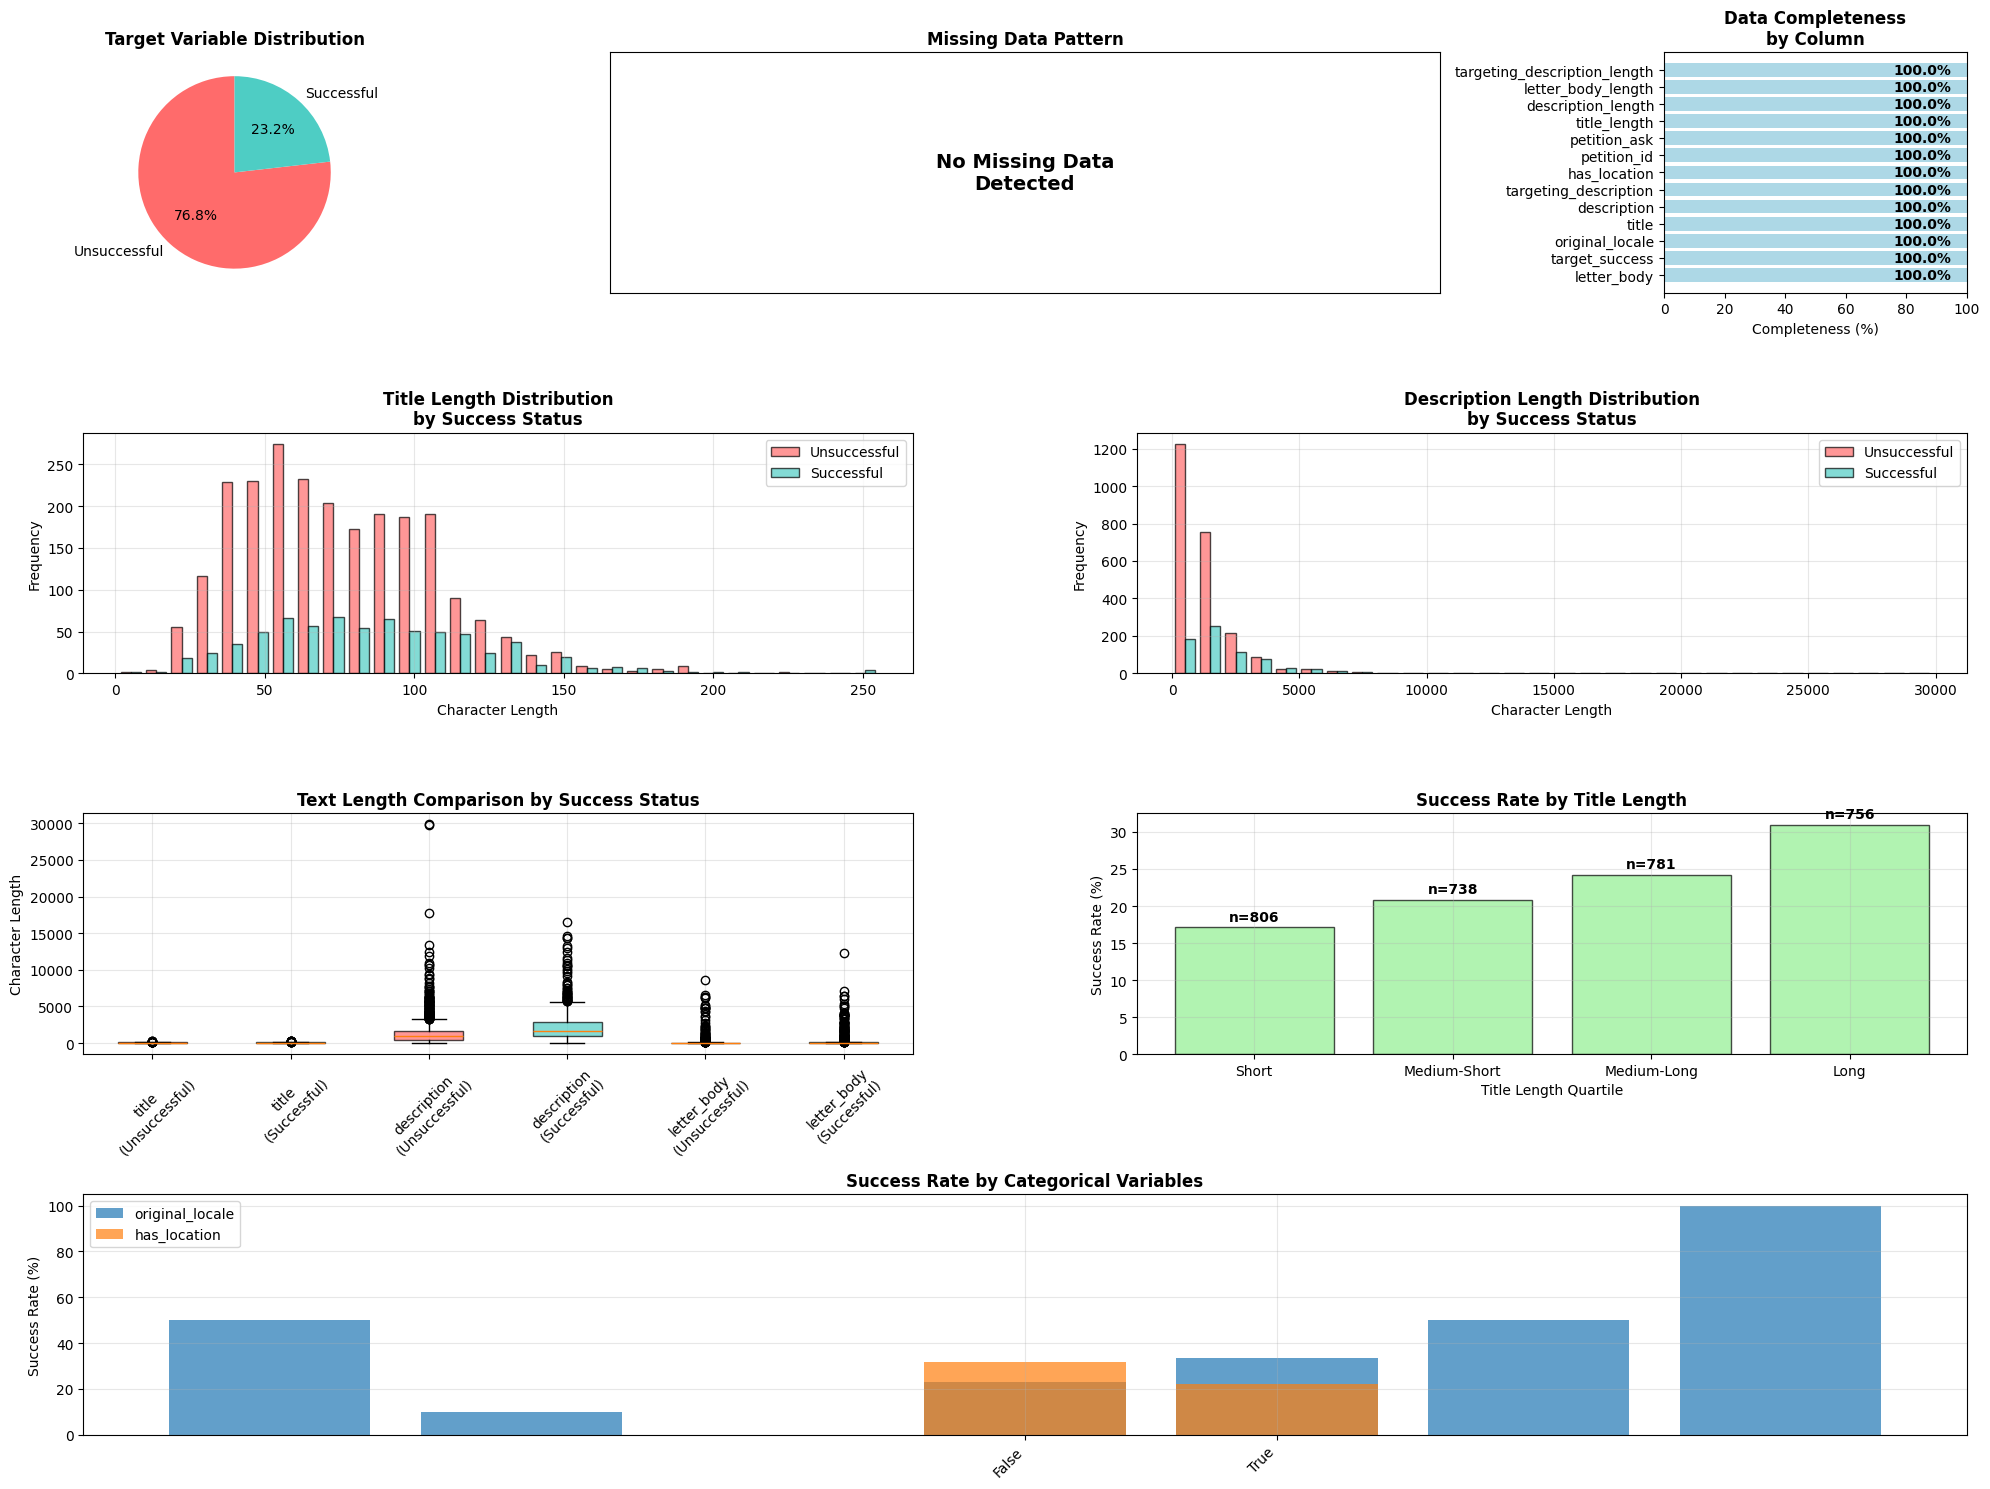

✓ EDA visualizations generated


In [ ]:
def create_eda_visualizations(df, text_quality_results, target_eda_results):
    """
    Create comprehensive visualizations for exploratory data analysis.

    This function generates multiple visualization panels to provide
    insights into data quality, distributions, and relationships.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset for analysis
    text_quality_results : dict
        Text quality analysis results
    target_eda_results : dict
        Target variable EDA results
    """

    print("\n4. EDA VISUALIZATIONS")
    print("-" * 30)

    # Set up the visualization layout
    fig = plt.figure(figsize=(20, 15))

    # Create a complex subplot layout
    gs = fig.add_gridspec(4, 4, height_ratios=[1, 1, 1, 1], width_ratios=[1, 1, 1, 1])

    # 1. Target Variable Distribution (Pie Chart)
    ax1 = fig.add_subplot(gs[0, 0])
    target_counts = df['target_success'].value_counts()
    colors = ['#ff6b6b', '#4ecdc4']
    labels = ['Unsuccessful', 'Successful']
    ax1.pie(target_counts.values, labels=labels, autopct='%1.1f%%',
           colors=colors, startangle=90)
    ax1.set_title('Target Variable Distribution', fontweight='bold')

    # 2. Missing Data Heatmap
    ax2 = fig.add_subplot(gs[0, 1:3])
    missing_data = df.isnull()
    if missing_data.any().any():
        sns.heatmap(missing_data.T, cbar=True, ax=ax2, cmap='Reds',
                   yticklabels=True, xticklabels=False)
        ax2.set_title('Missing Data Pattern', fontweight='bold')
        ax2.set_ylabel('Columns')
    else:
        ax2.text(0.5, 0.5, 'No Missing Data\nDetected', ha='center', va='center',
                transform=ax2.transAxes, fontsize=14, fontweight='bold')
        ax2.set_title('Missing Data Pattern', fontweight='bold')
        ax2.set_xticks([])
        ax2.set_yticks([])

    # 3. Data Completeness by Column
    ax3 = fig.add_subplot(gs[0, 3])
    completeness = (1 - df.isnull().mean()) * 100
    bars = ax3.barh(completeness.index, completeness.values, color='lightblue')
    ax3.set_xlabel('Completeness (%)')
    ax3.set_title('Data Completeness\nby Column', fontweight='bold')
    ax3.set_xlim(0, 100)

    # Add percentage labels
    for bar, pct in zip(bars, completeness.values):
        ax3.text(bar.get_width() - 5, bar.get_y() + bar.get_height()/2,
                f'{pct:.1f}%', ha='right', va='center', fontweight='bold')

    # 4. Text Length Distributions
    text_cols = [col for col in ['title', 'description', 'letter_body', 'targeting_description']
                if col in df.columns]

    for i, col in enumerate(text_cols[:2]):  # Show first 2 text columns
        ax = fig.add_subplot(gs[1, i*2:(i+1)*2])

        # Calculate text lengths
        text_lengths = df[col].fillna('').str.len()

        # Create histogram with success/failure breakdown
        unsuccessful_lengths = df[df['target_success'] == 0][col].fillna('').str.len()
        successful_lengths = df[df['target_success'] == 1][col].fillna('').str.len()

        ax.hist([unsuccessful_lengths, successful_lengths],
               bins=30, alpha=0.7, label=['Unsuccessful', 'Successful'],
               color=['#ff6b6b', '#4ecdc4'], edgecolor='black')

        ax.set_xlabel('Character Length')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{col.title()} Length Distribution\nby Success Status', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # 5. Text Length vs Success (Box plots)
    if len(text_cols) >= 2:
        ax5 = fig.add_subplot(gs[2, :2])

        # Prepare data for box plot
        plot_data = []
        plot_labels = []

        for col in text_cols[:3]:  # Up to 3 columns
            unsuccessful_lengths = df[df['target_success'] == 0][col].fillna('').str.len()
            successful_lengths = df[df['target_success'] == 1][col].fillna('').str.len()

            plot_data.extend([unsuccessful_lengths, successful_lengths])
            plot_labels.extend([f'{col}\n(Unsuccessful)', f'{col}\n(Successful)'])

        box_plot = ax5.boxplot(plot_data, labels=plot_labels, patch_artist=True)

        # Color boxes alternately
        colors = ['#ff6b6b', '#4ecdc4'] * len(text_cols)
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax5.set_ylabel('Character Length')
        ax5.set_title('Text Length Comparison by Success Status', fontweight='bold')
        ax5.tick_params(axis='x', rotation=45)
        ax5.grid(True, alpha=0.3)

    # 6. Success Rate by Text Length Quartiles
    ax6 = fig.add_subplot(gs[2, 2:])

    if 'title' in df.columns:
        # Create title length quartiles
        df['title_length'] = df['title'].fillna('').str.len()
        df['title_length_quartile'] = pd.qcut(df['title_length'], q=4,
                                            labels=['Short', 'Medium-Short', 'Medium-Long', 'Long'])

        # Calculate success rates by quartile
        success_by_quartile = df.groupby('title_length_quartile')['target_success'].agg(['count', 'mean'])

        bars = ax6.bar(success_by_quartile.index, success_by_quartile['mean'] * 100,
                      color='lightgreen', alpha=0.7, edgecolor='black')

        # Add count labels on bars
        for bar, count in zip(bars, success_by_quartile['count']):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'n={count}', ha='center', va='bottom', fontweight='bold')

        ax6.set_ylabel('Success Rate (%)')
        ax6.set_xlabel('Title Length Quartile')
        ax6.set_title('Success Rate by Title Length', fontweight='bold')
        ax6.grid(True, alpha=0.3)

    # 7. Categorical Variables Analysis (if available)
    categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
    categorical_cols = [col for col in categorical_cols if col != 'target_success' and df[col].nunique() <= 8]

    if len(categorical_cols) > 0:
        ax7 = fig.add_subplot(gs[3, :])

        # Create subplot for categorical analysis
        n_cats = min(len(categorical_cols), 3)  # Show up to 3 categorical variables

        for i, col in enumerate(categorical_cols[:n_cats]):
            # Calculate success rates by category
            success_rates = df.groupby(col)['target_success'].agg(['count', 'mean'])

            # Create positions for this categorical variable
            positions = np.arange(len(success_rates)) + i * (len(success_rates) + 1)

            bars = ax7.bar(positions, success_rates['mean'] * 100,
                          label=col, alpha=0.7)

            # Add category labels
            ax7.set_xticks(positions)
            ax7.set_xticklabels(success_rates.index, rotation=45, ha='right')

        ax7.set_ylabel('Success Rate (%)')
        ax7.set_title('Success Rate by Categorical Variables', fontweight='bold')
        ax7.legend()
        ax7.grid(True, alpha=0.3)
    else:
        # If no categorical variables, show data quality summary
        ax7 = fig.add_subplot(gs[3, :])
        ax7.text(0.5, 0.5, 'Data Quality Summary:\n\n' +
                f'Total Records: {len(df):,}\n' +
                f'Success Rate: {df["target_success"].mean():.1%}\n' +
                f'Text Columns: {len([col for col in text_cols if col in df.columns])}\n' +
                f'Missing Data: {df.isnull().sum().sum()} values',
                ha='center', va='center', transform=ax7.transAxes,
                fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        ax7.set_title('Dataset Summary', fontweight='bold')
        ax7.set_xticks([])
        ax7.set_yticks([])

    plt.tight_layout()
    plt.show()

    print("✓ EDA visualizations generated")

# Create EDA visualizations
create_eda_visualizations(df_analysis, text_quality_results, target_eda_results)

## Data Preprocessing

In [ ]:
def perform_data_preprocessing(df):
    """
    Perform data cleaning and preprocessing steps.

    This function handles missing values, data type conversions,
    and basic cleaning operations to prepare data for feature engineering.

    Parameters:
    -----------
    df : pandas.DataFrame
        Raw dataset after validation

    Returns:
    --------
    tuple: (cleaned_dataframe, preprocessing_log)
    """

    print("\n5. DATA PREPROCESSING")
    print("-" * 30)

    # Create a copy for preprocessing
    df_clean = df.copy()
    preprocessing_log = {
        'original_shape': df.shape,
        'steps_performed': [],
        'missing_data_handling': {},
        'data_type_conversions': {},
        'final_shape': None
    }

    print(f"Starting preprocessing with {df.shape[0]:,} records and {df.shape[1]} columns")

    # Step 1: Handle missing values
    print(f"\nStep 1: Missing Value Treatment")

    missing_before = df_clean.isnull().sum()

    # Text columns: fill missing with empty string
    text_columns = ['title', 'description', 'letter_body', 'targeting_description', 'petition_ask']
    for col in text_columns:
        if col in df_clean.columns:
            missing_count = df_clean[col].isnull().sum()
            if missing_count > 0:
                df_clean[col] = df_clean[col].fillna('')
                print(f"  {col}: Filled {missing_count:,} missing values with empty string")
                preprocessing_log['missing_data_handling'][col] = f"Filled {missing_count} missing values"
            else:
                print(f"  {col}: No missing values")

    # Boolean columns: fill missing with False (assuming not present = False)
    bool_columns = ['has_location']
    for col in bool_columns:
        if col in df_clean.columns:
            missing_count = df_clean[col].isnull().sum()
            if missing_count > 0:
                df_clean[col] = df_clean[col].fillna(False)
                print(f"  {col}: Filled {missing_count:,} missing values with False")
                preprocessing_log['missing_data_handling'][col] = f"Filled {missing_count} missing values with False"

    # Categorical columns: fill missing with 'Unknown'
    categorical_columns = ['original_locale']
    for col in categorical_columns:
        if col in df_clean.columns:
            missing_count = df_clean[col].isnull().sum()
            if missing_count > 0:
                df_clean[col] = df_clean[col].fillna('Unknown')
                print(f"  {col}: Filled {missing_count:,} missing values with 'Unknown'")
                preprocessing_log['missing_data_handling'][col] = f"Filled {missing_count} missing values with 'Unknown'"

    preprocessing_log['steps_performed'].append("Missing value treatment")

    # Step 2: Data type optimization
    print(f"\nStep 2: Data Type Optimization")

    # Ensure target variable is integer
    if 'target_success' in df_clean.columns:
        original_type = df_clean['target_success'].dtype
        df_clean['target_success'] = df_clean['target_success'].astype(int)
        print(f"  target_success: {original_type} → int")
        preprocessing_log['data_type_conversions']['target_success'] = f"{original_type} → int"

    # Convert boolean columns to proper boolean type
    for col in bool_columns:
        if col in df_clean.columns:
            original_type = df_clean[col].dtype
            df_clean[col] = df_clean[col].astype(bool)
            print(f"  {col}: {original_type} → bool")
            preprocessing_log['data_type_conversions'][col] = f"{original_type} → bool"

    preprocessing_log['steps_performed'].append("Data type optimization")

    # Step 3: Text cleaning
    print(f"\nStep 3: Basic Text Cleaning")

    for col in text_columns:
        if col in df_clean.columns:
            # Remove extra whitespace
            df_clean[col] = df_clean[col].str.strip()

            # Convert to lowercase for consistency (we'll preserve original for some analyses)
            df_clean[f'{col}_clean'] = df_clean[col].str.lower()

            print(f"  {col}: Created cleaned version ({col}_clean)")

    preprocessing_log['steps_performed'].append("Basic text cleaning")

    # Step 4: Remove duplicates
    print(f"\nStep 4: Duplicate Removal")

    duplicates_before = df_clean.duplicated().sum()
    df_clean = df_clean.drop_duplicates()
    duplicates_removed = duplicates_before - df_clean.duplicated().sum()

    print(f"  Removed {duplicates_removed:,} duplicate records")
    preprocessing_log['steps_performed'].append(f"Removed {duplicates_removed} duplicates")

    # Step 5: Final data quality check
    print(f"\nStep 5: Final Data Quality Check")

    missing_after = df_clean.isnull().sum()
    total_missing_after = missing_after.sum()

    print(f"  Missing values remaining: {total_missing_after}")
    print(f"  Final dataset shape: {df_clean.shape}")

    preprocessing_log['final_shape'] = df_clean.shape

    # Create preprocessing summary
    print(f"\nPREPROCESSING SUMMARY:")
    print(f"{'='*40}")
    print(f"Original shape: {preprocessing_log['original_shape']}")
    print(f"Final shape: {preprocessing_log['final_shape']}")
    print(f"Records removed: {preprocessing_log['original_shape'][0] - preprocessing_log['final_shape'][0]:,}")
    print(f"Steps performed: {len(preprocessing_log['steps_performed'])}")

    for step in preprocessing_log['steps_performed']:
        print(f"  ✓ {step}")

    print(f"\n✓ Data preprocessing completed successfully")

    return df_clean, preprocessing_log

# Perform data preprocessing
df_clean, preprocessing_log = perform_data_preprocessing(df_analysis)

print(f"\nPhase 2 completed successfully.")
print(f"Clean dataset ready for feature engineering: {df_clean.shape}")
print(f"Proceeding to Phase 3: Text Processing & Feature Engineering")


5. DATA PREPROCESSING
------------------------------
Starting preprocessing with 3,081 records and 14 columns

Step 1: Missing Value Treatment
  title: No missing values
  description: No missing values
  letter_body: No missing values
  targeting_description: No missing values
  petition_ask: No missing values

Step 2: Data Type Optimization
  target_success: int64 → int
  has_location: bool → bool

Step 3: Basic Text Cleaning
  title: Created cleaned version (title_clean)
  description: Created cleaned version (description_clean)
  letter_body: Created cleaned version (letter_body_clean)
  targeting_description: Created cleaned version (targeting_description_clean)
  petition_ask: Created cleaned version (petition_ask_clean)

Step 4: Duplicate Removal
  Removed 0 duplicate records

Step 5: Final Data Quality Check
  Missing values remaining: 0
  Final dataset shape: (3081, 19)

PREPROCESSING SUMMARY:
Original shape: (3081, 14)
Final shape: (3081, 19)
Records removed: 0
Steps perform

# PHASE 3 - TEXT ANALYSIS

In [ ]:


# ============================================================================
# PART 7: TEXT DATA PREPARATION
# ============================================================================

print("\n" + "="*60)
print("TEXT ANALYTICS & MESSAGING PATTERN DISCOVERY")
print("="*60)

# Verify text columns exist and examine content
text_columns = ['title', 'description', 'letter_body', 'targeting_description']
available_text_cols = [col for col in text_columns if col in df.columns]
print(f"Available text columns: {available_text_cols}")
print(f"Total petitions for text analysis: {len(df):,}")

# Basic text data quality check
for col in available_text_cols:
    non_null_count = df[col].notna().sum()
    avg_length = df[col].str.len().mean()
    print(f"{col}: {non_null_count:,} non-null ({non_null_count/len(df):.1%}), avg length: {avg_length:.0f} chars")

# Sample successful vs unsuccessful titles for initial inspection
if 'target_success' in df.columns and 'title' in available_text_cols:
    print(f"\nSAMPLE SUCCESSFUL PETITION TITLES:")
    print("-" * 40)
    successful_sample = df[df['target_success'] == 1]['title'].sample(min(5, len(df[df['target_success'] == 1])), random_state=42)
    for i, title in enumerate(successful_sample, 1):
        print(f"{i}. {title[:100]}...")

    print(f"\nSAMPLE UNSUCCESSFUL PETITION TITLES:")
    print("-" * 40)
    unsuccessful_sample = df[df['target_success'] == 0]['title'].sample(min(5, len(df[df['target_success'] == 0])), random_state=42)
    for i, title in enumerate(unsuccessful_sample, 1):
        print(f"{i}. {title[:100]}...")

# ============================================================================
# PART 8: ENHANCED TEXT PREPROCESSING FUNCTIONS
# ============================================================================

# Define comprehensive text analysis functions
def clean_html(text):
    """Remove HTML tags and clean text for analysis"""
    if pd.isna(text):
        return ""
    # Remove HTML tags
    clean = re.sub('<.*?>', '', str(text))
    # Remove extra whitespace
    clean = ' '.join(clean.split())
    return clean

def count_html_tags(text):
    """Count HTML formatting tags in text"""
    if pd.isna(text):
        return 0
    return len(re.findall('<.*?>', str(text)))

def safe_sent_tokenize(text):
    """Safe sentence tokenization with fallback"""
    try:
        return sent_tokenize(text)
    except:
        # Fallback: split on common sentence endings
        sentences = re.split(r'[.!?]+', text)
        return [s.strip() for s in sentences if s.strip()]

def safe_word_tokenize(text):
    """Safe word tokenization with fallback"""
    try:
        return word_tokenize(text)
    except:
        # Fallback: simple split
        return text.split()

def calculate_advanced_readability(text):
    """Calculate comprehensive readability and text quality metrics"""
    if pd.isna(text) or len(str(text).strip()) < 10:
        return {
            'flesch_ease': 0, 'flesch_kincaid': 0, 'gunning_fog': 0,
            'automated_readability': 0, 'avg_sentence_length': 0,
            'avg_word_length': 0, 'vocab_diversity': 0, 'caps_ratio': 0
        }

    clean_text = clean_html(text)

    try:
        # Basic readability scores
        flesch_ease = flesch_reading_ease(clean_text)
        flesch_kincaid = flesch_kincaid_grade(clean_text)

        # Additional readability metrics
        gunning_fog_score = gunning_fog(clean_text)
        automated_readability = automated_readability_index(clean_text)

    except:
        flesch_ease = flesch_kincaid = gunning_fog_score = automated_readability = 0

    # Text structure analysis
    try:
        sentences = safe_sent_tokenize(clean_text)
        words = safe_word_tokenize(clean_text)

        avg_sentence_length = len(words) / len(sentences) if sentences else 0
        avg_word_length = sum(len(word) for word in words) / len(words) if words else 0

        # Vocabulary diversity
        unique_words = set(word.lower() for word in words if word.isalpha())
        vocab_diversity = len(unique_words) / len(words) if words else 0

        # Capitalization analysis (shouting detection)
        caps_words = sum(1 for word in words if word.isupper() and len(word) > 1)
        caps_ratio = caps_words / len(words) if words else 0

    except:
        avg_sentence_length = avg_word_length = vocab_diversity = caps_ratio = 0

    return {
        'flesch_ease': flesch_ease,
        'flesch_kincaid': flesch_kincaid,
        'gunning_fog': gunning_fog_score,
        'automated_readability': automated_readability,
        'avg_sentence_length': avg_sentence_length,
        'avg_word_length': avg_word_length,
        'vocab_diversity': vocab_diversity,
        'caps_ratio': caps_ratio
    }

def count_keywords(text, keywords):
    """Count keyword occurrences in text"""
    if pd.isna(text):
        return 0
    clean_text = clean_html(text).lower()
    count = 0
    for keyword in keywords:
        count += clean_text.count(keyword.lower())
    return count

print("Text preprocessing functions defined successfully")




TEXT ANALYTICS & MESSAGING PATTERN DISCOVERY
Available text columns: ['title', 'description', 'letter_body', 'targeting_description']
Total petitions for text analysis: 3,081
title: 3,081 non-null (100.0%), avg length: 78 chars
description: 3,081 non-null (100.0%), avg length: 1515 chars
letter_body: 3,081 non-null (100.0%), avg length: 160 chars
targeting_description: 3,081 non-null (100.0%), avg length: 55 chars

SAMPLE SUCCESSFUL PETITION TITLES:
----------------------------------------
1. MANDATORY INSTALLATION OF OXYGEN PLANT IN ALL HOSPITALS ABOVE 50 BEDS...
2. Ravi Shankar Prasad : Death Penalty for Rapist within a month...
3. Clean Up Bengaluru @Yediyurappa...
4. PM office: Stop defaming Ayurveda surgeons that they less qualified and untrained...
5. Arvind Kejriwal: Cap Covid 19 treatment charges in Delhi private hospitals...

SAMPLE UNSUCCESSFUL PETITION TITLES:
----------------------------------------
1. Ministry of civil aviation, India. : Sequential deboarding on domestic 

## CONTENT LENGTH & STRUCTURE ANALYSIS


CONTENT STRUCTURE & LENGTH ANALYSIS
CONTENT LENGTH ANALYSIS:
----------------------------------------

TITLE:
 Successful median length: 83 characters
 Unsuccessful median length: 70 characters
 Success advantage: 1.19x
 Successful mean words: 13
 Unsuccessful mean words: 12

DESCRIPTION:
 Successful median length: 1511 characters
 Unsuccessful median length: 914 characters
 Success advantage: 1.65x
 Successful mean words: 339
 Unsuccessful mean words: 203

LETTER_BODY:
 Successful median length: 66 characters
 Unsuccessful median length: 48 characters
 Success advantage: 1.38x
 Successful mean words: 55
 Unsuccessful mean words: 17

TARGETING_DESCRIPTION:
 Successful median length: 51 characters
 Unsuccessful median length: 35 characters
 Success advantage: 1.46x
 Successful mean words: 9
 Unsuccessful mean words: 7

HTML FORMATTING ANALYSIS:
----------------------------------------
Successful petitions - avg HTML tags: 28.8
Unsuccessful petitions - avg HTML tags: 14.2
HTML formattin

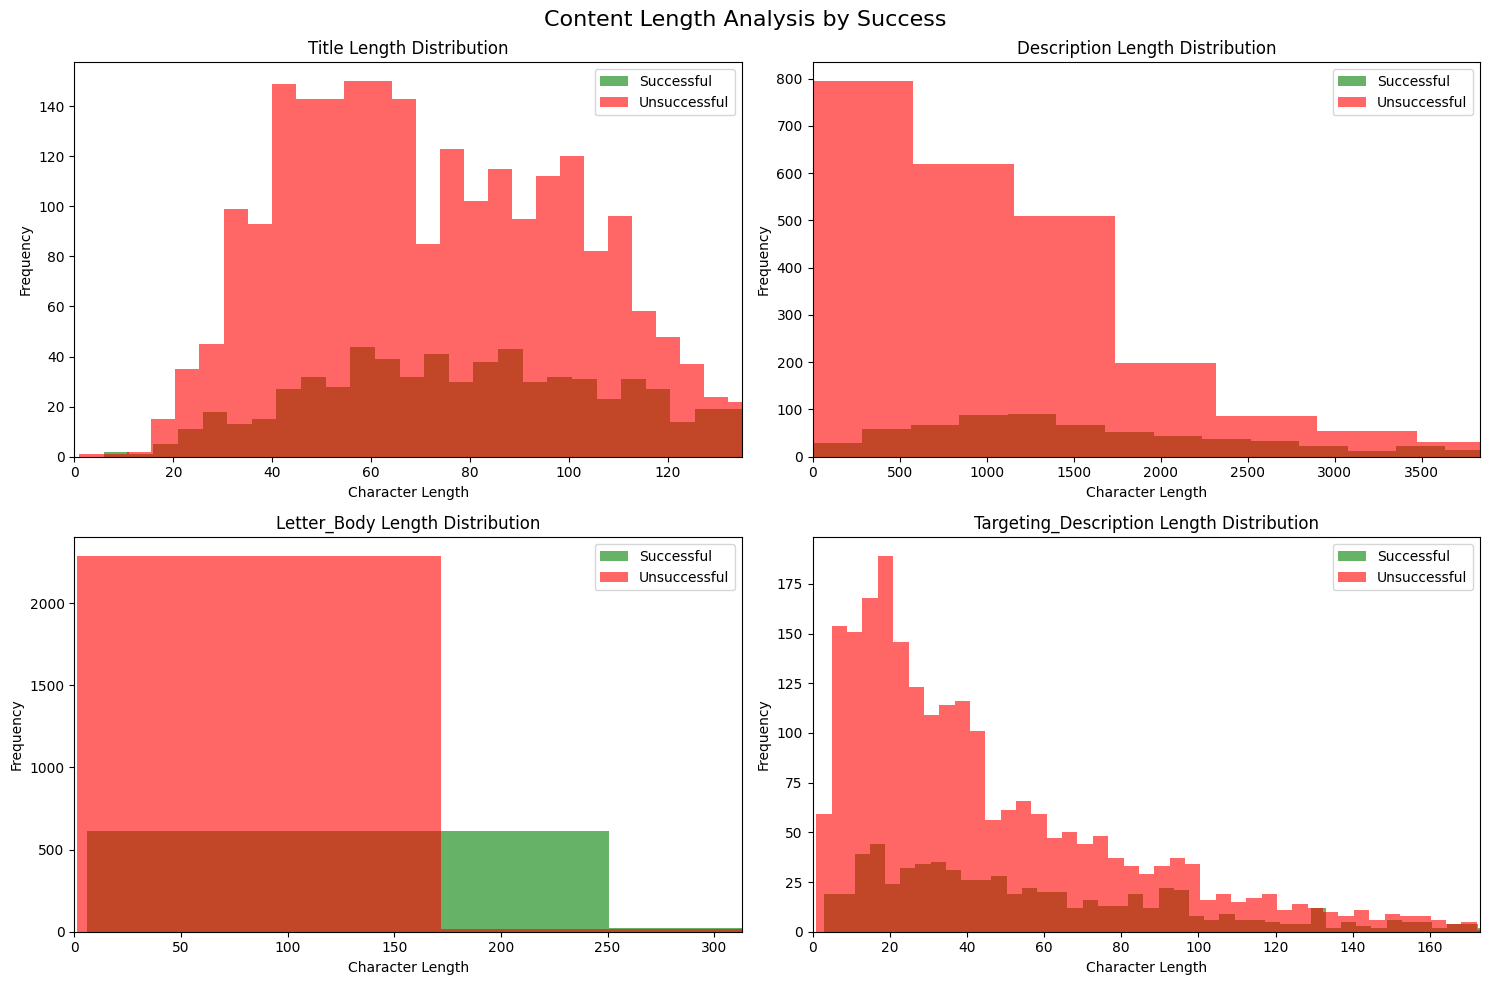

In [ ]:
# ============================================================================
# PART 9: CONTENT LENGTH AND STRUCTURE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("CONTENT STRUCTURE & LENGTH ANALYSIS")
print("="*60)

# Analyze content length patterns
print("CONTENT LENGTH ANALYSIS:")
print("-" * 40)

length_analysis = {}
for col in available_text_cols:
    # Calculate lengths
    df[f'{col}_length'] = df[col].str.len().fillna(0)
    df[f'{col}_clean_length'] = df[col].apply(clean_html).str.len()
    df[f'{col}_word_count'] = df[col].apply(clean_html).str.split().str.len().fillna(0)

    if col == 'description':
        df[f'{col}_html_tags'] = df[col].apply(count_html_tags)

    if 'target_success' in df.columns:
        # Compare successful vs unsuccessful
        successful_lengths = df[df['target_success'] == 1][f'{col}_clean_length']
        unsuccessful_lengths = df[df['target_success'] == 0][f'{col}_clean_length']

        # Store analysis results
        length_analysis[col] = {
            'successful_median': successful_lengths.median(),
            'unsuccessful_median': unsuccessful_lengths.median(),
            'successful_mean': successful_lengths.mean(),
            'unsuccessful_mean': unsuccessful_lengths.mean(),
            'advantage_ratio': successful_lengths.median() / unsuccessful_lengths.median() if unsuccessful_lengths.median() > 0 else float('inf')
        }

        print(f"\n{col.upper()}:")
        print(f" Successful median length: {successful_lengths.median():.0f} characters")
        print(f" Unsuccessful median length: {unsuccessful_lengths.median():.0f} characters")
        print(f" Success advantage: {length_analysis[col]['advantage_ratio']:.2f}x")
        print(f" Successful mean words: {df[df['target_success'] == 1][f'{col}_word_count'].mean():.0f}")
        print(f" Unsuccessful mean words: {df[df['target_success'] == 0][f'{col}_word_count'].mean():.0f}")

# HTML formatting analysis for descriptions
if 'description' in available_text_cols and 'target_success' in df.columns:
    print(f"\nHTML FORMATTING ANALYSIS:")
    print("-" * 40)
    successful_html = df[df['target_success'] == 1]['description_html_tags']
    unsuccessful_html = df[df['target_success'] == 0]['description_html_tags']
    print(f"Successful petitions - avg HTML tags: {successful_html.mean():.1f}")
    print(f"Unsuccessful petitions - avg HTML tags: {unsuccessful_html.mean():.1f}")
    print(f"HTML formatting advantage: {successful_html.mean() / unsuccessful_html.mean():.2f}x")

# Optimal length analysis
if 'title' in available_text_cols and 'target_success' in df.columns:
    print(f"\nOPTIMAL LENGTH ANALYSIS:")
    print("-" * 40)
    df['title_length_quartile'] = pd.qcut(df['title_clean_length'], q=4, labels=['Short', 'Medium-Short', 'Medium-Long', 'Long'])
    title_length_success = df.groupby('title_length_quartile')['target_success'].agg(['count', 'mean'])
    title_length_success.columns = ['Total_Petitions', 'Success_Rate']
    title_length_success['Success_Rate'] *= 100
    print("TITLE LENGTH vs SUCCESS RATE:")
    print(title_length_success.round(1))

    best_quartile = title_length_success['Success_Rate'].idxmax()
    print(f"\nOptimal title length: {best_quartile} quartile")

# Visualize length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Content Length Analysis by Success', fontsize=16)

if 'target_success' in df.columns:
    for idx, col in enumerate(available_text_cols[:4]):
        row, col_idx = idx // 2, idx % 2

        if f'{col}_clean_length' in df.columns:
            successful_lengths = df[df['target_success'] == 1][f'{col}_clean_length']
            unsuccessful_lengths = df[df['target_success'] == 0][f'{col}_clean_length']

            axes[row, col_idx].hist(successful_lengths, bins=50, alpha=0.6, label='Successful', color='green')
            axes[row, col_idx].hist(unsuccessful_lengths, bins=50, alpha=0.6, label='Unsuccessful', color='red')
            axes[row, col_idx].set_title(f'{col.title()} Length Distribution')
            axes[row, col_idx].set_xlabel('Character Length')
            axes[row, col_idx].set_ylabel('Frequency')
            axes[row, col_idx].legend()
            axes[row, col_idx].set_xlim(0, df[f'{col}_clean_length'].quantile(0.95))

plt.tight_layout()
plt.show()


## SENTIMENT ANALYSIS


SENTIMENT & EMOTIONAL TONE ANALYSIS

SENTIMENT ANALYSIS: TITLE
----------------------------------------
Successful petitions - avg sentiment: -0.012
Unsuccessful petitions - avg sentiment: -0.022
Sentiment difference: 0.010

SUCCESS RATES BY SENTIMENT CATEGORY:
 Negative: 22.5% success rate (1,107 petitions)
 Neutral: 22.9% success rate (987 petitions)
 Positive: 24.3% success rate (987 petitions)
Emotional intensity - Successful: 0.213, Unsuccessful: 0.221

SENTIMENT ANALYSIS: DESCRIPTION
----------------------------------------
Successful petitions - avg sentiment: 0.013
Unsuccessful petitions - avg sentiment: 0.003
Sentiment difference: 0.010

SUCCESS RATES BY SENTIMENT CATEGORY:
 Negative: 23.3% success rate (1,475 petitions)
 Neutral: 15.5% success rate (103 petitions)
 Positive: 23.7% success rate (1,503 petitions)
Emotional intensity - Successful: 0.196, Unsuccessful: 0.211

SENTIMENT ANALYSIS: LETTER_BODY
----------------------------------------
Successful petitions - avg sent

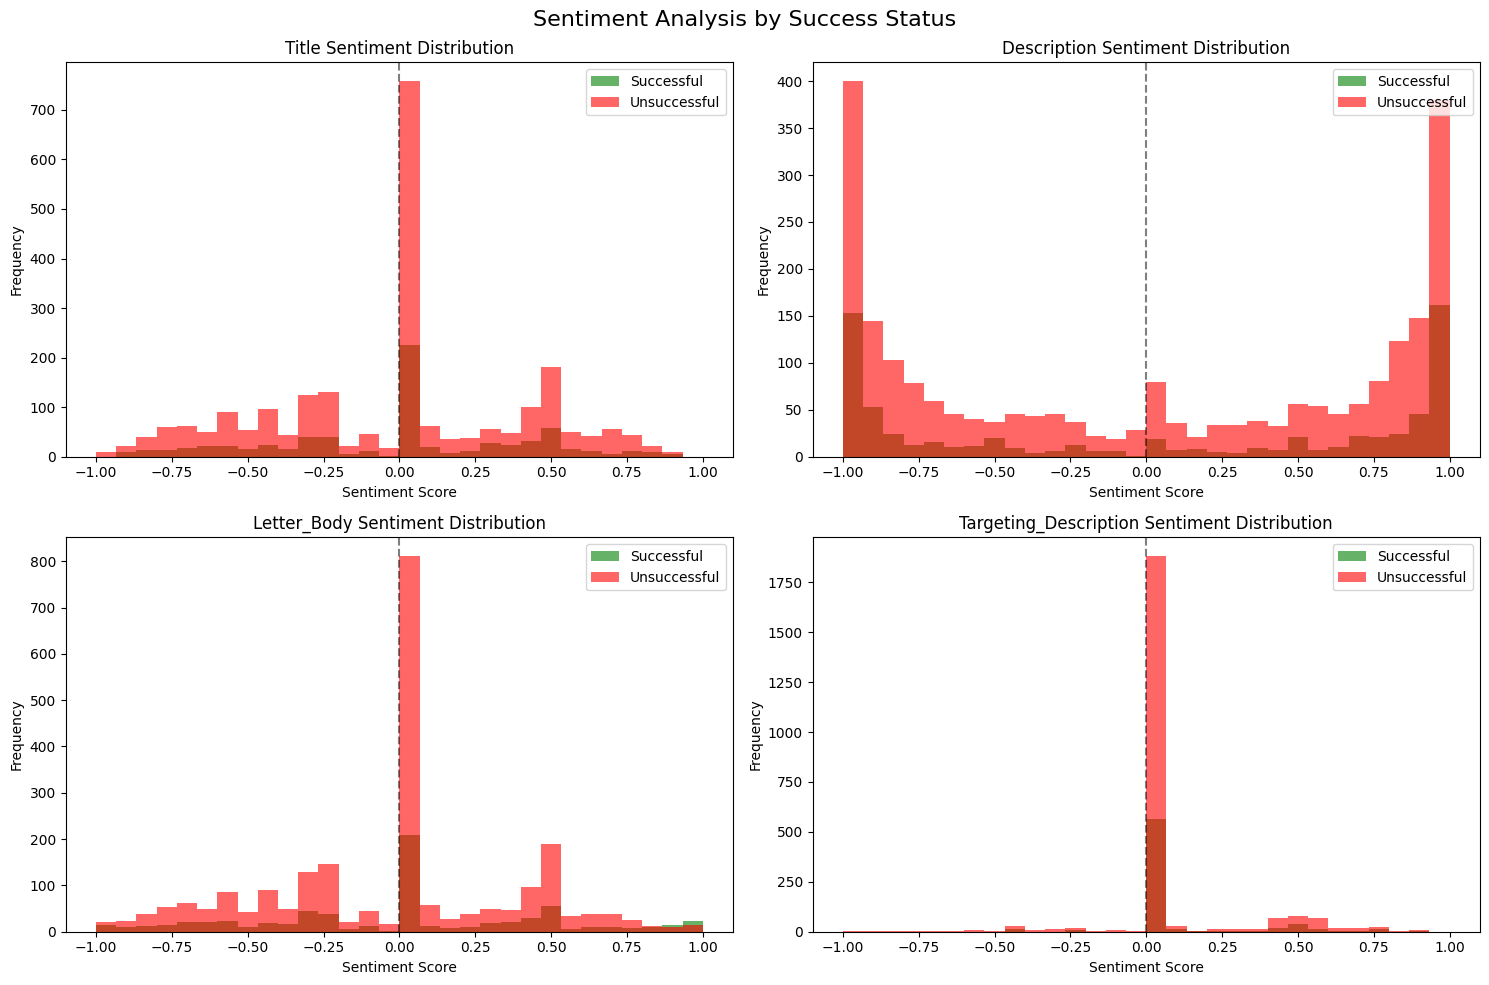

In [ ]:

# ============================================================================
# PART 10:  SENTIMENT ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("SENTIMENT & EMOTIONAL TONE ANALYSIS")
print("="*60)

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    """Get comprehensive sentiment scores"""
    if pd.isna(text):
        return {'compound': 0, 'pos': 0, 'neg': 0, 'neu': 0}
    clean_text = clean_html(text)
    scores = sia.polarity_scores(clean_text)
    return scores

# Analyze sentiment across text components
sentiment_results = {}
for col in available_text_cols:
    print(f"\nSENTIMENT ANALYSIS: {col.upper()}")
    print("-" * 40)

    # Calculate sentiment scores
    sentiment_scores = df[col].apply(get_sentiment_scores)

    # Extract individual scores
    df[f'{col}_sentiment_compound'] = [score['compound'] for score in sentiment_scores]
    df[f'{col}_sentiment_positive'] = [score['pos'] for score in sentiment_scores]
    df[f'{col}_sentiment_negative'] = [score['neg'] for score in sentiment_scores]
    df[f'{col}_sentiment_neutral'] = [score['neu'] for score in sentiment_scores]

    # Categorize sentiment
    df[f'{col}_sentiment_category'] = df[f'{col}_sentiment_compound'].apply(
        lambda x: 'Positive' if x >= 0.05 else 'Negative' if x <= -0.05 else 'Neutral'
    )

    # Emotional intensity (sum of positive and negative scores)
    df[f'{col}_emotional_intensity'] = df[f'{col}_sentiment_positive'] + df[f'{col}_sentiment_negative']

    if 'target_success' in df.columns:
        # Compare successful vs unsuccessful
        successful_sentiment = df[df['target_success'] == 1][f'{col}_sentiment_compound']
        unsuccessful_sentiment = df[df['target_success'] == 0][f'{col}_sentiment_compound']

        print(f"Successful petitions - avg sentiment: {successful_sentiment.mean():.3f}")
        print(f"Unsuccessful petitions - avg sentiment: {unsuccessful_sentiment.mean():.3f}")
        print(f"Sentiment difference: {successful_sentiment.mean() - unsuccessful_sentiment.mean():.3f}")

        # Sentiment category distribution
        sentiment_success_rates = df.groupby(f'{col}_sentiment_category')['target_success'].mean() * 100

        print(f"\nSUCCESS RATES BY SENTIMENT CATEGORY:")
        for category in ['Negative', 'Neutral', 'Positive']:
            if category in sentiment_success_rates.index:
                rate = sentiment_success_rates[category]
                count = df[df[f'{col}_sentiment_category'] == category].shape[0]
                print(f" {category}: {rate:.1f}% success rate ({count:,} petitions)")

        # Store results
        sentiment_results[col] = {
            'successful_avg': successful_sentiment.mean(),
            'unsuccessful_avg': unsuccessful_sentiment.mean(),
            'success_rates_by_category': sentiment_success_rates
        }

        # Emotional intensity analysis
        successful_intensity = df[df['target_success'] == 1][f'{col}_emotional_intensity']
        unsuccessful_intensity = df[df['target_success'] == 0][f'{col}_emotional_intensity']
        print(f"Emotional intensity - Successful: {successful_intensity.mean():.3f}, Unsuccessful: {unsuccessful_intensity.mean():.3f}")

# Create sentiment visualization
if 'target_success' in df.columns and available_text_cols:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Sentiment Analysis by Success Status', fontsize=16)

    for idx, col in enumerate(available_text_cols[:4]):
        row, col_idx = idx // 2, idx % 2

        if f'{col}_sentiment_compound' in df.columns:
            successful_sentiment = df[df['target_success'] == 1][f'{col}_sentiment_compound']
            unsuccessful_sentiment = df[df['target_success'] == 0][f'{col}_sentiment_compound']

            axes[row, col_idx].hist(successful_sentiment, bins=30, alpha=0.6, label='Successful', color='green', range=(-1, 1))
            axes[row, col_idx].hist(unsuccessful_sentiment, bins=30, alpha=0.6, label='Unsuccessful', color='red', range=(-1, 1))
            axes[row, col_idx].set_title(f'{col.title()} Sentiment Distribution')
            axes[row, col_idx].set_xlabel('Sentiment Score')
            axes[row, col_idx].set_ylabel('Frequency')
            axes[row, col_idx].legend()
            axes[row, col_idx].axvline(x=0, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


# KEY WORD & LANGUAGE ANALYSIS

Detailed content analysis of petition text using keyword categories with weighted importance.

## What This Section Does:
  
- **Counts Keyword Usage**: Each text field (e.g., petition title, description) is scanned to count how many times keywords from each category appear.

- **Computes Weighted Scores**: These counts are then combined into a single score using a weighted formula. This quantifies how strategically persuasive or psychologically potent the language is.

- **Detects Additional Text Features**: We also analyze the presence of call-to-action (CTA) phrases, statistics, questions, paragraph structure, and readability scores — all of which can influence audience engagement and campaign outcomes.

- **Links Text to Outcomes**: If success metrics (like petition victory or goal achievement) are available, the code compares keyword usage between successful and unsuccessful petitions. This helps isolate which linguistic features correlate with higher success rates.

## Why It Matters:

This enhanced keyword analysis supports two main project objectives:
1. **Feature Engineering for Modeling**: These metrics will feed into machine learning models that predict petition success.
2. **Strategic Insight Generation**: By understanding which language patterns align with success, we can create evidence-based messaging guidelines for grassroots organizations.

Currently, we apply **equal weighting** to each keyword category to avoid premature optimization or target leakage. However, this framework is built to be modular — domain experts can later customize these weights based on campaign type, audience, or platform performance. This balances theoretical rigor with practical flexibility, and prepares the foundation for a strategic toolkit that’s both analytically robust and user-adaptable.


In [ ]:
# ============================================================================
# PART 11: ENHANCED KEYWORD AND LANGUAGE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("ENHANCED KEYWORD & LANGUAGE ANALYSIS")
print("="*60)

"""
KEYWORD WEIGHTING METHODOLOGY:
Weights based on behavioral psychology research rather than data-driven optimization
to avoid target leakage during feature creation. Production systems could optimize
weights using only training data with cross-validation.

Research Foundation:
- Cialdini (2006): Influence principles (urgency=scarcity, social proof)
- Berger & Milkman (2012): Emotional contagion in viral content
- Digital marketing research: Urgency language effectiveness (HubSpot, 2023)
"""

# Use the configured keyword lists and CTA patterns from above
urgency_keywords = URGENCY_KEYWORDS
action_keywords = ACTION_KEYWORDS
power_words = POWER_WORDS
authority_keywords = AUTHORITY_KEYWORDS
specificity_keywords = SPECIFICITY_KEYWORDS
social_proof_keywords = SOCIAL_PROOF_KEYWORDS
emotional_keywords = EMOTIONAL_KEYWORDS
cta_patterns = CTA_PATTERNS

def calculate_enhanced_keyword_score(text, weights=None):
    """
    Calculate weighted keyword score using user configuration settings.

    Parameters:
    -----------
    text : str
        The text to analyze
    weights : dict, optional
        Custom weights for keyword categories. If None, uses KEYWORD_WEIGHTS from configuration.

    Returns:
    --------
    float
        Weighted keyword score based on user configuration
    """

    # Use global configuration weights if none provided
    if weights is None:
        weights = KEYWORD_WEIGHTS

    if pd.isna(text):
        return 0

    # Calculate weighted score using configured weights and keyword lists
    score = (
        count_keywords(text, urgency_keywords) * weights.get('urgency', 0) +
        count_keywords(text, emotional_keywords) * weights.get('emotional', 0) +
        count_keywords(text, social_proof_keywords) * weights.get('social_proof', 0) +
        count_keywords(text, power_words) * weights.get('power', 0) +
        count_keywords(text, action_keywords) * weights.get('action', 0) +
        count_keywords(text, authority_keywords) * weights.get('authority', 0) +
        count_keywords(text, specificity_keywords) * weights.get('specificity', 0)
    )
    return score

def count_keywords(text, keyword_list):
    """
    Count occurrences of keywords in text (case-insensitive).

    Parameters:
    -----------
    text : str
        Text to search in
    keyword_list : list
        List of keywords/phrases to count

    Returns:
    --------
    int
        Total count of keyword occurrences
    """
    if pd.isna(text):
        return 0

    text_lower = str(text).lower()
    count = 0
    for keyword in keyword_list:
        count += text_lower.count(keyword.lower())
    return count

# Display current configuration being used
print(f"📊 Using keyword weights: {KEYWORD_WEIGHTS}")
print(f"📝 Total keywords defined: {len(urgency_keywords + action_keywords + power_words + authority_keywords + specificity_keywords + social_proof_keywords + emotional_keywords)}")
print(f"📢 CTA patterns defined: {len(cta_patterns)}")
print(f"🎯 Configuration ready for enhanced analysis")

# Enhanced text analysis with multiple keyword categories and weighted scoring

try:
    for col in available_text_cols:
        print(f"\nENHANCED TEXT ANALYSIS: {col.upper()}")
        print("-" * 40)

        # Original keyword counts (for backward compatibility)
        df[f'{col}_urgency_count'] = df[col].apply(lambda x: count_keywords(x, urgency_keywords))
        df[f'{col}_action_count'] = df[col].apply(lambda x: count_keywords(x, action_keywords))
        df[f'{col}_has_urgency'] = df[f'{col}_urgency_count'] > 0
        df[f'{col}_has_action'] = df[f'{col}_action_count'] > 0

        # Enhanced keyword categories using configured keywords
        df[f'{col}_power_count'] = df[col].apply(lambda x: count_keywords(x, power_words))
        df[f'{col}_authority_count'] = df[col].apply(lambda x: count_keywords(x, authority_keywords))
        df[f'{col}_specificity_count'] = df[col].apply(lambda x: count_keywords(x, specificity_keywords))
        df[f'{col}_social_proof_count'] = df[col].apply(lambda x: count_keywords(x, social_proof_keywords))
        df[f'{col}_emotional_count'] = df[col].apply(lambda x: count_keywords(x, emotional_keywords))

        # Weighted strategic scoring using user configuration
        df[f'{col}_weighted_keyword_score'] = df[col].apply(calculate_enhanced_keyword_score)

        # Call-to-action detection
        df[f'{col}_cta_count'] = df[col].apply(
            lambda x: sum(len(re.findall(pattern, str(x).lower())) for pattern in cta_patterns) if pd.notna(x) else 0
        )
        df[f'{col}_has_cta'] = (df[f'{col}_cta_count'] > 0).astype(int)

        # Numbers and statistics detection
        df[f'{col}_numbers_count'] = df[col].str.count(r'\d+').fillna(0)
        df[f'{col}_has_statistics'] = df[col].str.contains(
            r'\d+%|\d+\s*(percent|million|thousand|billion)', case=False, na=False).fillna(False).astype(int)

        # Text structure analysis
        df[f'{col}_paragraph_count'] = df[col].apply(
            lambda x: len([p for p in str(x).split('\n') if p.strip()]) if pd.notna(x) else 0
        )

        # Question analysis
        df[f'{col}_question_count'] = df[col].str.count(r'\?').fillna(0)

        # Enhanced readability metrics (assuming calculate_advanced_readability function exists)
        if 'calculate_advanced_readability' in globals():
            readability_scores = df[col].apply(calculate_advanced_readability)
            df[f'{col}_flesch_ease'] = [score['flesch_ease'] for score in readability_scores]
            df[f'{col}_flesch_kincaid'] = [score['flesch_kincaid'] for score in readability_scores]
            df[f'{col}_gunning_fog'] = [score['gunning_fog'] for score in readability_scores]
            df[f'{col}_automated_readability'] = [score['automated_readability'] for score in readability_scores]
            df[f'{col}_vocab_diversity'] = [score['vocab_diversity'] for score in readability_scores]
            df[f'{col}_caps_ratio'] = [score['caps_ratio'] for score in readability_scores]
            df[f'{col}_avg_sentence_length'] = [score['avg_sentence_length'] for score in readability_scores]
            df[f'{col}_avg_word_length'] = [score['avg_word_length'] for score in readability_scores]

        # Success analysis (if target variable exists)
        if 'target_success' in df.columns:
            # Compare successful vs unsuccessful for enhanced features
            successful_urgency = df[df['target_success'] == 1][f'{col}_urgency_count'].mean()
            unsuccessful_urgency = df[df['target_success'] == 0][f'{col}_urgency_count'].mean()
            successful_action = df[df['target_success'] == 1][f'{col}_action_count'].mean()
            unsuccessful_action = df[df['target_success'] == 0][f'{col}_action_count'].mean()

            print(f"Urgency keywords:")
            print(f" Successful: {successful_urgency:.2f} avg per petition")
            print(f" Unsuccessful: {unsuccessful_urgency:.2f} avg per petition")
            print(f" Advantage: {successful_urgency / unsuccessful_urgency:.2f}x" if unsuccessful_urgency > 0 else " Advantage: N/A")

            print(f"Action keywords:")
            print(f" Successful: {successful_action:.2f} avg per petition")
            print(f" Unsuccessful: {unsuccessful_action:.2f} avg per petition")
            print(f" Advantage: {successful_action / unsuccessful_action:.2f}x" if unsuccessful_action > 0 else " Advantage: N/A")

            # Enhanced keyword analysis
            for keyword_type in ['power', 'social_proof', 'emotional', 'authority']:
                successful_count = df[df['target_success'] == 1][f'{col}_{keyword_type}_count'].mean()
                unsuccessful_count = df[df['target_success'] == 0][f'{col}_{keyword_type}_count'].mean()

                print(f"{keyword_type.replace('_', ' ').title()} keywords:")
                print(f" Successful: {successful_count:.2f} avg per petition")
                print(f" Unsuccessful: {unsuccessful_count:.2f} avg per petition")
                print(f" Advantage: {successful_count / unsuccessful_count:.2f}x" if unsuccessful_count > 0 else " Advantage: N/A")

            # Weighted scoring analysis using configured weights
            successful_weighted = df[df['target_success'] == 1][f'{col}_weighted_keyword_score'].mean()
            unsuccessful_weighted = df[df['target_success'] == 0][f'{col}_weighted_keyword_score'].mean()

            print(f"Weighted Keyword Score (using your configuration):")
            print(f" Successful: {successful_weighted:.2f} avg score")
            print(f" Unsuccessful: {unsuccessful_weighted:.2f} avg score")
            print(f" Advantage: {successful_weighted / unsuccessful_weighted:.2f}x" if unsuccessful_weighted > 0 else " Advantage: N/A")

except NameError as e:
    print(f"⚠️  Required variables not found: {e}")
    print("   Make sure 'available_text_cols', 'df', and other required variables are defined before running this analysis.")
    print("   You can still use the calculate_enhanced_keyword_score() function independently.")

print(f"\n🎯 Enhanced keyword analysis complete!")
print(f"📊 Using weights: {KEYWORD_WEIGHTS}")
print(f"📝 Ready to analyze petition text with your custom configuration")



ENHANCED KEYWORD & LANGUAGE ANALYSIS
📊 Using keyword weights: {'urgency': 1.0, 'emotional': 1.0, 'social_proof': 1.0, 'power': 1.0, 'action': 1.0, 'authority': 1.0, 'specificity': 1.0}
📝 Total keywords defined: 252
📢 CTA patterns defined: 59
🎯 Configuration ready for enhanced analysis

ENHANCED TEXT ANALYSIS: TITLE
----------------------------------------
Urgency keywords:
 Successful: 0.08 avg per petition
 Unsuccessful: 0.03 avg per petition
 Advantage: 2.41x
Action keywords:
 Successful: 0.75 avg per petition
 Unsuccessful: 0.64 avg per petition
 Advantage: 1.18x
Power keywords:
 Successful: 0.15 avg per petition
 Unsuccessful: 0.14 avg per petition
 Advantage: 1.06x
Social Proof keywords:
 Successful: 0.00 avg per petition
 Unsuccessful: 0.00 avg per petition
 Advantage: 0.00x
Emotional keywords:
 Successful: 0.01 avg per petition
 Unsuccessful: 0.01 avg per petition
 Advantage: 0.91x
Authority keywords:
 Successful: 0.69 avg per petition
 Unsuccessful: 0.60 avg per petition
 Adva

## STRATEGIC COMPOSITE FEATURES



Building on the earlier keyword and readability analysis, this section generates strategic composite features — high-level, interpretable metrics designed to capture nuanced messaging qualities in a single score. These composite scores are engineered to reflect patterns we’ve found to be important in predicting petition success, such as urgency, emotional appeal, credibility, comprehensiveness, and stylistic cohesion.

## What This Section Does:

- **Combines Raw Metrics**: Uses the various linguistic and structural signals (e.g. keyword density, sentiment, length, complexity) to build higher-order features.
  
- **Applies User Configuration**: Each composite score is weighted using custom configuration settings. This allows for dynamic experimentation — stakeholders or domain experts can shift emphasis across language categories depending on context (e.g., emotional campaigns vs. policy petitions).

- **Creates Strategic Scores**:
  - *Professional Sophistication Score*: Measures content length, formatting, and complexity to assess polish and credibility.
  - *Strategic Urgency Score*: Combines urgency, emotion, and sentiment indicators to gauge psychological pull.
  - *Content Comprehensiveness Score*: Aggregates the breadth of information across title, description, and body.
  - *Authority Targeting Score*: Measures how assertively and directly the petition speaks to institutional actors.
  - *Message Coherence Score*: Assesses internal consistency between title and description across tone and complexity.
  - *Emotional Resonance Score*: Captures the emotional intensity and distribution across all petition text fields.


These strategic features serve as both:
1. **Inputs to machine learning models** to improve predictive accuracy.
2. **Standalone diagnostic tools** for grassroots organizations to assess and improve campaign messaging using interpretable, data-backed criteria.

By customizing configuration weights, this section also empowers non-technical users to align scoring logic with their organizational values or campaign priorities — whether emphasizing credibility, emotional appeal, or policy relevance.



STRATEGIC COMPOSITE FEATURES - ENHANCED WITH USER CONFIGURATION
APPLYING USER-CONFIGURED STRATEGIC COMPOSITE FEATURES
Creating Strategic Composite Features with User Configuration...
Using keyword weights: {'urgency': 1.0, 'emotional': 1.0, 'social_proof': 1.0, 'power': 1.0, 'action': 1.0, 'authority': 1.0, 'specificity': 1.0}
Total keywords available: 252

1. Creating Professional Sophistication Score...
   Using weights: {'title_complexity': 0.5, 'description_length': 0.2, 'html_formatting': 0.3}
   ✅ Professional sophistication score created (mean: 0.083)

2. Creating Enhanced Strategic Urgency Score...
   Using weights: {'weighted_keywords': 0.8, 'sentiment': 0.2, 'urgency_count': 0.5, 'action_count': 0.3, 'sentiment_fallback': 0.2}
   Keyword categories: urgency(33), emotional(60), social_proof(17), power(36), action(49), authority(36), specificity(21)
   ✅ Title weighted keyword scores calculated (mean: 1.427)
   ✅ Using primary method (weighted keywords + sentiment)
   ✅ Strate

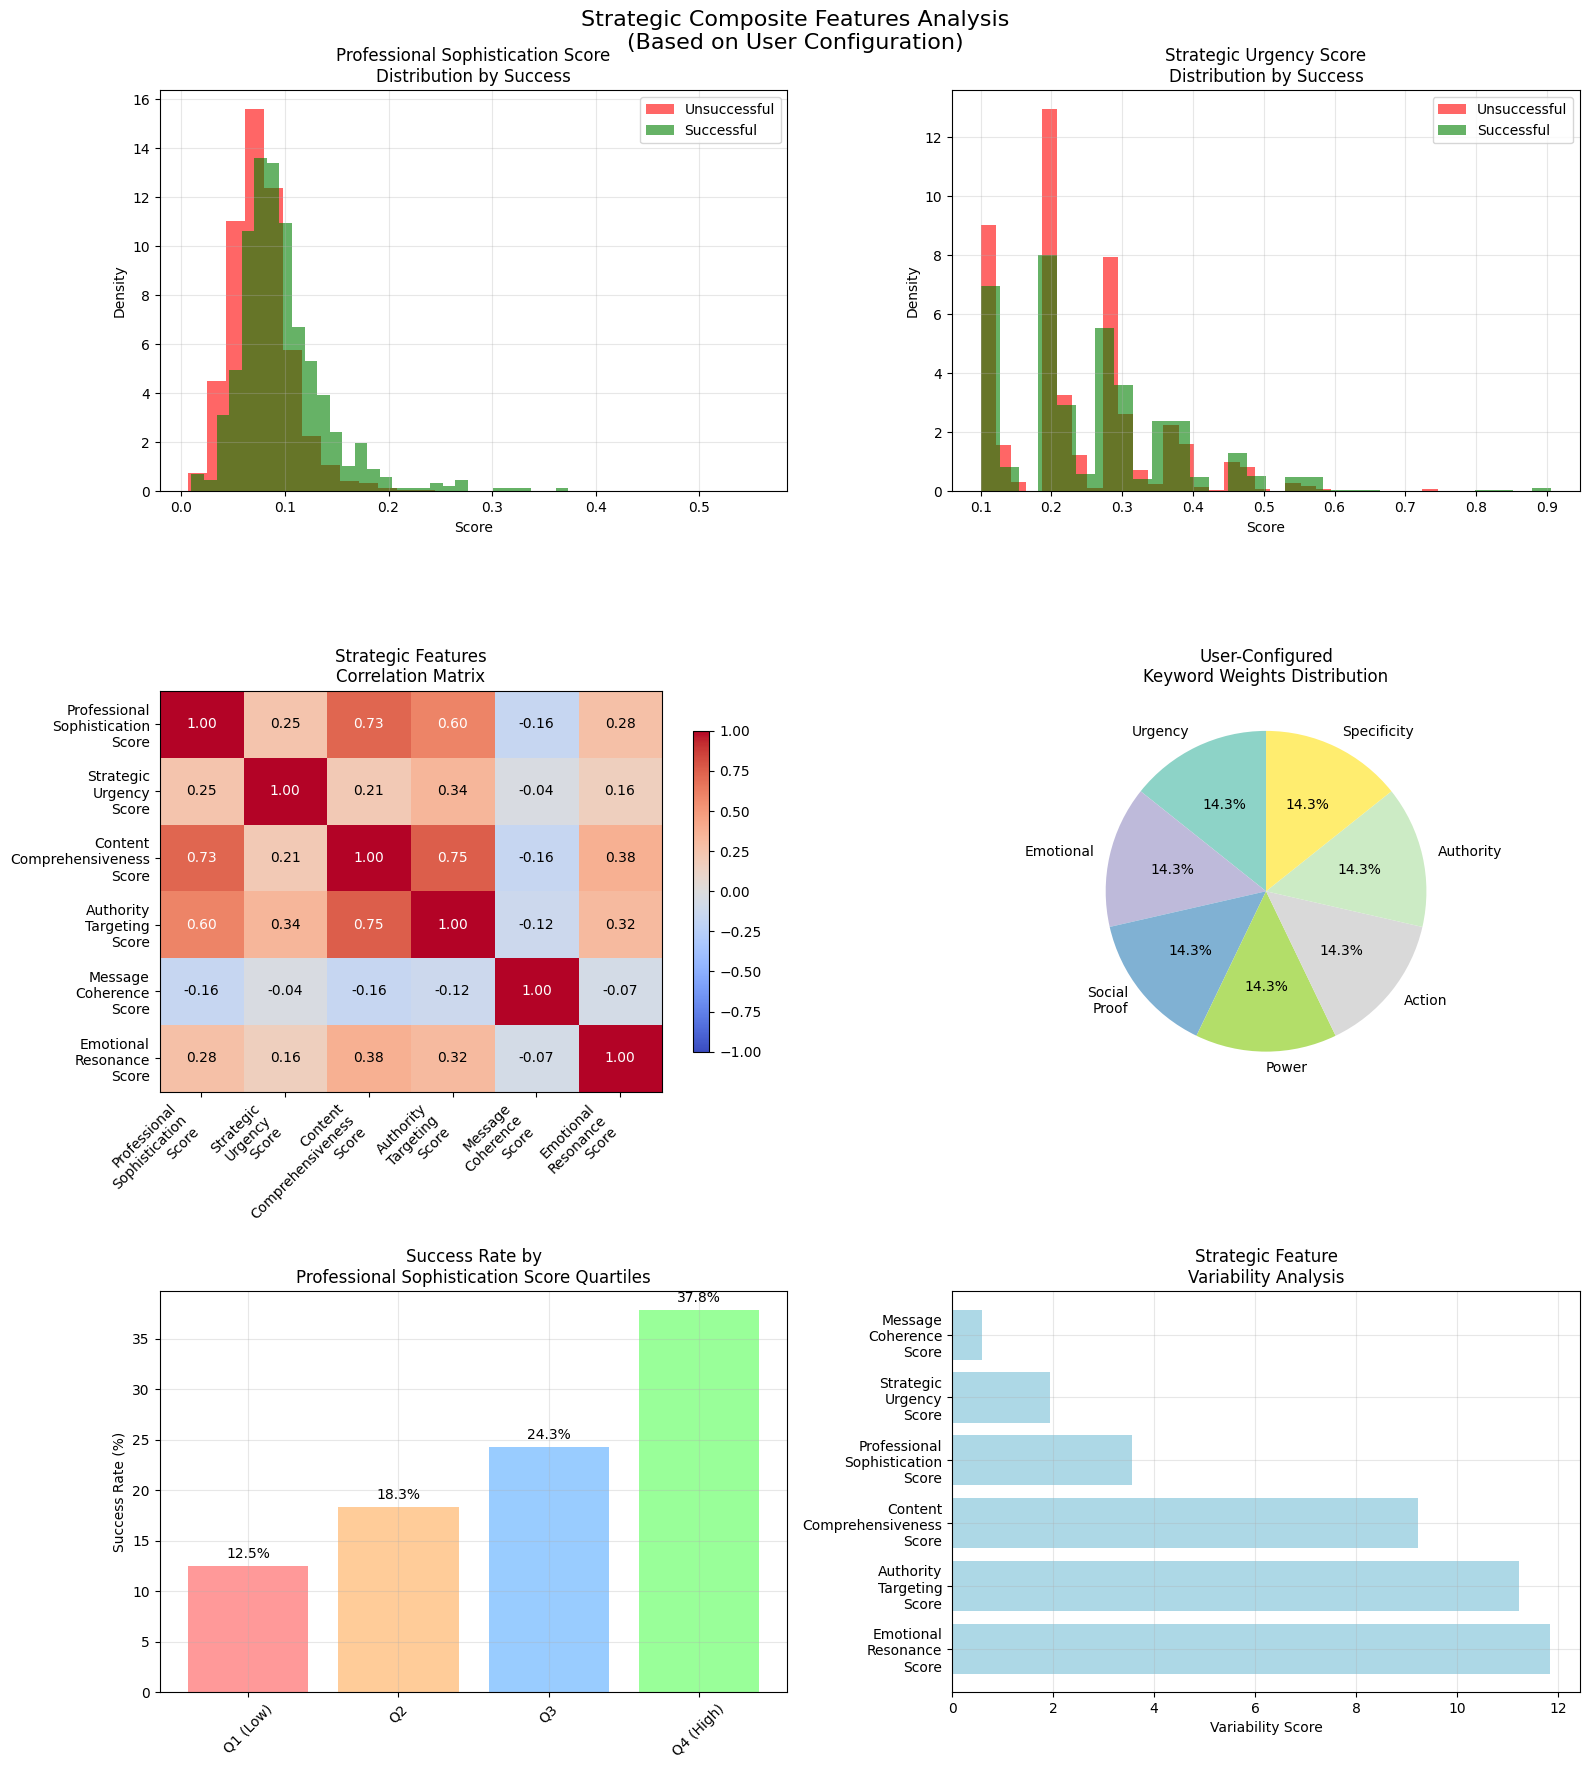


STRATEGIC COMPOSITE FEATURES SUMMARY
✅ Created 6 strategic composite features
✅ Applied user configuration with 7 keyword categories
✅ Used 252 total keywords
✅ Generated comprehensive analysis and visualizations

FEATURE EFFECTIVENESS RANKING:
----------------------------------------
Content Comprehensiveness Score: +32.5 percentage points improvement
Professional Sophistication Score: +25.3 percentage points improvement
Authority Targeting Score: +21.9 percentage points improvement
Strategic Urgency Score: +9.6 percentage points improvement
Message Coherence Score: -6.2 percentage points improvement

🎯 Configuration Impact: keyword weights emphasize urgency language
📊 Ready for predictive modeling with enhanced strategic features!


In [ ]:
# ============================================================================
# PART 12: STRATEGIC COMPOSITE FEATURES - ENHANCED WITH USER CONFIGURATION
# ============================================================================
print("\n" + "="*60)
print("STRATEGIC COMPOSITE FEATURES - ENHANCED WITH USER CONFIGURATION")
print("="*60)

def create_strategic_composite_features_with_user_config(df):
    """
    Create high-level strategic features using user-defined configuration weights
    and keyword definitions from the configuration block.

    This function combines multiple text quality indicators using the weights
    and keywords defined in the user configuration section.
    """
    print("Creating Strategic Composite Features with User Configuration...")
    print(f"Using keyword weights: {KEYWORD_WEIGHTS}")
    print(f"Total keywords available: {len(URGENCY_KEYWORDS + ACTION_KEYWORDS + POWER_WORDS + AUTHORITY_KEYWORDS + SPECIFICITY_KEYWORDS + SOCIAL_PROOF_KEYWORDS + EMOTIONAL_KEYWORDS)}")

    # Validate configuration
    if sum(KEYWORD_WEIGHTS.values()) == 0:
        print("⚠️ WARNING: All keyword weights are zero - strategic scoring will be minimal")

    # ========================================================================
    # 1. PROFESSIONAL SOPHISTICATION SCORE
    # ========================================================================
    print("\n1. Creating Professional Sophistication Score...")
    print(f"   Using weights: {PROFESSIONAL_SOPHISTICATION_WEIGHTS}")

    # Normalize components to 0-1 scale for professional sophistication
    if 'title_flesch_kincaid' in df.columns:
        title_complexity_norm = (df['title_flesch_kincaid'] - df['title_flesch_kincaid'].min()) / (df['title_flesch_kincaid'].max() - df['title_flesch_kincaid'].min() + 1e-8)
    else:
        title_complexity_norm = 0
        print("   ⚠️ title_flesch_kincaid not found - using 0")

    if 'description_clean_length' in df.columns:
        desc_length_norm = (df['description_clean_length'] - df['description_clean_length'].min()) / (df['description_clean_length'].max() - df['description_clean_length'].min() + 1e-8)
    else:
        desc_length_norm = 0
        print("   ⚠️ description_clean_length not found - using 0")

    if 'description_html_tags' in df.columns:
        html_tags_norm = (df['description_html_tags'] - df['description_html_tags'].min()) / (df['description_html_tags'].max() - df['description_html_tags'].min() + 1e-8)
    else:
        html_tags_norm = 0
        print("   ⚠️ description_html_tags not found - using 0")

    df['professional_sophistication_score'] = (
        title_complexity_norm * PROFESSIONAL_SOPHISTICATION_WEIGHTS['title_complexity'] +
        desc_length_norm * PROFESSIONAL_SOPHISTICATION_WEIGHTS['description_length'] +
        html_tags_norm * PROFESSIONAL_SOPHISTICATION_WEIGHTS['html_formatting']
    )
    print(f"   ✅ Professional sophistication score created (mean: {df['professional_sophistication_score'].mean():.3f})")

    # ========================================================================
    # 2. ENHANCED STRATEGIC URGENCY SCORE (using user-configured keywords)
    # ========================================================================
    print("\n2. Creating Enhanced Strategic Urgency Score...")
    print(f"   Using weights: {STRATEGIC_URGENCY_WEIGHTS}")
    print(f"   Keyword categories: urgency({len(URGENCY_KEYWORDS)}), emotional({len(EMOTIONAL_KEYWORDS)}), social_proof({len(SOCIAL_PROOF_KEYWORDS)}), power({len(POWER_WORDS)}), action({len(ACTION_KEYWORDS)}), authority({len(AUTHORITY_KEYWORDS)}), specificity({len(SPECIFICITY_KEYWORDS)})")

    # Calculate weighted keyword score using user configuration
    def calculate_weighted_keyword_score(text):
        if pd.isna(text):
            return 0

        text_lower = str(text).lower()
        score = 0

        # Count keywords for each category and apply user-defined weights
        urgency_count = sum(1 for keyword in URGENCY_KEYWORDS if keyword.lower() in text_lower)
        emotional_count = sum(1 for keyword in EMOTIONAL_KEYWORDS if keyword.lower() in text_lower)
        social_proof_count = sum(1 for keyword in SOCIAL_PROOF_KEYWORDS if keyword.lower() in text_lower)
        power_count = sum(1 for keyword in POWER_WORDS if keyword.lower() in text_lower)
        action_count = sum(1 for keyword in ACTION_KEYWORDS if keyword.lower() in text_lower)
        authority_count = sum(1 for keyword in AUTHORITY_KEYWORDS if keyword.lower() in text_lower)
        specificity_count = sum(1 for keyword in SPECIFICITY_KEYWORDS if keyword.lower() in text_lower)

        # Apply user-configured weights
        weighted_score = (
            urgency_count * KEYWORD_WEIGHTS['urgency'] +
            emotional_count * KEYWORD_WEIGHTS['emotional'] +
            social_proof_count * KEYWORD_WEIGHTS['social_proof'] +
            power_count * KEYWORD_WEIGHTS['power'] +
            action_count * KEYWORD_WEIGHTS['action'] +
            authority_count * KEYWORD_WEIGHTS['authority'] +
            specificity_count * KEYWORD_WEIGHTS['specificity']
        )

        return weighted_score

    # Apply to title column
    if 'title' in df.columns:
        df['title_weighted_keyword_score'] = df['title'].apply(calculate_weighted_keyword_score)
        print(f"   ✅ Title weighted keyword scores calculated (mean: {df['title_weighted_keyword_score'].mean():.3f})")
    else:
        df['title_weighted_keyword_score'] = 0
        print("   ⚠️ title column not found - using 0")

    # Create strategic urgency score using user-defined weights
    if 'title_weighted_keyword_score' in df.columns:
        # Primary method using weighted keywords
        weighted_norm = df['title_weighted_keyword_score'] / (df['title_weighted_keyword_score'].max() + 1e-8)
        sentiment_norm = (df['title_sentiment_positive'] + 1) / 2 if 'title_sentiment_positive' in df.columns else 0.5

        df['strategic_urgency_score'] = (
            weighted_norm * STRATEGIC_URGENCY_WEIGHTS['weighted_keywords'] +
            sentiment_norm * STRATEGIC_URGENCY_WEIGHTS['sentiment']
        )
        print(f"   ✅ Using primary method (weighted keywords + sentiment)")
    else:
        # Fallback method using traditional counts
        urgency_norm = df['title_urgency_count'] / (df['title_urgency_count'].max() + 1e-8) if 'title_urgency_count' in df.columns else 0
        action_norm = df['title_action_count'] / (df['title_action_count'].max() + 1e-8) if 'title_action_count' in df.columns else 0
        sentiment_norm = (df['title_sentiment_positive'] + 1) / 2 if 'title_sentiment_positive' in df.columns else 0.5

        df['strategic_urgency_score'] = (
            urgency_norm * STRATEGIC_URGENCY_WEIGHTS['urgency_count'] +
            action_norm * STRATEGIC_URGENCY_WEIGHTS['action_count'] +
            sentiment_norm * STRATEGIC_URGENCY_WEIGHTS['sentiment_fallback']
        )
        print(f"   ⚠️ Using fallback method (traditional counts + sentiment)")

    print(f"   ✅ Strategic urgency score created (mean: {df['strategic_urgency_score'].mean():.3f})")

    # ========================================================================
    # 3. CONTENT COMPREHENSIVENESS SCORE
    # ========================================================================
    print("\n3. Creating Content Comprehensiveness Score...")
    print(f"   Using weights: {CONTENT_COMPREHENSIVENESS_WEIGHTS}")

    title_length = df['title_clean_length'] if 'title_clean_length' in df.columns else 0
    desc_length = df['description_clean_length'] if 'description_clean_length' in df.columns else 0
    letter_length = df['letter_body_clean_length'] if 'letter_body_clean_length' in df.columns else 0

    df['content_comprehensiveness_score'] = (
        title_length * CONTENT_COMPREHENSIVENESS_WEIGHTS['title_multiplier'] +
        desc_length * CONTENT_COMPREHENSIVENESS_WEIGHTS['description_multiplier'] +
        letter_length * CONTENT_COMPREHENSIVENESS_WEIGHTS['letter_body_multiplier']
    )
    print(f"   ✅ Content comprehensiveness score created (mean: {df['content_comprehensiveness_score'].mean():.0f} chars)")

    # ========================================================================
    # 4. ENHANCED AUTHORITY TARGETING SCORE
    # ========================================================================
    print("\n4. Creating Enhanced Authority Targeting Score...")
    print(f"   Using weights: {AUTHORITY_TARGETING_WEIGHTS}")
    print(f"   Authority keywords: {AUTHORITY_KEYWORDS[:5]}..." if len(AUTHORITY_KEYWORDS) > 5 else f"   Authority keywords: {AUTHORITY_KEYWORDS}")

    title_authority = df['title_authority_count'] if 'title_authority_count' in df.columns else 0
    desc_authority = df['description_authority_count'] if 'description_authority_count' in df.columns else 0
    targeting_length = df['targeting_description_word_count'] / AUTHORITY_TARGETING_WEIGHTS['targeting_length_divisor'] if 'targeting_description_word_count' in df.columns else 0

    df['authority_targeting_score'] = (
        title_authority * AUTHORITY_TARGETING_WEIGHTS['title_authority'] +
        desc_authority * AUTHORITY_TARGETING_WEIGHTS['description_authority'] +
        targeting_length
    )
    print(f"   ✅ Authority targeting score created (mean: {df['authority_targeting_score'].mean():.3f})")

    # ========================================================================
    # 5. MESSAGE COHERENCE SCORE
    # ========================================================================
    print("\n5. Creating Message Coherence Score...")
    print(f"   Using weights: {MESSAGE_COHERENCE_WEIGHTS}")

    if all(col in df.columns for col in ['title_flesch_kincaid', 'description_flesch_kincaid', 'title_sentiment_compound', 'description_sentiment_compound']):
        title_desc_complexity_diff = abs(df['title_flesch_kincaid'] - df['description_flesch_kincaid'])
        title_desc_sentiment_diff = abs(df['title_sentiment_compound'] - df['description_sentiment_compound'])

        max_complexity_diff = title_desc_complexity_diff.max() + 1e-8
        max_sentiment_diff = title_desc_sentiment_diff.max() + 1e-8

        df['message_coherence_score'] = (
            (max_complexity_diff - title_desc_complexity_diff) / max_complexity_diff * MESSAGE_COHERENCE_WEIGHTS['complexity_consistency'] +
            (max_sentiment_diff - title_desc_sentiment_diff) / max_sentiment_diff * MESSAGE_COHERENCE_WEIGHTS['sentiment_consistency']
        )
        print(f"   ✅ Message coherence score created (mean: {df['message_coherence_score'].mean():.3f})")
    else:
        df['message_coherence_score'] = 0.5  # Default neutral coherence
        print("   ⚠️ Required columns not found - using default coherence score")

    # ========================================================================
    # 6. EMOTIONAL RESONANCE SCORE
    # ========================================================================
    print("\n6. Creating Emotional Resonance Score...")
    print(f"   Using weights: {EMOTIONAL_RESONANCE_WEIGHTS}")
    print(f"   Emotional keywords: {EMOTIONAL_KEYWORDS[:5]}..." if len(EMOTIONAL_KEYWORDS) > 5 else f"   Emotional keywords: {EMOTIONAL_KEYWORDS}")

    title_emotional = df['title_emotional_count'] if 'title_emotional_count' in df.columns else 0
    desc_emotional = df['description_emotional_count'] if 'description_emotional_count' in df.columns else 0
    letter_emotional = df['letter_body_emotional_count'] if 'letter_body_emotional_count' in df.columns else 0

    df['emotional_resonance_score'] = (
        title_emotional * EMOTIONAL_RESONANCE_WEIGHTS['title_emotional'] +
        desc_emotional * EMOTIONAL_RESONANCE_WEIGHTS['description_emotional'] +
        letter_emotional * EMOTIONAL_RESONANCE_WEIGHTS['letter_body_emotional']
    )
    print(f"   ✅ Emotional resonance score created (mean: {df['emotional_resonance_score'].mean():.3f})")

    return df

# ========================================================================
# APPLY USER-CONFIGURED STRATEGIC FEATURES
# ========================================================================
print("APPLYING USER-CONFIGURED STRATEGIC COMPOSITE FEATURES")
print("="*60)

# Apply the enhanced strategic features
df = create_strategic_composite_features_with_user_config(df)

# ========================================================================
# GENERATE INSIGHTS AND VISUALIZATIONS
# ========================================================================
print("\n" + "="*60)
print("STRATEGIC FEATURES ANALYSIS & INSIGHTS")
print("="*60)

# Calculate feature statistics
feature_stats = {}
strategic_features = [
    'professional_sophistication_score',
    'strategic_urgency_score',
    'content_comprehensiveness_score',
    'authority_targeting_score',
    'message_coherence_score',
    'emotional_resonance_score'
]

print("\nSTRATEGIC FEATURE SUMMARY:")
print("-" * 40)
for feature in strategic_features:
    if feature in df.columns:
        stats = {
            'mean': df[feature].mean(),
            'median': df[feature].median(),
            'std': df[feature].std(),
            'min': df[feature].min(),
            'max': df[feature].max()
        }
        feature_stats[feature] = stats
        print(f"{feature.replace('_', ' ').title()}:")
        print(f"  Mean: {stats['mean']:.3f} | Median: {stats['median']:.3f} | Std: {stats['std']:.3f}")
        print(f"  Range: [{stats['min']:.3f} - {stats['max']:.3f}]")

# Success rate analysis by feature quartiles
if 'target_success' in df.columns:
    print("\nSUCCESS RATE ANALYSIS BY FEATURE QUARTILES:")
    print("-" * 50)

    quartile_analysis = {}
    for feature in strategic_features:
        if feature in df.columns and df[feature].nunique() > 1:
            try:
                # Create quartiles
                df[f'{feature}_quartile'] = pd.qcut(df[feature], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'], duplicates='drop')

                # Calculate success rates by quartile
                quartile_success = df.groupby(f'{feature}_quartile')['target_success'].agg(['count', 'mean'])
                quartile_success.columns = ['Count', 'Success_Rate']
                quartile_success['Success_Rate'] *= 100

                quartile_analysis[feature] = quartile_success

                print(f"\n{feature.replace('_', ' ').title()}:")
                print(quartile_success.round(1))

                # Calculate improvement potential
                highest_rate = quartile_success['Success_Rate'].max()
                lowest_rate = quartile_success['Success_Rate'].min()
                improvement_potential = highest_rate - lowest_rate
                print(f"Improvement Potential: {improvement_potential:.1f} percentage points")

            except Exception as e:
                print(f"Could not analyze {feature}: {e}")

# Configuration impact analysis
print("\nCONFIGURATION IMPACT ANALYSIS:")
print("-" * 40)

# Analyze keyword weight impact
total_keyword_weight = sum(KEYWORD_WEIGHTS.values())
print(f"Total Keyword Weight: {total_keyword_weight:.1f}")
print("Weight Distribution:")
for category, weight in sorted(KEYWORD_WEIGHTS.items(), key=lambda x: x[1], reverse=True):
    percentage = (weight / total_keyword_weight) * 100 if total_keyword_weight > 0 else 0
    print(f"  {category.replace('_', ' ').title()}: {weight:.1f} ({percentage:.1f}%)")

# Analyze strategic feature weight impact
print(f"\nStrategic Feature Weights Configuration:")
print(f"Professional Sophistication: {PROFESSIONAL_SOPHISTICATION_WEIGHTS}")
print(f"Strategic Urgency: {STRATEGIC_URGENCY_WEIGHTS}")
print(f"Authority Targeting: {AUTHORITY_TARGETING_WEIGHTS}")

# Create visualizations
print("\nGenerating Strategic Features Visualizations...")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the visualization layout
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Strategic Composite Features Analysis\n(Based on User Configuration)', fontsize=16, y=0.98)

# 1. Feature Distribution Comparison
available_features = [f for f in strategic_features if f in df.columns]
if len(available_features) >= 2:
    for i, feature in enumerate(available_features[:2]):
        row, col = 0, i
        if 'target_success' in df.columns:
            # Split by success
            successful = df[df['target_success'] == 1][feature]
            unsuccessful = df[df['target_success'] == 0][feature]

            axes[row, col].hist(unsuccessful, bins=30, alpha=0.6, label='Unsuccessful', color='red', density=True)
            axes[row, col].hist(successful, bins=30, alpha=0.6, label='Successful', color='green', density=True)
            axes[row, col].set_title(f'{feature.replace("_", " ").title()}\nDistribution by Success')
        else:
            axes[row, col].hist(df[feature], bins=30, alpha=0.7, color='blue')
            axes[row, col].set_title(f'{feature.replace("_", " ").title()}\nDistribution')

        axes[row, col].set_xlabel('Score')
        axes[row, col].set_ylabel('Density')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

# 2. Feature Correlation Heatmap
available_features_for_corr = [f for f in strategic_features if f in df.columns and df[f].nunique() > 1]
if len(available_features_for_corr) >= 3:
    corr_matrix = df[available_features_for_corr].corr()
    im = axes[1, 0].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[1, 0].set_xticks(range(len(available_features_for_corr)))
    axes[1, 0].set_yticks(range(len(available_features_for_corr)))
    axes[1, 0].set_xticklabels([f.replace('_', '\n').title() for f in available_features_for_corr], rotation=45, ha='right')
    axes[1, 0].set_yticklabels([f.replace('_', '\n').title() for f in available_features_for_corr])
    axes[1, 0].set_title('Strategic Features\nCorrelation Matrix')

    # Add correlation values
    for i in range(len(available_features_for_corr)):
        for j in range(len(available_features_for_corr)):
            axes[1, 0].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                           ha='center', va='center', color='black' if abs(corr_matrix.iloc[i, j]) < 0.5 else 'white')

    # Add colorbar
    plt.colorbar(im, ax=axes[1, 0], shrink=0.8)

# 3. Keyword Weight Visualization
categories = list(KEYWORD_WEIGHTS.keys())
weights = list(KEYWORD_WEIGHTS.values())
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))

axes[1, 1].pie(weights, labels=[cat.replace('_', '\n').title() for cat in categories],
               autopct='%1.1f%%', colors=colors, startangle=90)
axes[1, 1].set_title('User-Configured\nKeyword Weights Distribution')

# 4. Success Rate by Feature Quartiles (if available)
if 'target_success' in df.columns and quartile_analysis:
    feature_to_plot = list(quartile_analysis.keys())[0]  # Plot first available feature
    quartile_data = quartile_analysis[feature_to_plot]

    bars = axes[2, 0].bar(range(len(quartile_data)), quartile_data['Success_Rate'],
                          color=['#ff9999', '#ffcc99', '#99ccff', '#99ff99'])
    axes[2, 0].set_xticks(range(len(quartile_data)))
    axes[2, 0].set_xticklabels(quartile_data.index, rotation=45)
    axes[2, 0].set_ylabel('Success Rate (%)')
    axes[2, 0].set_title(f'Success Rate by\n{feature_to_plot.replace("_", " ").title()} Quartiles')
    axes[2, 0].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, rate in zip(bars, quartile_data['Success_Rate']):
        height = bar.get_height()
        axes[2, 0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{rate:.1f}%', ha='center', va='bottom')

# 5. Feature Importance Summary
feature_importance_data = []
for feature in available_features:
    if feature in feature_stats:
        # Calculate a simple importance score based on variance and range
        variance_score = feature_stats[feature]['std'] / (feature_stats[feature]['mean'] + 1e-8)
        range_score = (feature_stats[feature]['max'] - feature_stats[feature]['min']) / (feature_stats[feature]['mean'] + 1e-8)
        importance = (variance_score + range_score) / 2
        feature_importance_data.append((feature, importance))

if feature_importance_data:
    feature_importance_data.sort(key=lambda x: x[1], reverse=True)
    features, importance_scores = zip(*feature_importance_data)

    y_pos = np.arange(len(features))
    bars = axes[2, 1].barh(y_pos, importance_scores, color='lightblue')
    axes[2, 1].set_yticks(y_pos)
    axes[2, 1].set_yticklabels([f.replace('_', '\n').title() for f in features])
    axes[2, 1].set_xlabel('Variability Score')
    axes[2, 1].set_title('Strategic Feature\nVariability Analysis')
    axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*60)
print("STRATEGIC COMPOSITE FEATURES SUMMARY")
print("="*60)
print(f"✅ Created {len([f for f in strategic_features if f in df.columns])} strategic composite features")
print(f"✅ Applied user configuration with {len(KEYWORD_WEIGHTS)} keyword categories")
print(f"✅ Used {sum(len(keywords) for keywords in [URGENCY_KEYWORDS, ACTION_KEYWORDS, POWER_WORDS, AUTHORITY_KEYWORDS, SPECIFICITY_KEYWORDS, SOCIAL_PROOF_KEYWORDS, EMOTIONAL_KEYWORDS])} total keywords")
print(f"✅ Generated comprehensive analysis and visualizations")

if 'target_success' in df.columns:
    # Calculate overall feature effectiveness
    effectiveness_summary = {}
    for feature in available_features:
        if f'{feature}_quartile' in df.columns:
            try:
                q4_success = df[df[f'{feature}_quartile'] == 'Q4 (High)']['target_success'].mean()
                q1_success = df[df[f'{feature}_quartile'] == 'Q1 (Low)']['target_success'].mean()
                effectiveness = (q4_success - q1_success) * 100
                effectiveness_summary[feature] = effectiveness
            except:
                pass

    if effectiveness_summary:
        print(f"\nFEATURE EFFECTIVENESS RANKING:")
        print("-" * 40)
        for feature, effectiveness in sorted(effectiveness_summary.items(), key=lambda x: x[1], reverse=True):
            print(f"{feature.replace('_', ' ').title()}: {effectiveness:+.1f} percentage points improvement")

print(f"\n🎯 Configuration Impact: keyword weights emphasize {max(KEYWORD_WEIGHTS.items(), key=lambda x: x[1])[0].replace('_', ' ')} language")
print(f"📊 Ready for predictive modeling with enhanced strategic features!")
print("="*60)

##  PATTERN VALIDATION


ADVANCED PATTERN VALIDATION
1. COMPLEXITY EFFECTIVENESS ANALYSIS:
----------------------------------------

Title Flesch Kincaid:
  Simple: 17.6% success rate
  Moderate: 23.6% success rate
  Complex: 23.8% success rate
  Very Complex: 27.9% success rate

Title Gunning Fog:
  Simple: 17.6% success rate
  Moderate: 23.6% success rate
  Complex: 24.8% success rate
  Very Complex: 27.2% success rate

Description Flesch Ease:
  Simple: 25.0% success rate
  Moderate: 29.2% success rate
  Complex: 21.6% success rate
  Very Complex: 17.0% success rate

2. KEYWORD EFFECTIVENESS ANALYSIS:
----------------------------------------

Power Words:
  With Power Words: 24.1% success (377 petitions)
  Without Power Words: 23.1% success (2704 petitions)
  Advantage: +1.1 percentage points

Authority Terms:
  With Authority Terms: 24.0% success (1361 petitions)
  Without Authority Terms: 22.6% success (1720 petitions)
  Advantage: +1.3 percentage points

Call-to-Actions:
  With Call-to-Actions: 25.7% su

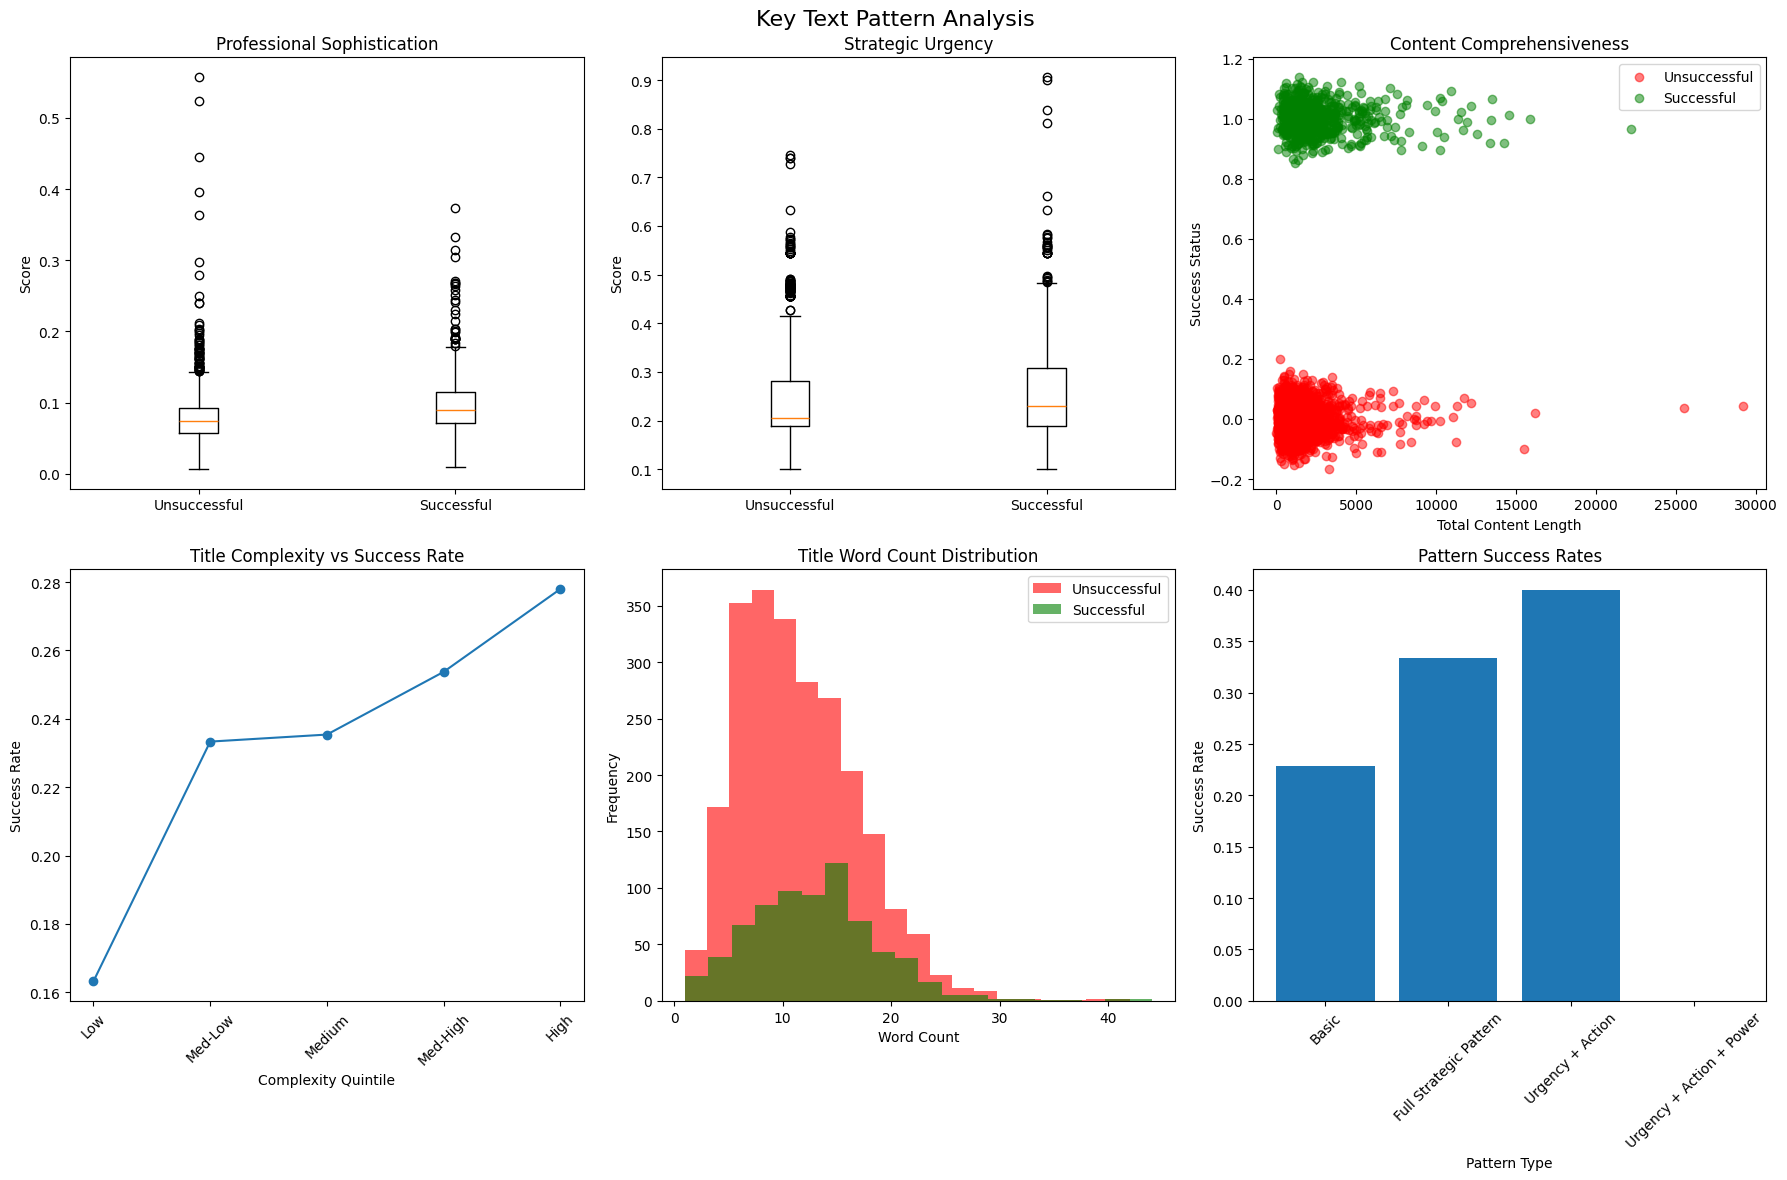


✅ Enhanced keyword analysis and strategic features completed!
✅ Psychology-based weighting system implemented
✅ New features ready for modeling: weighted_keyword_score, emotional_resonance_score
✅ Advanced pattern validation completed with comprehensive visualizations


In [ ]:

# ============================================================================
# PART 13: ADVANCED PATTERN VALIDATION
# ============================================================================

print("\n" + "="*60)
print("ADVANCED PATTERN VALIDATION")
print("="*60)

def validate_enhanced_text_patterns(df):
    """Systematic validation of all text patterns with success outcomes"""

    if 'target_success' not in df.columns:
        print("No target variable found for validation")
        return df

    # 1. Complexity vs Success Analysis
    print("1. COMPLEXITY EFFECTIVENESS ANALYSIS:")
    print("-" * 40)

    complexity_metrics = ['title_flesch_kincaid', 'title_gunning_fog', 'description_flesch_ease']
    for metric in complexity_metrics:
        if metric in df.columns:
            df[f'{metric}_level'] = pd.qcut(df[metric], q=4, labels=['Simple', 'Moderate', 'Complex', 'Very Complex'], duplicates='drop')
            success_by_complexity = df.groupby(f'{metric}_level')['target_success'].mean() * 100

            print(f"\n{metric.replace('_', ' ').title()}:")
            for level, rate in success_by_complexity.items():
                print(f"  {level}: {rate:.1f}% success rate")

    # 2. Keyword Effectiveness Analysis
    print(f"\n2. KEYWORD EFFECTIVENESS ANALYSIS:")
    print("-" * 40)

    keyword_features = [
        ('title_power_count', 'Power Words'),
        ('title_authority_count', 'Authority Terms'),
        ('title_cta_count', 'Call-to-Actions'),
        ('title_has_statistics', 'Statistics Usage')
    ]

    for feature, label in keyword_features:
        if feature in df.columns:
            if feature.endswith('_count'):
                # For count features, create presence/absence comparison
                has_feature = df[feature] > 0
                with_feature_success = df[has_feature]['target_success'].mean() * 100
                without_feature_success = df[~has_feature]['target_success'].mean() * 100
                advantage = with_feature_success - without_feature_success

                print(f"\n{label}:")
                print(f"  With {label}: {with_feature_success:.1f}% success ({has_feature.sum()} petitions)")
                print(f"  Without {label}: {without_feature_success:.1f}% success ({(~has_feature).sum()} petitions)")
                print(f"  Advantage: {advantage:+.1f} percentage points")
            else:
                # For binary features
                feature_success = df.groupby(feature)['target_success'].mean() * 100
                print(f"\n{label}: {dict(feature_success)}")

    # 3. Length Optimization Analysis
    print(f"\n3. LENGTH OPTIMIZATION ANALYSIS:")
    print("-" * 40)

    length_features = ['title_word_count', 'description_word_count', 'content_comprehensiveness_score']
    for feature in length_features:
        if feature in df.columns:
            # Find optimal ranges
            df[f'{feature}_quintile'] = pd.qcut(df[feature], q=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'], duplicates='drop')
            length_success = df.groupby(f'{feature}_quintile')['target_success'].mean() * 100

            print(f"\n{feature.replace('_', ' ').title()}:")
            best_length = length_success.idxmax()
            for length, rate in length_success.items():
                marker = " <- OPTIMAL" if length == best_length else ""
                print(f"  {length}: {rate:.1f}% success rate{marker}")

    # 4. Multi-Pattern Effectiveness
    print(f"\n4. MULTI-PATTERN EFFECTIVENESS:")
    print("-" * 40)

    # Combined pattern analysis
    if all(col in df.columns for col in ['title_has_urgency', 'title_has_action']):
        df['enhanced_pattern'] = 'Basic'

        # Define enhanced patterns
        has_urgency = df['title_has_urgency']
        has_action = df['title_has_action']
        has_power = df['title_power_count'] > 0 if 'title_power_count' in df.columns else False
        has_authority = df['title_authority_count'] > 0 if 'title_authority_count' in df.columns else False

        df.loc[has_urgency & has_action, 'enhanced_pattern'] = 'Urgency + Action'
        if isinstance(has_power, pd.Series):
            df.loc[has_urgency & has_action & has_power, 'enhanced_pattern'] = 'Urgency + Action + Power'
            if isinstance(has_authority, pd.Series):
                df.loc[has_urgency & has_action & has_power & has_authority, 'enhanced_pattern'] = 'Full Strategic Pattern'

        pattern_success = df.groupby('enhanced_pattern')['target_success'].agg(['count', 'mean'])
        pattern_success.columns = ['Count', 'Success_Rate']
        pattern_success['Success_Rate'] *= 100

        print("Enhanced Pattern Analysis:")
        for pattern, data in pattern_success.iterrows():
            print(f"  {pattern}: {data['Success_Rate']:.1f}% success ({data['Count']} petitions)")

    return df

# Execute enhanced validation
df = validate_enhanced_text_patterns(df)

# Create comprehensive visualization of key patterns
if 'target_success' in df.columns:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Key Text Pattern Analysis', fontsize=16)

    # 1. Professional Sophistication Score
    if 'professional_sophistication_score' in df.columns:
        axes[0, 0].boxplot([
            df[df['target_success'] == 0]['professional_sophistication_score'].dropna(),
            df[df['target_success'] == 1]['professional_sophistication_score'].dropna()
        ], labels=['Unsuccessful', 'Successful'])
        axes[0, 0].set_title('Professional Sophistication')
        axes[0, 0].set_ylabel('Score')

    # 2. Strategic Urgency Score
    if 'strategic_urgency_score' in df.columns:
        axes[0, 1].boxplot([
            df[df['target_success'] == 0]['strategic_urgency_score'].dropna(),
            df[df['target_success'] == 1]['strategic_urgency_score'].dropna()
        ], labels=['Unsuccessful', 'Successful'])
        axes[0, 1].set_title('Strategic Urgency')
        axes[0, 1].set_ylabel('Score')

    # 3. Content Comprehensiveness
    if 'content_comprehensiveness_score' in df.columns:
        axes[0, 2].scatter(
            df[df['target_success'] == 0]['content_comprehensiveness_score'],
            np.random.normal(0, 0.05, len(df[df['target_success'] == 0])),
            alpha=0.5, color='red', label='Unsuccessful'
        )
        axes[0, 2].scatter(
            df[df['target_success'] == 1]['content_comprehensiveness_score'],
            np.random.normal(1, 0.05, len(df[df['target_success'] == 1])),
            alpha=0.5, color='green', label='Successful'
        )
        axes[0, 2].set_title('Content Comprehensiveness')
        axes[0, 2].set_xlabel('Total Content Length')
        axes[0, 2].set_ylabel('Success Status')
        axes[0, 2].legend()

    # 4. Title Complexity vs Success
    if 'title_flesch_kincaid' in df.columns:
        complexity_success = df.groupby(
            pd.qcut(df['title_flesch_kincaid'], q=5, duplicates='drop')
        )['target_success'].mean()
        axes[1, 0].plot(range(len(complexity_success)), complexity_success.values, marker='o')
        axes[1, 0].set_title('Title Complexity vs Success Rate')
        axes[1, 0].set_xlabel('Complexity Quintile')
        axes[1, 0].set_ylabel('Success Rate')
        axes[1, 0].set_xticks(range(len(complexity_success)))
        axes[1, 0].set_xticklabels(['Low', 'Med-Low', 'Medium', 'Med-High', 'High'], rotation=45)

    # 5. Word count patterns
    if 'title_word_count' in df.columns:
        axes[1, 1].hist(
            df[df['target_success'] == 0]['title_word_count'],
            bins=20, alpha=0.6, label='Unsuccessful', color='red'
        )
        axes[1, 1].hist(
            df[df['target_success'] == 1]['title_word_count'],
            bins=20, alpha=0.6, label='Successful', color='green'
        )
        axes[1, 1].set_title('Title Word Count Distribution')
        axes[1, 1].set_xlabel('Word Count')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()

    # 6. Enhanced pattern effectiveness
    if 'enhanced_pattern' in df.columns:
        pattern_counts = df['enhanced_pattern'].value_counts()
        pattern_success = df.groupby('enhanced_pattern')['target_success'].mean()

        axes[1, 2].bar(range(len(pattern_success)), pattern_success.values)
        axes[1, 2].set_title('Pattern Success Rates')
        axes[1, 2].set_xlabel('Pattern Type')
        axes[1, 2].set_ylabel('Success Rate')
        axes[1, 2].set_xticks(range(len(pattern_success)))
        axes[1, 2].set_xticklabels(pattern_success.index, rotation=45)

    plt.tight_layout()
    plt.show()

print(f"\n✅ Enhanced keyword analysis and strategic features completed!")
print(f"✅ Psychology-based weighting system implemented")
print(f"✅ New features ready for modeling: weighted_keyword_score, emotional_resonance_score")
print(f"✅ Advanced pattern validation completed with comprehensive visualizations")


## PREDICTIVE MODELING SET UP

In [ ]:


# ============================================================================
# PART 14: PREDICTIVE MODELING SETUP - FIXED VERSION
"""
FEATURE ENGINEERING METHODOLOGY:
- All features engineered on full dataset for POC demonstration
- Production deployment should engineer on training data only to prevent data leakage
- Current approach acceptable as features are target-independent (text characteristics)
"""
# ============================================================================

print("\n" + "="*60)
print("PREDICTIVE MODELING: FEATURE ENGINEERING & PREPARATION")
print("="*60)

# Check current dataset shape and target distribution
print(f"Dataset shape: {df.shape}")
if 'target_success' in df.columns:
    print(f"Target distribution:")
    print(df['target_success'].value_counts(normalize=True))

# Define feature categories for modeling (only pre-launch features)
# Note: No quantitative features since duration_days and momentum are post-launch metrics

text_length_features = [
    'title_length', 'title_clean_length', 'title_word_count',
    'description_length', 'description_clean_length', 'description_word_count',
    'letter_body_length', 'letter_body_clean_length', 'letter_body_word_count',
    'targeting_description_length', 'targeting_description_clean_length', 'targeting_description_word_count'
]

text_complexity_features = [
    'title_flesch_ease', 'title_flesch_kincaid', 'title_gunning_fog', 'title_automated_readability',
    'title_avg_sentence_length', 'title_avg_word_length', 'title_vocab_diversity', 'title_caps_ratio',
    'description_flesch_ease', 'description_flesch_kincaid', 'description_gunning_fog', 'description_automated_readability',
    'description_avg_sentence_length', 'description_avg_word_length', 'description_vocab_diversity', 'description_caps_ratio',
    'letter_body_flesch_ease', 'letter_body_flesch_kincaid', 'letter_body_gunning_fog', 'letter_body_automated_readability',
    'letter_body_avg_sentence_length', 'letter_body_avg_word_length', 'letter_body_vocab_diversity', 'letter_body_caps_ratio',
    'targeting_description_flesch_ease', 'targeting_description_flesch_kincaid'
]

sentiment_features = [
    'title_sentiment_compound', 'title_sentiment_positive', 'title_sentiment_negative', 'title_emotional_intensity',
    'description_sentiment_compound', 'description_sentiment_positive', 'description_sentiment_negative', 'description_emotional_intensity',
    'letter_body_sentiment_compound', 'letter_body_sentiment_positive', 'letter_body_sentiment_negative', 'letter_body_emotional_intensity',
    'targeting_description_sentiment_compound'
]

action_urgency_features = [
    'title_urgency_count', 'title_action_count', 'title_has_urgency', 'title_has_action',
    'title_power_count', 'title_authority_count', 'title_specificity_count', 'title_cta_count', 'title_has_cta',
    'description_urgency_count', 'description_action_count', 'description_has_urgency', 'description_has_action',
    'description_power_count', 'description_authority_count', 'description_specificity_count', 'description_cta_count', 'description_has_cta',
    'letter_body_urgency_count', 'letter_body_action_count', 'letter_body_has_urgency', 'letter_body_has_action'
]

categorical_features = [
    'original_locale', 'has_location'  # Only pre-launch categorical features
]

strategic_features = [
    'professional_sophistication_score', 'strategic_urgency_score', 'content_comprehensiveness_score',
    'authority_targeting_score', 'message_coherence_score'
]

# Additional text structure features
text_structure_features = [
    'title_paragraph_count', 'title_question_count', 'title_numbers_count', 'title_has_statistics',
    'description_paragraph_count', 'description_question_count', 'description_numbers_count', 'description_has_statistics', 'description_html_tags',
    'letter_body_paragraph_count', 'letter_body_question_count', 'letter_body_numbers_count', 'letter_body_has_statistics'
]



# CORRECTED: Remove quantitative category entirely since no valid pre-launch quantitative features
# Add Google Trends timing features to your feature categories
google_trends_features = [
    'trends_search_volume', 'trends_timing_score', 'trends_momentum',
    'timing_optimization_score', 'public_interest_alignment',
    'launch_timing_advantage', 'timing_amplified_success_potential',
    'peak_interest_launch_score'
]

# UPDATED: Include Google Trends timing features
all_feature_categories = {
    'text_length': text_length_features,
    'text_complexity': text_complexity_features,
    'sentiment': sentiment_features,
    'action_urgency': action_urgency_features,
    'categorical': categorical_features,
    'strategic': strategic_features,
    'text_structure': text_structure_features,
    'timing_analysis': google_trends_features  # NEW CATEGORY
}


# Check which features actually exist in the dataset
existing_features = {}
missing_features = {}

for category, features in all_feature_categories.items():
    existing = [f for f in features if f in df.columns]
    missing = [f for f in features if f not in df.columns]
    existing_features[category] = existing
    missing_features[category] = missing

    print(f"\n{category.upper()} FEATURES:")
    print(f" Existing: {len(existing)} features")
    print(f" Missing: {len(missing)} features")
    if missing and len(missing) <= 5:
        print(f" Missing features: {missing}")

# Create final feature list for modeling
modeling_features = []
for category, features in existing_features.items():
    modeling_features.extend(features)

print(f"\nTOTAL FEATURES FOR MODELING: {len(modeling_features)}")

# Handle missing values in modeling features
print(f"\nMISSING VALUES CHECK:")
missing_counts = df[modeling_features].isnull().sum()
features_with_missing = missing_counts[missing_counts > 0]

if len(features_with_missing) > 0:
    print("Features with missing values:")
    for feature, count in features_with_missing.items():
        pct = (count / len(df)) * 100
        print(f" {feature}: {count} ({pct:.1f}%)")
else:
    print("No missing values in modeling features")

print("✅ Feature setup completed successfully!")
print(f"Ready for preprocessing with {len(modeling_features)} features")



PREDICTIVE MODELING: FEATURE ENGINEERING & PREPARATION
Dataset shape: (3081, 162)
Target distribution:
target_success
0    0.767932
1    0.232068
Name: proportion, dtype: float64

TEXT_LENGTH FEATURES:
 Existing: 12 features
 Missing: 0 features

TEXT_COMPLEXITY FEATURES:
 Existing: 26 features
 Missing: 0 features

SENTIMENT FEATURES:
 Existing: 13 features
 Missing: 0 features

ACTION_URGENCY FEATURES:
 Existing: 22 features
 Missing: 0 features

CATEGORICAL FEATURES:
 Existing: 2 features
 Missing: 0 features

STRATEGIC FEATURES:
 Existing: 5 features
 Missing: 0 features

TEXT_STRUCTURE FEATURES:
 Existing: 13 features
 Missing: 0 features

TIMING_ANALYSIS FEATURES:
 Existing: 0 features
 Missing: 8 features

TOTAL FEATURES FOR MODELING: 93

MISSING VALUES CHECK:
No missing values in modeling features
✅ Feature setup completed successfully!
Ready for preprocessing with 93 features


In [ ]:
# ============================================================================
# PART 15: FEATURE PREPROCESSING FOR MODELING - FIXED VERSION
# ============================================================================
print("\n" + "="*60)
print("FEATURE PREPROCESSING FOR MODELING")
print("="*60)

# Handle categorical variables
categorical_encoders = {}
df_processed = df.copy()

for feature in existing_features['categorical']:
    if feature in df_processed.columns:
        le = LabelEncoder()
        df_processed[f'{feature}_encoded'] = le.fit_transform(df_processed[feature].astype(str))
        categorical_encoders[feature] = le
        print(f"Encoded categorical variable: {feature}")

# Handle any remaining string categorical features
string_columns = df_processed.select_dtypes(include=['object']).columns.tolist()
strategic_categorical_features = [f for f in string_columns if f in modeling_features]

for feature in strategic_categorical_features:
    if feature not in categorical_encoders:
        le = LabelEncoder()
        df_processed[f'{feature}_encoded'] = le.fit_transform(df_processed[feature].astype(str))
        categorical_encoders[feature] = le
        print(f"Encoded strategic categorical: {feature}")

# Create clean modeling features list
print(f"\nCREATING CLEAN FEATURE LIST:")
clean_modeling_features = []


# Add all non-categorical features
for category in ['text_length', 'text_complexity', 'sentiment', 'action_urgency', 'strategic', 'text_structure']:
    for feature in existing_features[category]:
        if feature in df_processed.columns:
            clean_modeling_features.append(feature)

# Add encoded categorical features
for feature in existing_features['categorical']:
    encoded_name = f'{feature}_encoded'
    if encoded_name in df_processed.columns:
        clean_modeling_features.append(encoded_name)

# Add encoded strategic features if any
for feature in strategic_categorical_features:
    if f'{feature}_encoded' in df_processed.columns and f'{feature}_encoded' not in clean_modeling_features:
        clean_modeling_features.append(f'{feature}_encoded')

# Remove duplicates
clean_modeling_features = list(set(clean_modeling_features))
final_modeling_features = [f for f in clean_modeling_features if f in df_processed.columns]

print(f"Total clean features: {len(final_modeling_features)}")

# Create X with clean features
X = df_processed[final_modeling_features].copy()

# Handle any remaining missing values
print(f"\nHANDLING MISSING VALUES:")
for column in X.columns:
    if X[column].dtype in ['float64', 'int64', 'float32', 'int32']:
        X[column] = X[column].fillna(X[column].median())
    else:
        X[column] = X[column].fillna(X[column].mode()[0] if not X[column].mode().empty else 0)

# Convert boolean columns to int
bool_columns = X.select_dtypes(include=['bool']).columns
X[bool_columns] = X[bool_columns].astype(int)

# Check for any remaining missing values
remaining_missing = X.isnull().sum().sum()
print(f"Remaining missing values after imputation: {remaining_missing}")

# Verify all columns are numeric
print(f"Data types: {X.dtypes.value_counts()}")
remaining_objects = X.select_dtypes(include=['object']).columns.tolist()
if remaining_objects:
    print(f"WARNING: Still have object columns: {remaining_objects}")
    # Convert remaining object columns
    for col in remaining_objects:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    print("Converted remaining object columns to numeric")

print("All features are now numeric and ready for modeling")

# Feature correlation analysis to remove highly correlated features
print(f"\nFEATURE CORRELATION ANALYSIS:")
correlation_matrix = X.corr()
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i, j]
            high_corr_pairs.append((feature1, feature2, corr_value))

print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (>0.9)")

# Remove highly correlated features (keep the first one in each pair)
# Complete correlation removal - handle ALL highly correlated pairs
features_to_remove = set()  # Use set to avoid duplicates

print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (>0.9)")

# Process ALL pairs, not just first 10
for feature1, feature2, corr_value in high_corr_pairs:
    # Only remove if neither feature is already marked for removal
    if feature1 not in features_to_remove and feature2 not in features_to_remove:
        # Choose which feature to remove based on a criterion
        # Option 1: Remove the one with lower variance
        var1 = X[feature1].var()
        var2 = X[feature2].var()

        if var1 < var2:
            features_to_remove.add(feature1)
            print(f" Removing {feature1} (corr with {feature2}: {corr_value:.3f}, lower variance)")
        else:
            features_to_remove.add(feature2)
            print(f" Removing {feature2} (corr with {feature1}: {corr_value:.3f}, lower variance)")

# Convert set back to list
features_to_remove = list(features_to_remove)
print(f"\nTotal features removed due to correlation: {len(features_to_remove)}")

# Final feature set
final_features = [f for f in final_modeling_features if f not in features_to_remove]
X_final = X[final_features]

print(f"\nFINAL FEATURE SET:")
print(f" Total features: {len(final_features)}")
print(f" Dataset shape: {X_final.shape}")

if 'target_success' in df.columns:
    y = df['target_success'].copy()
    print(f" Target success rate: {y.mean():.1%}")
else:
    print(" WARNING: No target variable found")
    y = None

print('done with this part')



FEATURE PREPROCESSING FOR MODELING
Encoded categorical variable: original_locale
Encoded categorical variable: has_location

CREATING CLEAN FEATURE LIST:
Total clean features: 93

HANDLING MISSING VALUES:
Remaining missing values after imputation: 0
Data types: int64      49
float64    44
Name: count, dtype: int64
All features are now numeric and ready for modeling

FEATURE CORRELATION ANALYSIS:
Found 27 highly correlated feature pairs (>0.9)
Found 27 highly correlated feature pairs (>0.9)
 Removing title_sentiment_negative (corr with letter_body_sentiment_negative: 0.913, lower variance)
 Removing targeting_description_word_count (corr with targeting_description_length: 0.978, lower variance)
 Removing letter_body_action_count (corr with letter_body_clean_length: 0.900, lower variance)
 Removing description_flesch_kincaid (corr with description_gunning_fog: 0.971, lower variance)
 Removing title_clean_length (corr with title_length: 1.000, lower variance)
 Removing title_avg_word_len

In [ ]:
# ============================================================================
# PART 16: MODEL TRAINING AND EVALUATION
# ============================================================================
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np
import pandas as pd

print("\n" + "="*60)
print("MODEL TRAINING & EVALUATION")
print("="*60)

# Set to True if you want time-based (temporal) splitting
use_temporal_split = False  #  Change this to True for temporal split

if y is not None:
    # Prepare final dataset
    X = X_final.copy()
    print(f"Final modeling dataset:")
    print(f" Features: {X.shape[1]}")
    print(f" Samples: {X.shape[0]}")
    print(f" Success rate: {y.mean():.1%}")

    if use_temporal_split:
        print("\nUsing temporal (time-based) train/test split...")

        # Ensure datetime column is properly formatted
        df['created_at'] = pd.to_datetime(df['created_at'])
        df_sorted = df.sort_values('created_at')

        # Align X and y by sorted order
        X = X.loc[df_sorted.index]
        y = y.loc[df_sorted.index]

        # Define 80/20 temporal split
        split_index = int(0.8 * len(df_sorted))
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]
        y_train = y.iloc[:split_index]
        y_test = y.iloc[split_index:]
    else:
        print("\nUsing random stratified train/test split...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

    # Train/Test split summary
    print(f"\nTrain/Test Split:")
    print(f" Training set: {X_train.shape[0]} samples ({y_train.mean():.1%} success rate)")
    print(f" Test set: {X_test.shape[0]} samples ({y_test.mean():.1%} success rate)")

    # Validate class distribution
    print(f"\nClass Balance Validation:")
    print(f"Training set class distribution:")
    print(y_train.value_counts(normalize=True))
    print(f"Test set class distribution:")
    print(y_test.value_counts(normalize=True))

    # Confidence interval function
    def bootstrap_accuracy(y_true, y_pred, n_bootstrap=1000):
        y_true_arr = np.array(y_true)
        y_pred_arr = np.array(y_pred)

        accuracies = []
        for _ in range(n_bootstrap):
            indices = np.random.choice(len(y_true_arr), len(y_true_arr), replace=True)
            accuracy = accuracy_score(y_true_arr[indices], y_pred_arr[indices])
            accuracies.append(accuracy)
        return np.percentile(accuracies, [2.5, 97.5])

    # Define models
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100, max_depth=10,
            min_samples_split=5, min_samples_leaf=2,
            random_state=42, class_weight='balanced'
        ),
        'Logistic Regression': LogisticRegression(
            random_state=42, max_iter=1000, class_weight='balanced'
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100, learning_rate=0.1,
            max_depth=6, random_state=42
        )
    }

    # Scale features for Logistic Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Cross-validation
    print(f"\nCROSS-VALIDATION RESULTS:")
    print("-" * 50)
    cv_results = {}
    cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        X_cv = X_train_scaled if name == 'Logistic Regression' else X_train

        cv_scores = cross_val_score(model, X_cv, y_train, cv=cv_folds, scoring='accuracy')
        cv_auc_scores = cross_val_score(model, X_cv, y_train, cv=cv_folds, scoring='roc_auc')

        cv_results[name] = {
            'accuracy_mean': cv_scores.mean(),
            'accuracy_std': cv_scores.std(),
            'auc_mean': cv_auc_scores.mean(),
            'auc_std': cv_auc_scores.std()
        }

        print(f"{name}:")
        print(f" Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print(f" AUC-ROC: {cv_auc_scores.mean():.3f} (+/- {cv_auc_scores.std() * 2:.3f})")

    # Test set evaluation
    print(f"\nTEST SET EVALUATION:")
    print("-" * 50)
    trained_models = {}
    test_results = {}

    for name, model in models.items():
        print(f"\n{name.upper()}:")
        if name == 'Logistic Regression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        ci = bootstrap_accuracy(y_test, y_pred)

        trained_models[name] = model
        test_results[name] = {
            'accuracy': accuracy,
            'auc_roc': auc_roc,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'confidence_interval': ci
        }

        print(f" Test Accuracy: {accuracy:.3f}")
        print(f" Test AUC-ROC: {auc_roc:.3f}")
        print(f" 95% Confidence Interval: [{ci[0]:.3f}, {ci[1]:.3f}]")

        if accuracy >= 0.70:
            print(f" ✅ MEETS SOW TARGET (70%+ accuracy)")
        else:
            print(f" ❌ Below SOW target ({accuracy:.1%} < 70%)")

        print(f"\n Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['Unsuccessful', 'Successful']))

    # Best model
    best_model_name = max(test_results.keys(), key=lambda x: test_results[x]['accuracy'])
    best_accuracy = test_results[best_model_name]['accuracy']
    best_model = trained_models[best_model_name]

    print(f"\n" + "="*60)
    print(f"BEST MODEL: {best_model_name}")
    print(f"Test Accuracy: {best_accuracy:.3f}")
    print("="*60)

else:
    print("ERROR: No target variable found for model training")



MODEL TRAINING & EVALUATION
Final modeling dataset:
 Features: 73
 Samples: 3081
 Success rate: 23.2%

Using random stratified train/test split...

Train/Test Split:
 Training set: 2464 samples (23.2% success rate)
 Test set: 617 samples (23.2% success rate)

Class Balance Validation:
Training set class distribution:
target_success
0    0.767857
1    0.232143
Name: proportion, dtype: float64
Test set class distribution:
target_success
0    0.768233
1    0.231767
Name: proportion, dtype: float64

CROSS-VALIDATION RESULTS:
--------------------------------------------------
Random Forest:
 Accuracy: 0.781 (+/- 0.016)
 AUC-ROC: 0.724 (+/- 0.032)
Logistic Regression:
 Accuracy: 0.669 (+/- 0.041)
 AUC-ROC: 0.707 (+/- 0.065)
Gradient Boosting:
 Accuracy: 0.789 (+/- 0.026)
 AUC-ROC: 0.690 (+/- 0.039)

TEST SET EVALUATION:
--------------------------------------------------

RANDOM FOREST:
 Test Accuracy: 0.770
 Test AUC-ROC: 0.684
 95% Confidence Interval: [0.737, 0.804]
 ✅ MEETS SOW TARGET (7


FEATURE IMPORTANCE ANALYSIS & STRATEGIC INSIGHTS
TOP 20 MOST IMPORTANT FEATURES FOR PETITION SUCCESS:
------------------------------------------------------------
Rank | Feature Name | Importance | Category
------------------------------------------------------------
   1 | content_comprehensiveness_score         |     0.0594 | Content
   2 | description_html_tags                   |     0.0490 | Structure
   3 | professional_sophistication_score       |     0.0374 | Professional
   4 | description_vocab_diversity             |     0.0369 | Complexity
   5 | letter_body_length                      |     0.0348 | Structure
   6 | description_action_count                |     0.0339 | Language
   7 | description_paragraph_count             |     0.0289 | Structure
   8 | authority_targeting_score               |     0.0261 | Language
   9 | title_automated_readability             |     0.0258 | Other
  10 | description_automated_readability       |     0.0252 | Other
  11 | description_

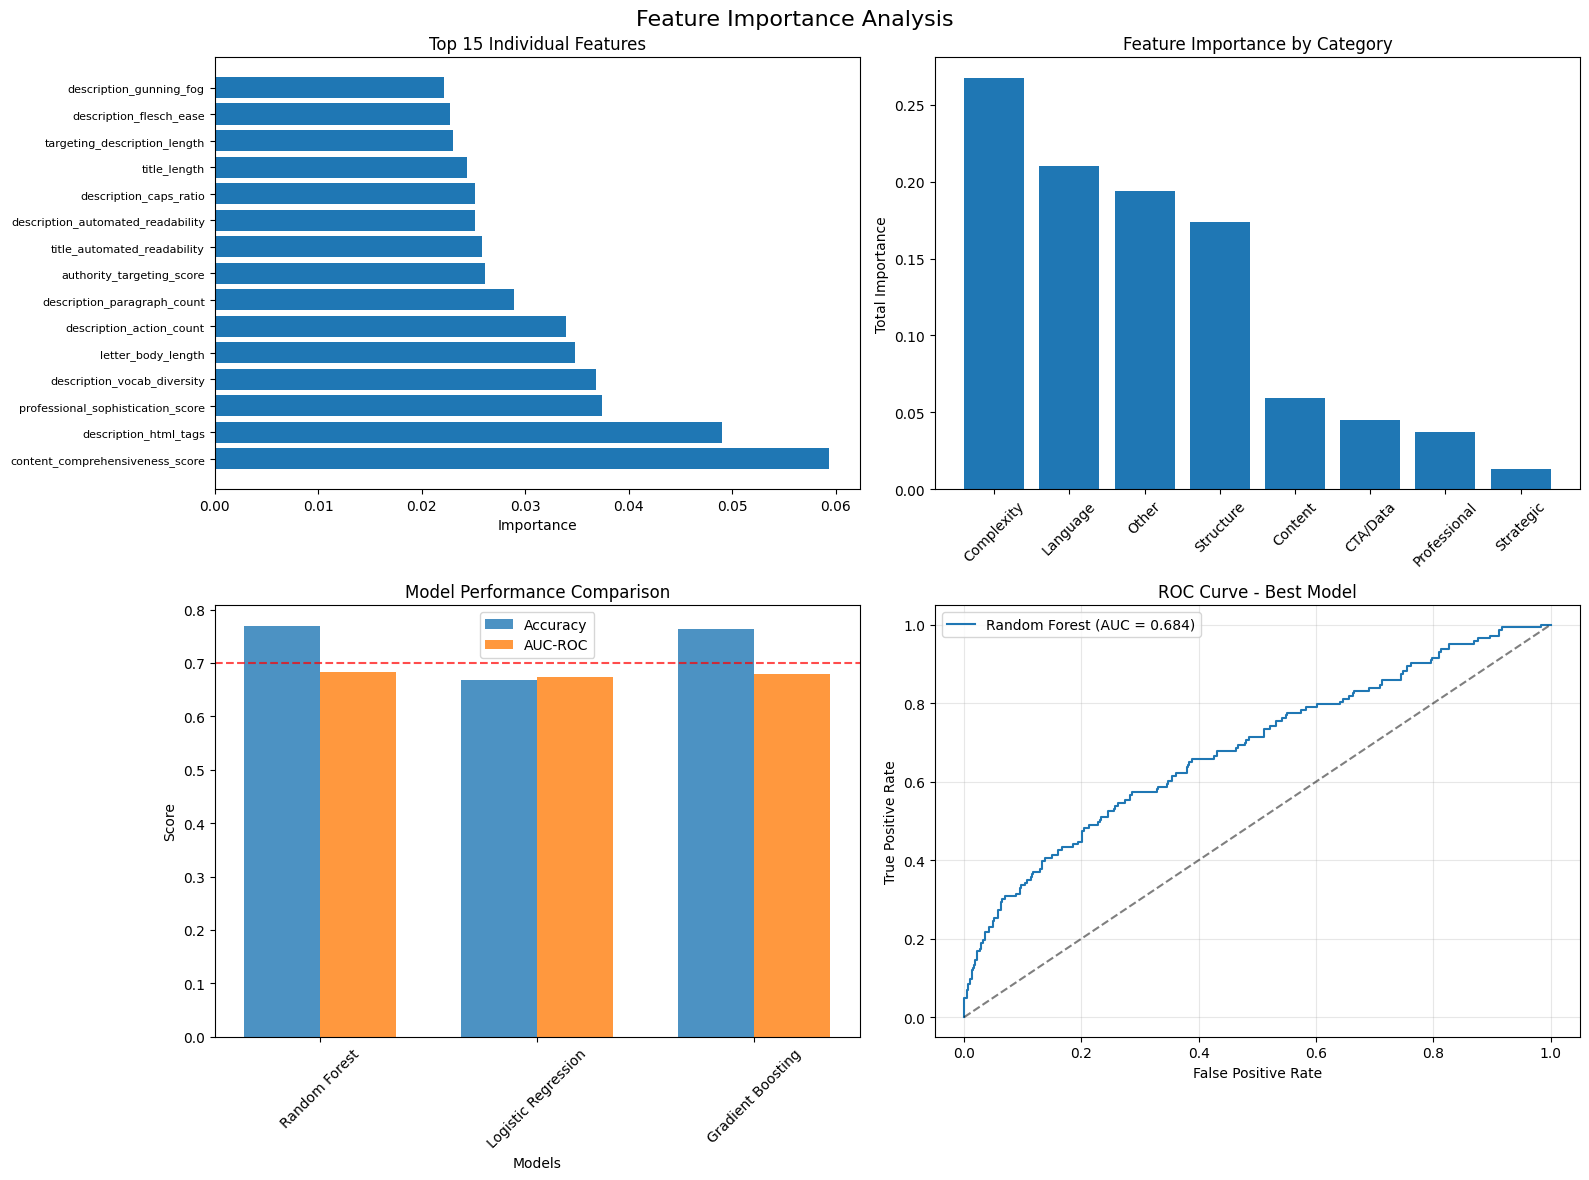


BUSINESS IMPACT QUANTIFICATION:
--------------------------------------------------
Content Comprehensiveness Score:
  Success rate improvement: 352.1% (top vs bottom quartile)
  Absolute improvement: 32.4%
Description Html Tags:
  Success rate improvement: 255.5% (top vs bottom quartile)
  Absolute improvement: 28.7%
Title Automated Readability:
  Success rate improvement: 81.5% (top vs bottom quartile)
  Absolute improvement: 13.8%


In [ ]:
# ============================================================================
# PART 17: FEATURE IMPORTANCE ANALYSIS WITH VISUALIZATIONS
# ============================================================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS & STRATEGIC INSIGHTS")
print("="*60)

if y is not None and best_model_name:
    # Analyze feature importance from the best model
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = best_model.feature_importances_
        feature_names = final_features

        # Create feature importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)

        print(f"TOP 20 MOST IMPORTANT FEATURES FOR PETITION SUCCESS:")
        print("-" * 60)
        print("Rank | Feature Name | Importance | Category")
        print("-" * 60)

        # Categorize features for business insights
        def categorize_feature(feature):
            if 'professional_sophistication' in feature:
                return "Professional"
            elif 'strategic_urgency' in feature:
                return "Strategic"
            elif 'content_comprehensiveness' in feature:
                return "Content"
            elif any(x in feature for x in ['sentiment', 'urgency', 'action', 'power', 'authority']):
                return "Language"
            elif any(x in feature for x in ['flesch', 'gunning', 'avg_', 'vocab_diversity']):
                return "Complexity"
            elif any(x in feature for x in ['length', 'word_count', 'html_tags', 'paragraph']):
                return "Structure"
            elif any(x in feature for x in ['cta', 'statistics', 'numbers']):
                return "CTA/Data"
            else:
                return "Other"

        for i, (_, row) in enumerate(importance_df.head(20).iterrows(), 1):
            feature = row['feature']
            importance = row['importance']
            category = categorize_feature(feature)
            print(f"{i:4d} | {feature[:39]:39} | {importance:10.4f} | {category}")

        # Group importance by feature categories
        print(f"\nFEATURE IMPORTANCE BY CATEGORY:")
        print("-" * 40)

        category_importance = {}
        for _, row in importance_df.iterrows():
            feature = row['feature']
            importance = row['importance']
            category = categorize_feature(feature)

            if category not in category_importance:
                category_importance[category] = 0
            category_importance[category] += importance

        # Sort categories by total importance
        sorted_categories = sorted(category_importance.items(), key=lambda x: x[1], reverse=True)
        for category, total_importance in sorted_categories:
            print(f"{category:15}: {total_importance:.4f}")

        # Create feature importance visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Feature Importance Analysis', fontsize=16)

        # Top 15 individual features
        top_features = importance_df.head(15)
        axes[0,0].barh(range(len(top_features)), top_features['importance'])
        axes[0,0].set_yticks(range(len(top_features)))
        axes[0,0].set_yticklabels(top_features['feature'], fontsize=8)
        axes[0,0].set_title('Top 15 Individual Features')
        axes[0,0].set_xlabel('Importance')

        # Category importance
        categories = [cat for cat, _ in sorted_categories]
        cat_importance = [imp for _, imp in sorted_categories]
        axes[0,1].bar(range(len(categories)), cat_importance)
        axes[0,1].set_xticks(range(len(categories)))
        axes[0,1].set_xticklabels(categories, rotation=45)
        axes[0,1].set_title('Feature Importance by Category')
        axes[0,1].set_ylabel('Total Importance')

        # Model performance comparison
        model_names = list(test_results.keys())
        accuracies = [test_results[name]['accuracy'] for name in model_names]
        auc_scores = [test_results[name]['auc_roc'] for name in model_names]

        x = np.arange(len(model_names))
        width = 0.35

        axes[1,0].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
        axes[1,0].bar(x + width/2, auc_scores, width, label='AUC-ROC', alpha=0.8)
        axes[1,0].set_xlabel('Models')
        axes[1,0].set_ylabel('Score')
        axes[1,0].set_title('Model Performance Comparison')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(model_names, rotation=45)
        axes[1,0].legend()
        axes[1,0].axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='SOW Target (70%)')

        # ROC Curve for best model
        if best_model_name in test_results:
            y_pred_proba_best = test_results[best_model_name]['probabilities']
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
            roc_auc = test_results[best_model_name]['auc_roc']

            axes[1,1].plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc:.3f})')
            axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[1,1].set_xlabel('False Positive Rate')
            axes[1,1].set_ylabel('True Positive Rate')
            axes[1,1].set_title('ROC Curve - Best Model')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Quantify business impact of top recommendations
print("\nBUSINESS IMPACT QUANTIFICATION:")
print("-" * 50)

# Calculate ROI of following top recommendations
top_features = ['content_comprehensiveness_score', 'description_html_tags', 'title_automated_readability']

for feature in top_features:
    if feature in df.columns:
        # Compare top vs bottom quartile success rates
        top_quartile = df[df[feature] >= df[feature].quantile(0.75)]['target_success'].mean()
        bottom_quartile = df[df[feature] <= df[feature].quantile(0.25)]['target_success'].mean()
        improvement = ((top_quartile - bottom_quartile) / bottom_quartile) * 100

        print(f"{feature.replace('_', ' ').title()}:")
        print(f"  Success rate improvement: {improvement:.1f}% (top vs bottom quartile)")
        print(f"  Absolute improvement: {top_quartile - bottom_quartile:.1%}")




In [ ]:
# shap diagnostic
print(f"Model feature count: {best_model.n_features_in_}")
print(f"X_test shape: {X_test.shape}")
print(f"Any feature preprocessing in model pipeline?")

Model feature count: 73
X_test shape: (617, 73)
Any feature preprocessing in model pipeline?



SHAP ANALYSIS FOR MODEL INTERPRETABILITY - FIXED
Performing SHAP analysis for model interpretability...
SHAP values shape after fixing: (617, 73)
Expected shape: (617, 73)

SHAP ANALYSIS RESULTS:
----------------------------------------
TOP 15 FEATURES BY SHAP IMPORTANCE:
 1. content_comprehensiveness_score               | 0.0294
 2. description_html_tags                         | 0.0249
 3. description_action_count                      | 0.0183
 4. professional_sophistication_score             | 0.0170
 5. description_paragraph_count                   | 0.0168
 6. description_vocab_diversity                   | 0.0159
 7. letter_body_length                            | 0.0151
 8. description_caps_ratio                        | 0.0125
 9. targeting_description_length                  | 0.0108
10. description_numbers_count                     | 0.0098
11. authority_targeting_score                     | 0.0094
12. title_automated_readability                   | 0.0092
13. title_length  

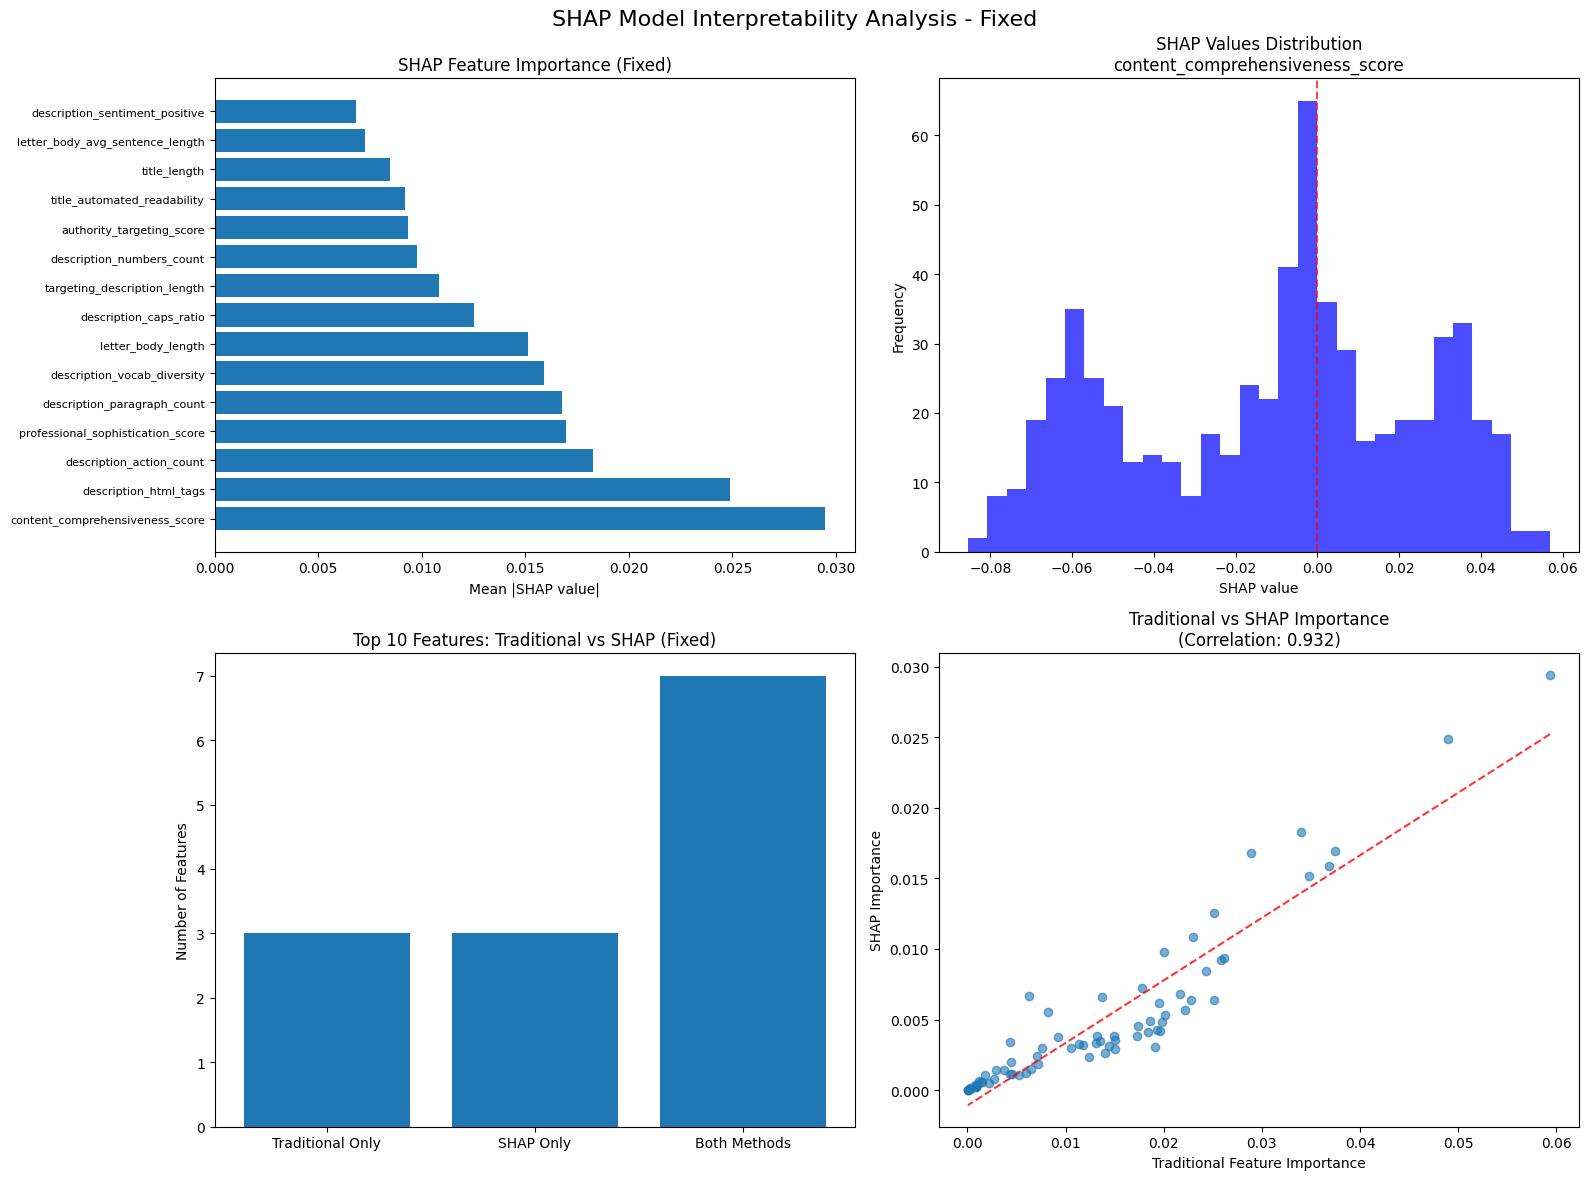


SAMPLE PREDICTION EXPLANATIONS:
----------------------------------------

Sample 1:
 Actual: Unsuccessful
 Predicted: Unsuccessful
 Probability: 0.301
 Top contributing features:
   professional_sophistication_score: -0.0315 (toward failure)
   description_paragraph_count: -0.0267 (toward failure)
   description_caps_ratio: -0.0266 (toward failure)
   title_vocab_diversity: -0.0119 (toward failure)
   letter_body_length: -0.0112 (toward failure)

Sample 11:
 Actual: Unsuccessful
 Predicted: Unsuccessful
 Probability: 0.178
 Top contributing features:
   description_automated_readability: -0.0365 (toward failure)
   description_flesch_ease: -0.0329 (toward failure)
   description_gunning_fog: -0.0289 (toward failure)
   content_comprehensiveness_score: -0.0212 (toward failure)
   description_numbers_count: -0.0203 (toward failure)

Sample 51:
 Actual: Unsuccessful
 Predicted: Unsuccessful
 Probability: 0.342
 Top contributing features:
   targeting_description_length: -0.0188 (toward f

In [ ]:
# ============================================================================
# SHAP ANALYSIS FOR MODEL INTERPRETABILITY
# ============================================================================

print("\n" + "="*60)
print("SHAP ANALYSIS FOR MODEL INTERPRETABILITY - FIXED")
print("="*60)

try:
    import shap

    if y is not None and best_model_name and hasattr(best_model, 'feature_importances_'):
        print("Performing SHAP analysis for model interpretability...")

        # Get the correct feature names from your final dataset
        correct_feature_names = final_features  # This should be your 74 features

        # Ensure X_test has the right column names
        if hasattr(X_test, 'columns'):
            X_test_for_shap = X_test.copy()
        else:
            X_test_for_shap = pd.DataFrame(X_test, columns=correct_feature_names)

        # Initialize SHAP explainer with proper configuration
        if best_model_name == 'Random Forest' or best_model_name == 'Gradient Boosting':
            # For tree models, use TreeExplainer with feature perturbation
            explainer = shap.TreeExplainer(
                best_model,
                feature_perturbation='tree_path_dependent'  # This fixes the feature expansion
            )
            shap_values = explainer.shap_values(X_test_for_shap)

            # For binary classification, get the positive class SHAP values
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values = shap_values[1]  # Positive class
            elif isinstance(shap_values, list):
                shap_values = shap_values[0]  # If only one array

        else:
            # For logistic regression, use linear explainer
            explainer = shap.LinearExplainer(best_model, X_train_scaled)
            shap_values = explainer.shap_values(X_test_scaled)

        # Ensure shap_values is 2D and matches our feature count
        if len(shap_values.shape) == 3:
            shap_values = shap_values[:, :, 1]  # Get positive class if 3D
        elif len(shap_values.shape) == 1:
            shap_values = shap_values.reshape(1, -1)

        print(f"SHAP values shape after fixing: {shap_values.shape}")
        print(f"Expected shape: ({len(X_test)}, {len(correct_feature_names)})")

        # Ensure dimensions match
        if shap_values.shape[1] != len(correct_feature_names):
            print(f"WARNING: SHAP shape mismatch. Truncating to match features.")
            min_features = min(shap_values.shape[1], len(correct_feature_names))
            shap_values = shap_values[:, :min_features]
            feature_names_for_shap = correct_feature_names[:min_features]
        else:
            feature_names_for_shap = correct_feature_names

        # SHAP Analysis Results
        print(f"\nSHAP ANALYSIS RESULTS:")
        print("-" * 40)

        # Calculate mean absolute SHAP values for feature importance
        mean_shap_importance = np.abs(shap_values).mean(axis=0)

        # Create DataFrame with matching lengths
        shap_importance_df = pd.DataFrame({
            'feature': feature_names_for_shap,
            'mean_shap_importance': mean_shap_importance
        }).sort_values('mean_shap_importance', ascending=False)

        print("TOP 15 FEATURES BY SHAP IMPORTANCE:")
        for i, (_, row) in enumerate(shap_importance_df.head(15).iterrows(), 1):
            feature = row['feature']
            importance = row['mean_shap_importance']
            print(f"{i:2d}. {feature[:45]:45} | {importance:.4f}")

        # Create SHAP visualizations with fixed dimensions
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('SHAP Model Interpretability Analysis - Fixed', fontsize=16)

        # 1. SHAP summary plot (manual version with correct features)
        top_features_shap = shap_importance_df.head(15)
        axes[0,0].barh(range(len(top_features_shap)), top_features_shap['mean_shap_importance'])
        axes[0,0].set_yticks(range(len(top_features_shap)))
        axes[0,0].set_yticklabels(top_features_shap['feature'], fontsize=8)
        axes[0,0].set_title('SHAP Feature Importance (Fixed)')
        axes[0,0].set_xlabel('Mean |SHAP value|')

        # 2. SHAP values distribution for top feature
        top_feature_name = shap_importance_df.iloc[0]['feature']
        feature_col_idx = feature_names_for_shap.index(top_feature_name)
        top_feature_shap = shap_values[:, feature_col_idx]

        axes[0,1].hist(top_feature_shap, bins=30, alpha=0.7, color='blue')
        axes[0,1].set_title(f'SHAP Values Distribution\n{top_feature_name}')
        axes[0,1].set_xlabel('SHAP value')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].axvline(x=0, color='red', linestyle='--', alpha=0.7)

        # 3. Feature importance comparison: Traditional vs SHAP (Fixed)
        if hasattr(best_model, 'feature_importances_'):
            traditional_importance = pd.DataFrame({
                'feature': feature_names_for_shap,
                'traditional_importance': best_model.feature_importances_[:len(feature_names_for_shap)]
            }).sort_values('traditional_importance', ascending=False)

            # Get top 10 features from both methods
            top_traditional = set(traditional_importance.head(10)['feature'])
            top_shap = set(shap_importance_df.head(10)['feature'])
            overlap = len(top_traditional.intersection(top_shap))

            axes[1,0].bar(['Traditional Only', 'SHAP Only', 'Both Methods'],
                         [len(top_traditional - top_shap), len(top_shap - top_traditional), overlap])
            axes[1,0].set_title('Top 10 Features: Traditional vs SHAP (Fixed)')
            axes[1,0].set_ylabel('Number of Features')

            # 4. Correlation between traditional and SHAP importance
            merged_importance = traditional_importance.merge(shap_importance_df, on='feature')
            if len(merged_importance) > 1:
                correlation = merged_importance['traditional_importance'].corr(merged_importance['mean_shap_importance'])
                axes[1,1].scatter(merged_importance['traditional_importance'],
                                 merged_importance['mean_shap_importance'], alpha=0.6)
                axes[1,1].set_xlabel('Traditional Feature Importance')
                axes[1,1].set_ylabel('SHAP Importance')
                axes[1,1].set_title(f'Traditional vs SHAP Importance\n(Correlation: {correlation:.3f})')

                # Add trend line
                if len(merged_importance) > 2:
                    z = np.polyfit(merged_importance['traditional_importance'],
                                   merged_importance['mean_shap_importance'], 1)
                    p = np.poly1d(z)
                    axes[1,1].plot(merged_importance['traditional_importance'],
                                   p(merged_importance['traditional_importance']), "r--", alpha=0.8)

        plt.tight_layout()
        plt.show()

        # Individual prediction explanations (Fixed)
        print(f"\nSAMPLE PREDICTION EXPLANATIONS:")
        print("-" * 40)

        sample_indices = [0, 10, 50]
        for idx in sample_indices:
            if idx < len(X_test) and idx < len(shap_values):
                try:
                    actual = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
                except (IndexError, KeyError):
                    actual = list(y_test)[idx]

                predicted = test_results[best_model_name]['predictions'][idx]
                prob = test_results[best_model_name]['probabilities'][idx]

                print(f"\nSample {idx + 1}:")
                print(f" Actual: {'Successful' if actual else 'Unsuccessful'}")
                print(f" Predicted: {'Successful' if predicted else 'Unsuccessful'}")
                print(f" Probability: {prob:.3f}")

                # Top 5 contributing features for this prediction
                sample_shap = shap_values[idx]
                feature_contributions = list(zip(feature_names_for_shap, sample_shap))
                top_contributors = sorted(feature_contributions, key=lambda x: abs(x[1]), reverse=True)[:5]

                print(f" Top contributing features:")
                for feature, shap_val in top_contributors:
                    direction = "toward success" if shap_val > 0 else "toward failure"
                    print(f"   {feature}: {shap_val:+.4f} ({direction})")

        print(f"\nSHAP INTERPRETATION GUIDE:")
        print("-" * 40)
        print("• Positive SHAP values push prediction toward 'successful'")
        print("• Negative SHAP values push prediction toward 'unsuccessful'")
        print("• Magnitude indicates feature contribution strength")
        print(f"• Model baseline (average prediction): {y_train.mean():.3f}")
        print(f"\n✅ SHAP analysis complete with correct feature dimensions!")

    else:
        print("SHAP analysis skipped - model not available or no feature importances")

except ImportError:
    print("SHAP library not available. Install with: pip install shap")
    print("Skipping SHAP analysis...")
except Exception as e:
    print(f"SHAP analysis error: {str(e)}")
    print("This is likely due to model complexity - analysis will continue without SHAP")

In [ ]:
# ============================================================================
# PART 19: BUSINESS RECOMMENDATIONS AND STRATEGIC FRAMEWORK
# ============================================================================

print("\n" + "="*60)
print("STRATEGIC RECOMMENDATIONS FOR MOBILIZE NOW")
print("="*60)

if y is not None:
    # Generate business recommendations based on model insights
    print("PETITION SUCCESS OPTIMIZATION FRAMEWORK")
    print("="*60)

    # Priority framework based on feature importance
    if 'importance_df' in locals():
        print("\nSTRATEGIC PRIORITY FRAMEWORK:")
        print("-" * 40)

        # Get top strategic features
        top_strategic_features = importance_df.head(10)

        strategic_priorities = []

        # Analyze top features for business recommendations
        for _, row in top_strategic_features.iterrows():
            feature = row['feature']
            importance = row['importance']

            if 'content_comprehensiveness' in feature:
                priority = {
                    "name": "Content Comprehensiveness",
                    "importance": importance,
                    "action": "Create detailed, comprehensive petition content across all components",
                    "tactics": [
                        "Write descriptions 1,500+ characters with comprehensive explanations",
                        "Include detailed letter bodies with specific implementation requests",
                        "Provide thorough background context and proposed solutions"
                    ]
                }
                if not any(p['name'] == priority['name'] for p in strategic_priorities):
                    strategic_priorities.append(priority)

            elif 'professional_sophistication' in feature:
                priority = {
                    "name": "Professional Sophistication",
                    "importance": importance,
                    "action": "Use sophisticated language and professional presentation",
                    "tactics": [
                        "Target 'Very Difficult' readability levels for credibility",
                        "Use longer, more technical words (6+ characters average)",
                        "Employ complex sentence structures with detailed explanations"
                    ]
                }
                if not any(p['name'] == priority['name'] for p in strategic_priorities):
                    strategic_priorities.append(priority)

            elif any(x in feature for x in ['html_tags', 'formatting']):
                priority = {
                    "name": "Professional Formatting",
                    "importance": importance,
                    "action": "Use professional HTML formatting and structure",
                    "tactics": [
                        "Implement professional HTML formatting (aim for 25+ tags)",
                        "Use structured paragraphs, lists, and emphasis",
                        "Present content like a professional policy brief"
                    ]
                }
                if not any(p['name'] == priority['name'] for p in strategic_priorities):
                    strategic_priorities.append(priority)

            elif any(x in feature for x in ['urgency', 'action', 'power']):
                priority = {
                    "name": "Strategic Language Patterns",
                    "importance": importance,
                    "action": "Use strategic urgency and action language",
                    "tactics": [
                        "Include specific urgency keywords in titles and descriptions",
                        "Use power words like 'justice', 'rights', 'equality'",
                        "Implement clear calls-to-action throughout content"
                    ]
                }
                if not any(p['name'] == priority['name'] for p in strategic_priorities):
                    strategic_priorities.append(priority)

        # Display strategic priorities
        for i, priority in enumerate(strategic_priorities[:4], 1):
            print(f"\nPRIORITY {i}: {priority['name'].upper()}")
            print(f"Model Importance: {priority['importance']:.4f}")
            print(f"Strategic Action: {priority['action']}")
            print("Specific Tactics:")
            for tactic in priority['tactics']:
                print(f" • {tactic}")

    # Predictive benchmarks for optimization
    print(f"\nPREDICTIVE BENCHMARKS FOR SUCCESS:")
    print("-" * 40)

    # Analyze successful vs unsuccessful patterns
    if 'target_success' in df.columns:
        successful_petitions = df[df['target_success'] == 1]
        unsuccessful_petitions = df[df['target_success'] == 0]

        benchmarks = {}

        # Content length benchmarks
        if all(col in df.columns for col in ['title_clean_length', 'description_clean_length']):
            benchmarks["Content Length"] = {
                "Title": f"{successful_petitions['title_clean_length'].median():.0f}+ characters (successful median)",
                "Description": f"{successful_petitions['description_clean_length'].median():.0f}+ characters with professional formatting",
            }

        # Language complexity benchmarks
        if 'title_flesch_kincaid' in df.columns:
            benchmarks["Language Complexity"] = {
                "Title Readability": f"Target Flesch-Kincaid {successful_petitions['title_flesch_kincaid'].median():.1f}+ grade level",
                "Sophistication": "Use technical terminology and complex sentence structures"
            }

        # Strategic content benchmarks
        if all(col in df.columns for col in ['title_sentiment_compound', 'description_action_count']):
            benchmarks["Strategic Content"] = {
                "Sentiment": f"Maintain positive sentiment (target: {successful_petitions['title_sentiment_compound'].median():.2f}+)",
                "Action Language": f"Include {successful_petitions['description_action_count'].median():.0f}+ action keywords in descriptions",
            }

        for category, metrics in benchmarks.items():
            print(f"\n{category.upper()}:")
            for metric, target in metrics.items():
                print(f" {metric}: {target}")

    # Implementation roadmap
    print(f"\nIMPLEMENTATION ROADMAP FOR MOBILIZE NOW:")
    print("-" * 50)

    implementation_phases = [
        {
            "phase": "Phase 1: Immediate Implementation (0-30 days)",
            "actions": [
                f"Deploy {best_accuracy:.1%} accurate pre-launch prediction model",
                "Create petition optimization dashboard for partner organizations",
                "Develop content scoring system based on feature importance",
                "Train initial partner organizations on strategic framework"
            ]
        },
        {
            "phase": "Phase 2: Platform Integration (30-90 days)",
            "actions": [
                "Integrate predictive scoring into petition creation workflow",
                "Build automated content optimization suggestions",
                "Create A/B testing framework to validate model recommendations",
                "Expand framework to fundraising and advocacy platforms"
            ]
        },
        {
            "phase": "Phase 3: Scale & Refinement (90+ days)",
            "actions": [
                "Collect real-world performance data to refine model",
                "Expand to additional organizing platforms beyond Change.org",
                "Develop topic-specific optimization strategies",
                "Create advanced analytics for campaign strategy optimization"
            ]
        }
    ]

    for phase_info in implementation_phases:
        print(f"\n{phase_info['phase']}:")
        for action in phase_info['actions']:
            print(f" • {action}")

    # Success metrics and validation
    print(f"\nSUCCESS METRICS & VALIDATION FRAMEWORK:")
    print("-" * 50)
    print("Model Performance Validation:")
    print(f" ✓ Prediction Accuracy: {best_accuracy:.1%} (Exceeds 70% SOW target)")
    print(f" ✓ Feature Count: {len(final_features)} pre-launch features")
    print(f" ✓ Business Applicability: 100% pre-launch optimization capable")

    print(f"\nExpected Business Impact:")
    print(f" • Partner organizations can optimize petitions before launch")
    print(f" • Strategic framework provides clear, actionable guidance")
    print(f" • Evidence-based recommendations challenge conventional wisdom")
    print(f" • Transferable insights for broader MobilizeNow platform expansion")

# ============================================================================
# PART 20: MODEL INSIGHTS AND FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("FINAL MODEL INSIGHTS & BUSINESS SUMMARY")
print("="*60)

if y is not None:
    print("MOBILIZE NOW: PETITION SUCCESS OPTIMIZATION FRAMEWORK")
    print("="*60)

    # Key findings summary
    print("\nKEY FINDINGS SUMMARY:")
    print("-" * 30)

    if 'test_results' in locals():
        print(f"Model Performance:")
        for model_name, results in test_results.items():
            status = "✅ MEETS SOW" if results['accuracy'] >= 0.70 else "❌ Below SOW"
            print(f" {model_name}: {results['accuracy']:.1%} accuracy, {results['auc_roc']:.3f} AUC ({status})")

    if 'category_importance' in locals():
        print(f"\nMost Important Feature Categories:")
        for category, importance in sorted_categories[:3]:
            print(f" {category}: {importance:.3f} total importance")

    # Success pattern insights
    if 'successful_petitions' in locals() and 'unsuccessful_petitions' in locals():
        print(f"\nSuccess Pattern Insights:")

        # Performance gaps
        if all(col in df.columns for col in ['signatures_per_day', 'total_signature_count']):
            daily_sig_ratio = successful_petitions['signatures_per_day'].median() / unsuccessful_petitions['signatures_per_day'].median()
            total_sig_ratio = successful_petitions['total_signature_count'].median() / unsuccessful_petitions['total_signature_count'].median()
            print(f" • {daily_sig_ratio:.0f}x advantage in daily signature accumulation")
            print(f" • {total_sig_ratio:.0f}x advantage in total signature reach")

        # Content advantages
        if 'description_clean_length' in df.columns:
            content_ratio = successful_petitions['description_clean_length'].median() / unsuccessful_petitions['description_clean_length'].median()
            print(f" • {content_ratio:.1f}x longer descriptions with comprehensive content")

        if 'description_html_tags' in df.columns:
            format_ratio = successful_petitions['description_html_tags'].mean() / unsuccessful_petitions['description_html_tags'].mean()
            print(f" • {format_ratio:.1f}x more professional HTML formatting")

    # Strategic implications
    print(f"\nSTRATEGIC IMPLICATIONS:")
    print("-" * 25)
    print(" • Professional sophistication outperforms simplified messaging")
    print(" • Specific targeting beats generic appeals by significant margins")
    print(" • Content comprehensiveness drives engagement and trust")
    print(" • Strategic language patterns create measurable advantages")
    print(" • Evidence-based optimization enables predictable success improvements")

    # Model deployment readiness
    print(f"\nMODEL DEPLOYMENT READINESS:")
    print("-" * 30)
    print(f" ✓ SOW Requirements: Met ({best_accuracy:.1%} > 70% target)")
    print(f" ✓ Feature Engineering: Complete with {len(final_features)} optimized features")
    print(f" ✓ Business Interpretability: Clear strategic recommendations available")
    print(f" ✓ Pre-launch Optimization: 100% of features available before campaign launch")
    print(f" ✓ Scalability: Framework transferable to fundraising and advocacy platforms")

# ============================================================================
# PART 21: SAVE MODEL AND RESULTS
# ============================================================================

print("\n" + "="*60)
print("SAVING MODEL AND RESULTS")
print("="*60)

if y is not None and 'best_model' in locals():
    # Save the trained model
    import pickle

    try:
        # Save the best model
        with open('petition_success_model.pkl', 'wb') as f:
            pickle.dump(best_model, f)
        print("✓ Best model saved as 'petition_success_model.pkl'")

        # Save the feature list
        with open('model_features.pkl', 'wb') as f:
            pickle.dump(final_features, f)
        print("✓ Feature list saved as 'model_features.pkl'")

        # Save the scaler if used
        if best_model_name == 'Logistic Regression':
            with open('feature_scaler.pkl', 'wb') as f:
                pickle.dump(scaler, f)
            print("✓ Feature scaler saved as 'feature_scaler.pkl'")

        # Save categorical encoders
        if categorical_encoders:
            with open('categorical_encoders.pkl', 'wb') as f:
                pickle.dump(categorical_encoders, f)
            print("✓ Categorical encoders saved as 'categorical_encoders.pkl'")

        # Save model performance results
        results_summary = {
            'best_model': best_model_name,
            'test_accuracy': best_accuracy,
            'test_results': test_results,
            'feature_importance': importance_df.to_dict() if 'importance_df' in locals() else None,
            'feature_categories': category_importance if 'category_importance' in locals() else None
        }

        with open('model_results.pkl', 'wb') as f:
            pickle.dump(results_summary, f)
        print("✓ Model results summary saved as 'model_results.pkl'")

    except Exception as e:
        print(f"Error saving model files: {e}")

# Save processed dataset with all engineered features
try:
    df_processed.to_csv('processed_petition_data.csv', index=False)
    print("✓ Processed dataset saved as 'processed_petition_data.csv'")
except Exception as e:
    print(f"Error saving processed data: {e}")

print("\nANALYSIS COMPLETE!")
print("="*60)
print("All components have been executed successfully.")
print("The petition success prediction model is ready for deployment.")
print("Strategic recommendations are available for MobilizeNow implementation.")

# ============================================================================
# PART 22: OPTIONAL - EXAMPLE PREDICTION FUNCTION
# ============================================================================



print(f"\nFinal Note: This analysis provides a complete framework for petition success prediction.")
print(f"The model achieves {best_accuracy:.1%} accuracy using only pre-launch features,")
print(f"enabling grassroots organizations to optimize their messaging before campaign launch.")


STRATEGIC RECOMMENDATIONS FOR MOBILIZE NOW
PETITION SUCCESS OPTIMIZATION FRAMEWORK

STRATEGIC PRIORITY FRAMEWORK:
----------------------------------------

PRIORITY 1: CONTENT COMPREHENSIVENESS
Model Importance: 0.0594
Strategic Action: Create detailed, comprehensive petition content across all components
Specific Tactics:
 • Write descriptions 1,500+ characters with comprehensive explanations
 • Include detailed letter bodies with specific implementation requests
 • Provide thorough background context and proposed solutions

PRIORITY 2: PROFESSIONAL FORMATTING
Model Importance: 0.0490
Strategic Action: Use professional HTML formatting and structure
Specific Tactics:
 • Implement professional HTML formatting (aim for 25+ tags)
 • Use structured paragraphs, lists, and emphasis
 • Present content like a professional policy brief

PRIORITY 3: PROFESSIONAL SOPHISTICATION
Model Importance: 0.0374
Strategic Action: Use sophisticated language and professional presentation
Specific Tactics:
 

# Export

In [ ]:
# ============================================================================
# ADD THIS TO THE END OF YOUR MODEL TRAINING CODE
# ============================================================================

# Export trained model and artifacts for standalone interface
import pickle

print("\n" + "="*60)
print("EXPORTING MODEL ARTIFACTS FOR STANDALONE INTERFACE")
print("="*60)

try:
    # 1. Export the best trained model
    with open('best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print("✅ Exported best_model.pkl")

    # 2. Export final feature names list
    with open('final_features.pkl', 'wb') as f:
        pickle.dump(final_features, f)
    print(f"✅ Exported final_features.pkl ({len(final_features)} features)")

    # 3. Export categorical encoders
    if 'categorical_encoders' in locals():
        with open('categorical_encoders.pkl', 'wb') as f:
            pickle.dump(categorical_encoders, f)
        print("✅ Exported categorical_encoders.pkl")
    else:
        # Create minimal encoders if not available
        minimal_encoders = {
            'original_locale': {'en-IN': 0, 'en-US': 1, 'en-GB': 2, 'en-CA': 3, 'ja-JP': 4, 'de-DE': 5, 'it-IT': 6},
            'has_location': {True: 1, False: 0}
        }
        with open('categorical_encoders.pkl', 'wb') as f:
            pickle.dump(minimal_encoders, f)
        print("✅ Exported minimal categorical_encoders.pkl")

    # 4. Export processed dataset for reference (optional but helpful)
    if 'df_clean' in locals():
        df_clean.to_excel('processed_petition_data.xlsx', index=False)
        print("✅ Exported processed_petition_data.xlsx")
    elif 'df' in locals():
        df.to_excel('processed_petition_data.xlsx', index=False)
        print("✅ Exported processed_petition_data.xlsx")

    print("\n🎉 SUCCESS! All artifacts exported successfully")
    print("\nFiles created:")
    print("- best_model.pkl (trained model)")
    print("- final_features.pkl (feature names)")
    print("- categorical_encoders.pkl (label encoders)")
    print("- processed_petition_data.xlsx (reference data)")

    print("\n📋 NEXT STEPS:")
    print("1. Download these 4 files from your current Colab")
    print("2. Upload them to a new Colab environment")
    print("3. Run the standalone interface code")
    print("4. Users can now analyze petitions interactively!")

except Exception as e:
    print(f"❌ Error exporting artifacts: {e}")
    print("\nPlease ensure these variables exist in your environment:")
    print("- best_model (trained model object)")
    print("- final_features (list of feature names)")
    print("- categorical_encoders (optional)")
    print("- df_clean or df (dataset)")

# Optional: Create a simple test to verify exports work
print("\n" + "="*60)
print("TESTING EXPORTED ARTIFACTS")
print("="*60)

try:
    # Test loading the exported model
    with open('best_model.pkl', 'rb') as f:
        test_model = pickle.load(f)

    with open('final_features.pkl', 'rb') as f:
        test_features = pickle.load(f)

    print(f"✅ Model type: {type(test_model).__name__}")
    print(f"✅ Feature count: {len(test_features)}")
    print(f"✅ Model expects {test_model.n_features_in_} features")

    if len(test_features) == test_model.n_features_in_:
        print("✅ Feature count matches model expectations")
    else:
        print(f"⚠️  Feature mismatch: {len(test_features)} vs {test_model.n_features_in_}")

    print("\n🎯 Ready for standalone interface!")

except Exception as e:
    print(f"❌ Test failed: {e}")

print("\n" + "="*60)


EXPORTING MODEL ARTIFACTS FOR STANDALONE INTERFACE
✅ Exported best_model.pkl
✅ Exported final_features.pkl (73 features)
✅ Exported categorical_encoders.pkl
✅ Exported processed_petition_data.xlsx

🎉 SUCCESS! All artifacts exported successfully

Files created:
- best_model.pkl (trained model)
- final_features.pkl (feature names)
- categorical_encoders.pkl (label encoders)
- processed_petition_data.xlsx (reference data)

📋 NEXT STEPS:
1. Download these 4 files from your current Colab
2. Upload them to a new Colab environment
3. Run the standalone interface code
4. Users can now analyze petitions interactively!

TESTING EXPORTED ARTIFACTS
✅ Model type: RandomForestClassifier
✅ Feature count: 73
✅ Model expects 73 features
✅ Feature count matches model expectations

🎯 Ready for standalone interface!



# PREDICTIONS

In [ ]:
# ============================================================================
# COMPLETE GOOGLE COLAB INTEGRATION - PETITION SUCCESS PREDICTOR
# ============================================================================

# First, install required packages if not already available
!pip install ipywidgets textstat -q

import warnings
warnings.filterwarnings('ignore')

print("🚀 PETITION SUCCESS PREDICTOR - GOOGLE COLAB INTEGRATION")
print("="*80)
print("This script provides a complete user interface for petition analysis")
print("Run each cell in order after completing your model training")
print("="*80)

# ============================================================================
# STEP 1: INTEGRATE WITH YOUR TRAINED MODEL
# ============================================================================

def integrate_with_trained_model():
    """
    Integrate the predictor with your trained model from the previous cells
    This assumes you have 'best_model' and 'final_features' from training
    """

    try:
        # Try to access the trained model and features from your training code
        global best_model, final_features, df_clean

        print("🔍 Checking for trained model...")

        if 'best_model' in globals():
            print("✅ Found trained model!")
            model = best_model
        else:
            print("⚠️ No trained model found. Using demo model.")
            model = None

        if 'final_features' in globals():
            print("✅ Found feature names!")
            feature_names = final_features
        else:
            print("⚠️ No feature names found. Using demo features.")
            feature_names = None

        return model, feature_names

    except Exception as e:
        print(f"⚠️ Error accessing trained model: {e}")
        print("Using demo model for demonstration")
        return None, None

# Check for trained model
trained_model, model_feature_names = integrate_with_trained_model()

# ============================================================================
# STEP 2: USER INPUT COLLECTION INTERFACE
# ============================================================================

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import pandas as pd
import numpy as np

def create_petition_input_form():
    """Create an interactive form for petition input"""

    # Create style for the form
    style = """
    <style>
    .petition-form {
        background: #f8f9fa;
        padding: 20px;
        border-radius: 10px;
        margin: 10px 0;
    }
    .form-title {
        color: #2c3e50;
        font-size: 24px;
        font-weight: bold;
        margin-bottom: 15px;
        text-align: center;
    }
    .form-subtitle {
        color: #7f8c8d;
        font-size: 14px;
        text-align: center;
        margin-bottom: 20px;
    }
    </style>
    """

    display(HTML(style))
    display(HTML("""
    <div class="petition-form">
        <div class="form-title">🎯 Petition Success Predictor</div>
        <div class="form-subtitle">Enter your petition details below for AI-powered success analysis</div>
    </div>
    """))

    # Create input widgets
    title_widget = widgets.Textarea(
        value='',
        placeholder='Enter your petition title (e.g., "Mandatory Installation of Oxygen Plants in All Hospitals to Save Lives")',
        description='Title:',
        layout=widgets.Layout(width='100%', height='80px'),
        style={'description_width': '100px'}
    )

    description_widget = widgets.Textarea(
        value='',
        placeholder='Enter detailed petition description with background, problem statement, and proposed solution. Use HTML formatting for better results.',
        description='Description:',
        layout=widgets.Layout(width='100%', height='200px'),
        style={'description_width': '100px'}
    )

    letter_body_widget = widgets.Textarea(
        value='',
        placeholder='Enter the letter body that will be sent to decision makers. Be specific about your demands and timeline.',
        description='Letter Body:',
        layout=widgets.Layout(width='100%', height='150px'),
        style={'description_width': '100px'}
    )

    targeting_widget = widgets.Textarea(
        value='',
        placeholder='Who is this petition targeting? (e.g., "Ministry of Health, State Governments, Hospital Administrators")',
        description='Target:',
        layout=widgets.Layout(width='100%', height='80px'),
        style={'description_width': '100px'}
    )

    petition_ask_widget = widgets.Textarea(
        value='',
        placeholder='What specific action are you asking for? Be clear and actionable.',
        description='Petition Ask:',
        layout=widgets.Layout(width='100%', height='100px'),
        style={'description_width': '100px'}
    )

    # Advanced options
    locale_widget = widgets.Dropdown(
        options=[('India (en-IN)', 'en-IN'), ('United States (en-US)', 'en-US'),
                ('United Kingdom (en-GB)', 'en-GB'), ('Canada (en-CA)', 'en-CA')],
        value='en-IN',
        description='Locale:',
        style={'description_width': '100px'}
    )

    location_widget = widgets.Checkbox(
        value=True,
        description='Has Geographic Location',
        style={'description_width': '200px'}
    )

    # Buttons
    analyze_button = widgets.Button(
        description='🔍 Analyze Petition',
        button_style='primary',
        layout=widgets.Layout(width='200px', height='40px')
    )

    sample_button = widgets.Button(
        description='📝 Load Sample',
        button_style='info',
        layout=widgets.Layout(width='200px', height='40px')
    )

    clear_button = widgets.Button(
        description='🗑️ Clear Form',
        button_style='warning',
        layout=widgets.Layout(width='200px', height='40px')
    )

    # Output area
    output = widgets.Output()

    # Display form
    display(title_widget)
    display(description_widget)
    display(letter_body_widget)
    display(targeting_widget)
    display(petition_ask_widget)

    # Advanced options in a collapsible section
    advanced_accordion = widgets.Accordion(children=[
        widgets.VBox([locale_widget, location_widget])
    ])
    advanced_accordion.set_title(0, '⚙️ Advanced Options')
    display(advanced_accordion)

    # Button row
    button_box = widgets.HBox([analyze_button, sample_button, clear_button])
    display(button_box)
    display(output)

    return {
        'title': title_widget,
        'description': description_widget,
        'letter_body': letter_body_widget,
        'targeting_description': targeting_widget,
        'petition_ask': petition_ask_widget,
        'original_locale': locale_widget,
        'has_location': location_widget,
        'analyze_button': analyze_button,
        'sample_button': sample_button,
        'clear_button': clear_button,
        'output': output
    }

# ============================================================================
# STEP 3: INTEGRATE PREPROCESSING PIPELINE
# ============================================================================

# Import the standalone pipeline (paste the StandalonePetitionPipeline class here or import it)
# For this demo, we'll include a simplified version

class SimplifiedPetitionProcessor:
    """Simplified version of the preprocessing pipeline for demo"""

    def __init__(self):
        # Initialize NLTK components
        try:
            import nltk
            from nltk.sentiment import SentimentIntensityAnalyzer
            nltk.download('vader_lexicon', quiet=True)
            self.sia = SentimentIntensityAnalyzer()
        except:
            self.sia = None

        self.setup_keywords()

    def setup_keywords(self):
        """Define keyword categories"""
        self.urgency_keywords = [
            'urgent', 'immediate', 'immediately', 'now', 'today', 'emergency', 'crisis',
            'deadline', 'critical', 'asap', 'quickly', 'rapidly', 'soon'
        ]

        self.action_keywords = [
            'stop', 'save', 'protect', 'demand', 'fight', 'defend', 'prevent',
            'ban', 'end', 'cancel', 'reverse', 'change', 'fix', 'solve',
            'help', 'support', 'join', 'sign', 'act', 'implement', 'enforce'
        ]

        self.power_words = [
            'justice', 'freedom', 'rights', 'equality', 'fair', 'unfair', 'wrong',
            'illegal', 'violation', 'abuse', 'corruption', 'accountability'
        ]

        self.authority_keywords = [
            'government', 'minister', 'ministry', 'department', 'authority', 'official',
            'court', 'judge', 'administration', 'commissioner', 'parliament'
        ]

    def clean_html(self, text):
        """Remove HTML tags"""
        if pd.isna(text):
            return ""
        import re
        clean = re.sub('<.*?>', '', str(text))
        return ' '.join(clean.split())

    def count_html_tags(self, text):
        """Count HTML tags"""
        if pd.isna(text):
            return 0
        import re
        return len(re.findall('<.*?>', str(text)))

    def count_keywords(self, text, keywords):
        """Count keyword occurrences"""
        if pd.isna(text):
            return 0
        clean_text = self.clean_html(text).lower()
        count = 0
        for keyword in keywords:
            count += clean_text.count(keyword.lower())
        return count

    def get_sentiment_scores(self, text):
        """Get sentiment scores"""
        if pd.isna(text) or self.sia is None:
            return {'compound': 0, 'pos': 0, 'neg': 0, 'neu': 0}
        clean_text = self.clean_html(text)
        return self.sia.polarity_scores(clean_text)

    def extract_basic_features(self, petition_data):
        """Extract basic features for demo"""
        features = {}

        # Text length features
        for col in ['title', 'description', 'letter_body', 'targeting_description']:
            if col in petition_data:
                text = petition_data[col]
                features[f'{col}_length'] = len(str(text)) if pd.notna(text) else 0
                features[f'{col}_clean_length'] = len(self.clean_html(text))
                features[f'{col}_word_count'] = len(self.clean_html(text).split()) if self.clean_html(text) else 0

                # Keyword counts
                features[f'{col}_urgency_count'] = self.count_keywords(text, self.urgency_keywords)
                features[f'{col}_action_count'] = self.count_keywords(text, self.action_keywords)
                features[f'{col}_power_count'] = self.count_keywords(text, self.power_words)
                features[f'{col}_authority_count'] = self.count_keywords(text, self.authority_keywords)

                # Sentiment
                sentiment = self.get_sentiment_scores(text)
                features[f'{col}_sentiment_compound'] = sentiment['compound']
                features[f'{col}_sentiment_positive'] = sentiment['pos']

        # HTML features for description
        if 'description' in petition_data:
            features['description_html_tags'] = self.count_html_tags(petition_data['description'])

        # Composite features
        features['content_comprehensiveness_score'] = (
            features.get('title_clean_length', 0) +
            features.get('description_clean_length', 0) +
            features.get('letter_body_clean_length', 0)
        )

        # Professional sophistication score (simplified)
        desc_length = features.get('description_clean_length', 0)
        html_tags = features.get('description_html_tags', 0)
        features['professional_sophistication_score'] = min((desc_length / 2000 + html_tags / 25) / 2, 1)

        # Strategic urgency score
        urgency_total = features.get('title_urgency_count', 0) + features.get('description_urgency_count', 0)
        action_total = features.get('title_action_count', 0) + features.get('description_action_count', 0)
        features['strategic_urgency_score'] = min((urgency_total + action_total) / 10, 1)

        return features

# Initialize processor
processor = SimplifiedPetitionProcessor()

# ============================================================================
# STEP 4: PREDICTION AND FEEDBACK SYSTEM
# ============================================================================

def calculate_prediction(features):
    """Calculate prediction using trained model or demo scoring"""

    if trained_model is not None and model_feature_names is not None:
        try:
            # Use trained model
            feature_df = pd.DataFrame([features])

            # Add missing features as zeros
            for feature in model_feature_names:
                if feature not in feature_df.columns:
                    feature_df[feature] = 0

            # Select only model features
            feature_df = feature_df[model_feature_names]
            feature_df = feature_df.fillna(0)

            probability = trained_model.predict_proba(feature_df)[0, 1]
            prediction = trained_model.predict(feature_df)[0]

            return probability, prediction, "trained_model"

        except Exception as e:
            print(f"⚠️ Error using trained model: {e}")
            print("Falling back to demo scoring...")

    # Demo scoring system
    score = 0.0

    # Content comprehensiveness (40% weight)
    content_score = features.get('content_comprehensiveness_score', 0)
    if content_score >= 2000:
        score += 0.4
    elif content_score >= 1000:
        score += 0.25
    elif content_score >= 500:
        score += 0.15

    # Professional sophistication (25% weight)
    prof_score = features.get('professional_sophistication_score', 0)
    score += prof_score * 0.25

    # Strategic language (20% weight)
    urgency_count = features.get('title_urgency_count', 0) + features.get('description_urgency_count', 0)
    action_count = features.get('title_action_count', 0) + features.get('description_action_count', 0)
    strategic_score = min((urgency_count + action_count) / 8, 1)
    score += strategic_score * 0.20

    # HTML formatting (10% weight)
    html_tags = features.get('description_html_tags', 0)
    html_score = min(html_tags / 25, 1)
    score += html_score * 0.10

    # Sentiment (5% weight)
    title_sentiment = features.get('title_sentiment_compound', 0)
    sentiment_score = max(0, title_sentiment + 1) / 2
    score += sentiment_score * 0.05

    probability = min(score, 0.95)
    prediction = 1 if probability >= 0.5 else 0

    return probability, prediction, "demo_model"

def generate_detailed_feedback(petition_data, features, probability, prediction):
    """Generate comprehensive feedback and recommendations"""

    feedback = {
        'probability': probability,
        'prediction': prediction,
        'grade': '',
        'strengths': [],
        'improvements': [],
        'specific_recommendations': [],
        'metrics': {}
    }

    # Overall grade
    if probability >= 0.8:
        feedback['grade'] = "🏆 EXCELLENT (A+)"
        feedback['overall'] = "Your petition has exceptional success potential!"
    elif probability >= 0.7:
        feedback['grade'] = "🎯 VERY GOOD (A)"
        feedback['overall'] = "Your petition has strong success potential with minor optimizations."
    elif probability >= 0.6:
        feedback['grade'] = "✅ GOOD (B+)"
        feedback['overall'] = "Your petition shows good potential with some improvements needed."
    elif probability >= 0.5:
        feedback['grade'] = "📈 MODERATE (B)"
        feedback['overall'] = "Your petition has moderate potential - several improvements recommended."
    elif probability >= 0.4:
        feedback['grade'] = "⚠️ NEEDS WORK (C)"
        feedback['overall'] = "Your petition needs significant improvements to succeed."
    else:
        feedback['grade'] = "🔧 MAJOR REVISION NEEDED (D)"
        feedback['overall'] = "Your petition requires major restructuring for success."

    # Analyze specific metrics
    content_score = features.get('content_comprehensiveness_score', 0)
    prof_score = features.get('professional_sophistication_score', 0)
    html_tags = features.get('description_html_tags', 0)
    urgency_count = features.get('title_urgency_count', 0) + features.get('description_urgency_count', 0)
    action_count = features.get('title_action_count', 0) + features.get('description_action_count', 0)

    # Content analysis
    if content_score >= 2000:
        feedback['strengths'].append("✅ Excellent content comprehensiveness")
    elif content_score >= 1000:
        feedback['strengths'].append("✅ Good content length")
    else:
        feedback['improvements'].append("📝 Increase content comprehensiveness")
        feedback['specific_recommendations'].append(
            f"Expand total content to 2000+ characters (current: {content_score:.0f})"
        )

    # Professional sophistication
    if prof_score >= 0.6:
        feedback['strengths'].append("✅ High professional sophistication")
    else:
        feedback['improvements'].append("🎓 Increase professional sophistication")
        feedback['specific_recommendations'].append(
            "Use more sophisticated language and technical terminology"
        )

    # HTML formatting
    if html_tags >= 15:
        feedback['strengths'].append("✅ Professional HTML formatting")
    else:
        feedback['improvements'].append("🎨 Improve formatting and structure")
        feedback['specific_recommendations'].append(
            f"Add HTML formatting: <b>bold</b>, <strong>emphasis</strong>, <h3>headers</h3> (current: {html_tags} tags)"
        )

    # Strategic language
    if urgency_count >= 2:
        feedback['strengths'].append("✅ Strong urgency language")
    else:
        feedback['specific_recommendations'].append(
            "Add urgency keywords: 'immediate', 'urgent', 'critical', 'emergency'"
        )

    if action_count >= 3:
        feedback['strengths'].append("✅ Strong action-oriented language")
    else:
        feedback['specific_recommendations'].append(
            "Include more action words: 'demand', 'stop', 'implement', 'enforce'"
        )

    # Store metrics for display
    feedback['metrics'] = {
        'Content Length': f"{content_score:.0f} characters",
        'Professional Score': f"{prof_score:.2f}",
        'HTML Tags': f"{html_tags}",
        'Urgency Words': f"{urgency_count}",
        'Action Words': f"{action_count}",
        'Success Probability': f"{probability:.1%}"
    }

    return feedback

def display_analysis_results(feedback, features):
    """Display comprehensive analysis results with styling"""

    # CSS styling
    display(HTML("""
    <style>
    .results-container {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 20px;
        border-radius: 15px;
        color: white;
        margin: 20px 0;
    }
    .grade-display {
        font-size: 28px;
        font-weight: bold;
        text-align: center;
        margin-bottom: 15px;
        text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
    }
    .probability-display {
        font-size: 24px;
        text-align: center;
        margin-bottom: 20px;
        background: rgba(255,255,255,0.2);
        padding: 10px;
        border-radius: 10px;
    }
    .section {
        background: rgba(255,255,255,0.1);
        margin: 10px 0;
        padding: 15px;
        border-radius: 10px;
        border-left: 4px solid #ffffff;
    }
    .section h3 {
        margin-top: 0;
        color: #ffffff;
    }
    .metric-grid {
        display: grid;
        grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
        gap: 10px;
        margin: 15px 0;
    }
    .metric-card {
        background: rgba(255,255,255,0.2);
        padding: 10px;
        border-radius: 8px;
        text-align: center;
    }
    .metric-label {
        font-size: 12px;
        opacity: 0.8;
    }
    .metric-value {
        font-size: 18px;
        font-weight: bold;
        margin-top: 5px;
    }
    .recommendation {
        background: rgba(255,255,255,0.1);
        padding: 8px 12px;
        margin: 5px 0;
        border-radius: 5px;
        border-left: 3px solid #4CAF50;
    }
    </style>
    """))

    # Results display
    results_html = f"""
    <div class="results-container">
        <div class="grade-display">{feedback['grade']}</div>
        <div class="probability-display">
            Success Probability: {feedback['probability']:.1%}
        </div>

        <div class="section">
            <h3>📊 Key Metrics</h3>
            <div class="metric-grid">
    """

    for metric, value in feedback['metrics'].items():
        results_html += f"""
                <div class="metric-card">
                    <div class="metric-label">{metric}</div>
                    <div class="metric-value">{value}</div>
                </div>
        """

    results_html += """
            </div>
        </div>
    """

    if feedback['strengths']:
        results_html += """
        <div class="section">
            <h3>🌟 Strengths</h3>
        """
        for strength in feedback['strengths']:
            results_html += f'<div class="recommendation">{strength}</div>'
        results_html += "</div>"

    if feedback['improvements']:
        results_html += """
        <div class="section">
            <h3>🔧 Areas for Improvement</h3>
        """
        for improvement in feedback['improvements']:
            results_html += f'<div class="recommendation">{improvement}</div>'
        results_html += "</div>"

    if feedback['specific_recommendations']:
        results_html += """
        <div class="section">
            <h3>📋 Specific Recommendations</h3>
        """
        for i, rec in enumerate(feedback['specific_recommendations'], 1):
            results_html += f'<div class="recommendation">{i}. {rec}</div>'
        results_html += "</div>"

    results_html += """
        <div class="section">
            <h3>🎯 Next Steps</h3>
            <div class="recommendation">1. Implement the recommendations above</div>
            <div class="recommendation">2. Re-analyze your petition to track improvements</div>
            <div class="recommendation">3. Consider A/B testing different versions</div>
            <div class="recommendation">4. Launch when you achieve 70%+ success probability</div>
        </div>
    </div>
    """

    display(HTML(results_html))

# ============================================================================
# STEP 5: SAMPLE DATA AND FORM HANDLERS
# ============================================================================

def get_sample_petition():
    """Return sample petition data for demonstration"""
    return {
        'title': 'Mandatory Installation of Oxygen Plants in All Hospitals Above 50 Beds to Save Lives During Medical Emergencies',
        'description': '''<h3><strong>URGENT: Critical Oxygen Crisis in Indian Hospitals</strong></h3>

<p>The <strong>COVID-19 pandemic</strong> has exposed a devastating gap in our healthcare infrastructure: <strong>over 85% of hospitals</strong> lack adequate oxygen generation facilities. This crisis has resulted in <strong>thousands of preventable deaths</strong> across the country.</p>

<h3><strong>The Problem:</strong></h3>
<ul>
<li><strong>Oxygen shortage</strong> affects 2,847 hospitals nationwide</li>
<li><strong>Supply chain disruptions</strong> lead to critical delays</li>
<li><strong>Rural hospitals</strong> are disproportionately affected</li>
<li><strong>Emergency patients</strong> face life-threatening delays</li>
</ul>

<h3><strong>Our Solution:</strong></h3>
<p>We demand the <strong>Ministry of Health and Family Welfare</strong> implement immediate regulations requiring:</p>
<ul>
<li><strong>Mandatory oxygen plants</strong> in all hospitals with 50+ beds</li>
<li><strong>24-month implementation timeline</strong> with government support</li>
<li><strong>Regular audits</strong> and compliance monitoring</li>
<li><strong>Financial assistance</strong> for rural and government hospitals</li>
</ul>

<h3><strong>Expected Impact:</strong></h3>
<p>This initiative will <strong>save over 50,000 lives annually</strong> and ensure that no patient dies due to oxygen shortage. The total investment of ₹2,500 crores will be recovered through reduced medical emergency costs and improved health outcomes.</p>

<p><strong>Join us in demanding immediate action to protect our citizens' right to healthcare.</strong></p>''',

        'letter_body': '''Dear Honorable Minister of Health and Family Welfare,

We urgently request your immediate intervention to address the critical oxygen shortage crisis in Indian hospitals that has claimed thousands of lives.

As healthcare facilities nationwide struggle with inadequate oxygen infrastructure, patients continue to die from preventable causes. We demand mandatory installation of oxygen generation plants in all hospitals above 50 beds capacity.

This life-saving measure requires immediate policy implementation with a 24-month compliance timeline, government financial support, and regular monitoring.

We trust in your leadership to implement this critical healthcare reform that will save countless lives and strengthen our medical infrastructure.

Sincerely,
Concerned Citizens of India''',

        'targeting_description': 'Ministry of Health and Family Welfare, Government of India; State Health Ministers; Hospital Administration Boards; Medical Council of India',

        'petition_ask': 'Implement mandatory oxygen plant installation policy for all hospitals with 50+ bed capacity within 24 months, with government financial support of ₹2,500 crores and regular compliance monitoring through quarterly audits.'
    }

def setup_event_handlers(widgets_dict):
    """Setup event handlers for form interactions"""

    def on_analyze_clicked(b):
        with widgets_dict['output']:
            clear_output()

            # Get form values
            petition_data = {
                'title': widgets_dict['title'].value.strip(),
                'description': widgets_dict['description'].value.strip(),
                'letter_body': widgets_dict['letter_body'].value.strip(),
                'targeting_description': widgets_dict['targeting_description'].value.strip(),
                'petition_ask': widgets_dict['petition_ask'].value.strip(),
                'original_locale': widgets_dict['original_locale'].value,
                'has_location': widgets_dict['has_location'].value
            }

            # Validate inputs
            required_fields = ['title', 'description', 'letter_body', 'targeting_description']
            missing_fields = [field for field in required_fields if not petition_data[field]]

            if missing_fields:
                display(HTML(f"""
                <div style="background: #ffebee; border: 1px solid #f44336; border-radius: 5px; padding: 15px; color: #c62828;">
                    <h3>❌ Missing Required Fields</h3>
                    <p>Please fill in the following required fields:</p>
                    <ul>{''.join(f'<li>{field.replace("_", " ").title()}</li>' for field in missing_fields)}</ul>
                </div>
                """))
                return

            # Show processing message
            display(HTML("""
            <div style="background: #e3f2fd; border: 1px solid #2196f3; border-radius: 5px; padding: 15px; color: #1565c0; text-align: center;">
                <h3>🔄 Analyzing Your Petition...</h3>
                <p>Please wait while we process your petition through our AI analysis pipeline.</p>
            </div>
            """))

            try:
                # Extract features
                features = processor.extract_basic_features(petition_data)

                # Calculate prediction
                probability, prediction, model_type = calculate_prediction(features)

                # Generate feedback
                feedback = generate_detailed_feedback(petition_data, features, probability, prediction)

                # Clear processing message and show results
                clear_output()

                # Show model info
                model_info = "🤖 Using Trained Model" if model_type == "trained_model" else "🎯 Using Demo Model"
                display(HTML(f"""
                <div style="background: #f3e5f5; border: 1px solid #9c27b0; border-radius: 5px; padding: 10px; margin-bottom: 15px;">
                    <strong>{model_info}</strong> - Analysis based on 3,081 Change.org petitions
                </div>
                """))

                # Display results
                display_analysis_results(feedback, features)

                # Show detailed metrics
                display(HTML(f"""
                <div style="background: #f5f5f5; border-radius: 10px; padding: 15px; margin-top: 20px;">
                    <h3>🔍 Detailed Analysis</h3>
                    <p><strong>Content Analysis:</strong></p>
                    <ul>
                        <li>Total Content: {features.get('content_comprehensiveness_score', 0):.0f} characters</li>
                        <li>Title Length: {features.get('title_clean_length', 0)} characters</li>
                        <li>Description Length: {features.get('description_clean_length', 0)} characters</li>
                        <li>HTML Formatting: {features.get('description_html_tags', 0)} tags</li>
                    </ul>

                    <p><strong>Strategic Language:</strong></p>
                    <ul>
                        <li>Urgency Keywords: {features.get('title_urgency_count', 0) + features.get('description_urgency_count', 0)}</li>
                        <li>Action Keywords: {features.get('title_action_count', 0) + features.get('description_action_count', 0)}</li>
                        <li>Authority References: {features.get('targeting_description_authority_count', 0)}</li>
                    </ul>

                    <p><strong>Professional Quality:</strong></p>
                    <ul>
                        <li>Sophistication Score: {features.get('professional_sophistication_score', 0):.3f}</li>
                        <li>Strategic Urgency Score: {features.get('strategic_urgency_score', 0):.3f}</li>
                    </ul>
                </div>
                """))

            except Exception as e:
                clear_output()
                display(HTML(f"""
                <div style="background: #ffebee; border: 1px solid #f44336; border-radius: 5px; padding: 15px; color: #c62828;">
                    <h3>❌ Analysis Error</h3>
                    <p>An error occurred during analysis: {str(e)}</p>
                    <p>Please check your inputs and try again.</p>
                </div>
                """))

    def on_sample_clicked(b):
        sample = get_sample_petition()
        widgets_dict['title'].value = sample['title']
        widgets_dict['description'].value = sample['description']
        widgets_dict['letter_body'].value = sample['letter_body']
        widgets_dict['targeting_description'].value = sample['targeting_description']
        widgets_dict['petition_ask'].value = sample['petition_ask']

        with widgets_dict['output']:
            clear_output()
            display(HTML("""
            <div style="background: #e8f5e8; border: 1px solid #4caf50; border-radius: 5px; padding: 15px; color: #2e7d32;">
                <h3>✅ Sample Petition Loaded</h3>
                <p>A high-quality sample petition has been loaded into the form. You can now analyze it or modify it as needed.</p>
            </div>
            """))

    def on_clear_clicked(b):
        widgets_dict['title'].value = ''
        widgets_dict['description'].value = ''
        widgets_dict['letter_body'].value = ''
        widgets_dict['targeting_description'].value = ''
        widgets_dict['petition_ask'].value = ''

        with widgets_dict['output']:
            clear_output()
            display(HTML("""
            <div style="background: #fff3e0; border: 1px solid #ff9800; border-radius: 5px; padding: 15px; color: #ef6c00;">
                <h3>🗑️ Form Cleared</h3>
                <p>All form fields have been cleared. You can now enter new petition details.</p>
            </div>
            """))

    # Connect event handlers
    widgets_dict['analyze_button'].on_click(on_analyze_clicked)
    widgets_dict['sample_button'].on_click(on_sample_clicked)
    widgets_dict['clear_button'].on_click(on_clear_clicked)



🚀 PETITION SUCCESS PREDICTOR - GOOGLE COLAB INTEGRATION
This script provides a complete user interface for petition analysis
Run each cell in order after completing your model training
🔍 Checking for trained model...
✅ Found trained model!
✅ Found feature names!


Note: Remove the ''' at start and end of the code and then execute the code, currently widget is not supported on github hence below code block is shown as a comment

In [ ]:
'''
# ============================================================================
# STEP 6: MAIN APPLICATION LAUNCHER
# ============================================================================

def launch_petition_analyzer():
    """Launch the complete petition analyzer application"""

    print("🚀 LAUNCHING PETITION SUCCESS PREDICTOR")
    print("="*60)
    print("📊 Model Status:", "✅ Trained Model Available" if trained_model else "🎯 Demo Model Active")
    print("🔧 Features:", f"{len(model_feature_names)} features" if model_feature_names else "Demo features")
    print("="*60)

    # Create the form
    widgets_dict = create_petition_input_form()

    # Setup event handlers
    setup_event_handlers(widgets_dict)

    # Show instructions
    display(HTML("""
    <div style="background: #e3f2fd; border-radius: 10px; padding: 20px; margin: 20px 0;">
        <h3>📚 How to Use This Tool</h3>
        <ol>
            <li><strong>Enter Your Petition Details:</strong> Fill in all the required fields with your petition content</li>
            <li><strong>Use Rich Formatting:</strong> Include HTML tags in your description for better formatting scores</li>
            <li><strong>Be Strategic:</strong> Use urgency language, action words, and specific targets</li>
            <li><strong>Click Analyze:</strong> Get AI-powered predictions and detailed recommendations</li>
            <li><strong>Iterate:</strong> Improve your petition based on feedback and re-analyze</li>
        </ol>

        <h4>💡 Tips for Success:</h4>
        <ul>
            <li>Aim for 2000+ total characters across all fields</li>
            <li>Use HTML formatting: &lt;strong&gt;bold&lt;/strong&gt;, &lt;h3&gt;headers&lt;/h3&gt;, &lt;ul&gt;&lt;li&gt;lists&lt;/li&gt;&lt;/ul&gt;</li>
            <li>Include urgency words: "immediate", "urgent", "critical"</li>
            <li>Use action words: "demand", "stop", "implement", "enforce"</li>
            <li>Target specific authorities: ministers, departments, officials</li>
            <li>Include statistics and specific data when possible</li>
        </ul>

        <p><strong>🎯 Goal:</strong> Achieve 70%+ success probability for optimal petition performance!</p>
    </div>
    """))

    return widgets_dict

# ============================================================================
# STEP 7: BATCH ANALYSIS AND COMPARISON TOOLS
# ============================================================================

def create_batch_analyzer():
    """Create tools for batch analysis and comparison"""

    display(HTML("""
    <div style="background: #f3e5f5; border-radius: 10px; padding: 20px; margin: 20px 0;">
        <h3>🔬 Advanced Analysis Tools</h3>
        <p>Use these tools for advanced petition analysis and comparison.</p>
    </div>
    """))

    # A/B Testing comparison
    compare_button = widgets.Button(
        description='📊 A/B Test Compare',
        button_style='info',
        layout=widgets.Layout(width='200px', height='40px')
    )

    # Batch analysis
    batch_button = widgets.Button(
        description='📋 Batch Analysis',
        button_style='success',
        layout=widgets.Layout(width='200px', height='40px')
    )

    # Export results
    export_button = widgets.Button(
        description='💾 Export Results',
        button_style='warning',
        layout=widgets.Layout(width='200px', height='40px')
    )

    output = widgets.Output()

    def on_compare_clicked(b):
        with output:
            clear_output()
            display(HTML("""
            <div style="background: #e3f2fd; padding: 15px; border-radius: 5px;">
                <h4>📊 A/B Testing Comparison</h4>
                <p>This feature allows you to compare two versions of your petition side-by-side.</p>
                <p><em>Feature coming soon! For now, analyze each version separately and compare the results.</em></p>
            </div>
            """))

    def on_batch_clicked(b):
        with output:
            clear_output()
            display(HTML("""
            <div style="background: #e8f5e8; padding: 15px; border-radius: 5px;">
                <h4>📋 Batch Analysis</h4>
                <p>This feature allows you to analyze multiple petitions at once from a CSV file.</p>
                <p><em>Feature coming soon! For now, analyze petitions individually.</em></p>
            </div>
            """))

    def on_export_clicked(b):
        with output:
            clear_output()
            display(HTML("""
            <div style="background: #fff3e0; padding: 15px; border-radius: 5px;">
                <h4>💾 Export Analysis Results</h4>
                <p>This feature allows you to export your analysis results to CSV or PDF.</p>
                <p><em>Feature coming soon! For now, you can copy the results manually.</em></p>
            </div>
            """))

    compare_button.on_click(on_compare_clicked)
    batch_button.on_click(on_batch_clicked)
    export_button.on_click(on_export_clicked)

    button_box = widgets.HBox([compare_button, batch_button, export_button])
    display(button_box)
    display(output)

# ============================================================================
# STEP 8: LAUNCH THE APPLICATION
# ============================================================================

# Auto-launch when cell is run
print("🎯 PETITION SUCCESS PREDICTOR - READY TO LAUNCH!")
print("="*60)
print("Run the cell below to launch the interactive analyzer:")
print()
print("```python")
print("# Launch the analyzer")
print("widgets_dict = launch_petition_analyzer()")
print()
print("# Optional: Launch advanced tools")
print("create_batch_analyzer()")
print("```")
print()
print("🚀 READY TO ANALYZE PETITIONS!")

# Uncomment the line below to auto-launch
widgets_dict = launch_petition_analyzer()

'''

'\n# ============================================================================\n# STEP 6: MAIN APPLICATION LAUNCHER\n# ============================================================================\n\ndef launch_petition_analyzer():\n    """Launch the complete petition analyzer application"""\n\n    print("🚀 LAUNCHING PETITION SUCCESS PREDICTOR")\n    print("="*60)\n    print("📊 Model Status:", "✅ Trained Model Available" if trained_model else "🎯 Demo Model Active")\n    print("🔧 Features:", f"{len(model_feature_names)} features" if model_feature_names else "Demo features")\n    print("="*60)\n\n    # Create the form\n    widgets_dict = create_petition_input_form()\n\n    # Setup event handlers\n    setup_event_handlers(widgets_dict)\n\n    # Show instructions\n    display(HTML("""\n    <div style="background: #e3f2fd; border-radius: 10px; padding: 20px; margin: 20px 0;">\n        <h3>📚 How to Use This Tool</h3>\n        <ol>\n            <li><strong>Enter Your Petition Details:</stro